In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import pandas as pd
import numpy as np
import torch
from torch import nn
import copy
from nn_helpers import SampleData, AdHocData, NeuralNetworkV0, NeuralNetworkV1, NeuralNetworkV2, train_loop, test_loop, train_nn, pred_tensor, pred_vals, all_vals_df, \
    plot_predictions_by_truth, plot_predictions_by_sample, plot_predictions, plot_best_system_pred, split_samples, split_by_max, split_by_signal
from flat_samples import samples, even_samples,  odd_samples, sample_names, signal_sample_names, background_sample_names, sample_id_dict
from branch_names import BranchNames, branch_names
from tqdm import tqdm
import joblib
from timeit import default_timer as timer
from time import strftime
import math

### Network dictionary

In [3]:
model_dict = {0 : NeuralNetworkV0,
              1 : NeuralNetworkV1,
              2 : NeuralNetworkV2}

### Sample dictionary

In [4]:
sample_dict = {'all'  : samples,
               'even' : even_samples,
               'odd'  : odd_samples}

### Custom data classes

In [5]:
signal_data = SampleData(samples, signal_sample_names, branch_names)
signal_data.prepare_training_data()
signal_data.prepare_full_data()
signal_scaler = signal_data.scaler

background_data = SampleData(samples, background_sample_names, branch_names)
background_data.prepare_training_data()
background_data.prepare_full_data()
background_scaler = background_data.scaler

all_data = SampleData(samples, sample_names, branch_names)
all_data.prepare_training_data()
all_data.prepare_full_data()
all_scaler = all_data.scaler

even_data = SampleData(even_samples, sample_names, branch_names)
even_data.prepare_training_data()
even_data.prepare_full_data()
even_scaler = even_data.scaler

odd_data = SampleData(odd_samples, sample_names, branch_names)
odd_data.prepare_training_data()
odd_data.prepare_full_data()
odd_scaler = odd_data.scaler

In [6]:
sig10_odd_data = SampleData(odd_samples, ['X1000'], branch_names)
sig10_odd_data.prepare_training_data()
sig10_odd_data.prepare_full_data()
sig10_odd_scaler = odd_data.scaler

sig10_even_data = SampleData(even_samples, ['X1000'], branch_names)
sig10_even_data.prepare_training_data()
sig10_even_data.prepare_full_data()
sig10_even_scaler = even_data.scaler

sig16_odd_data = SampleData(odd_samples, ['X1600'], branch_names)
sig16_odd_data.prepare_training_data()
sig16_odd_data.prepare_full_data()
sig16_odd_scaler = odd_data.scaler

sig16_even_data = SampleData(even_samples, ['X1600'], branch_names)
sig16_even_data.prepare_training_data()
sig16_even_data.prepare_full_data()
sig16_even_scaler = even_data.scaler

### Get training device

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


### Define loss and optimizer

In [7]:
learning_rate = 1e-3
loss = nn.BCEWithLogitsLoss()

## Signal + Background Training

## V1

### Version and sample

In [ ]:
version = 1
train_sample = even_samples

### File naming

In [7]:
model_path = f'../trained_models/all_trained_dnn_v{version}'
scaler_path = f'../trained_models/all_trained_dnn_v{version}_scaler.gz'

### Create  model

In [9]:
network = model_dict[version]
all_model = network(branch_names).to(device)

### Save model

In [ ]:
torch.save(all_model.state_dict(), model_path)
joblib.dump(all_scaler, scaler_path)

### Load model

In [10]:
all_model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
all_model.eval()

NeuralNetworkV1(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=19, out_features=38, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=38, out_features=57, bias=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=57, out_features=57, bias=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): ReLU()
    (9): Linear(in_features=57, out_features=57, bias=True)
    (10): Dropout(p=0.2, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=57, out_features=38, bias=True)
    (13): Dropout(p=0.2, inplace=False)
    (14): ReLU()
    (15): Linear(in_features=38, out_features=1, bias=True)
  )
)

### Define loss and optimizer

In [11]:
optimizer = torch.optim.SGD(all_model.parameters(), lr=learning_rate)

### Train and test

100%|██████████| 1000/1000 [4:36:38<00:00, 16.60s/it] 


Done!


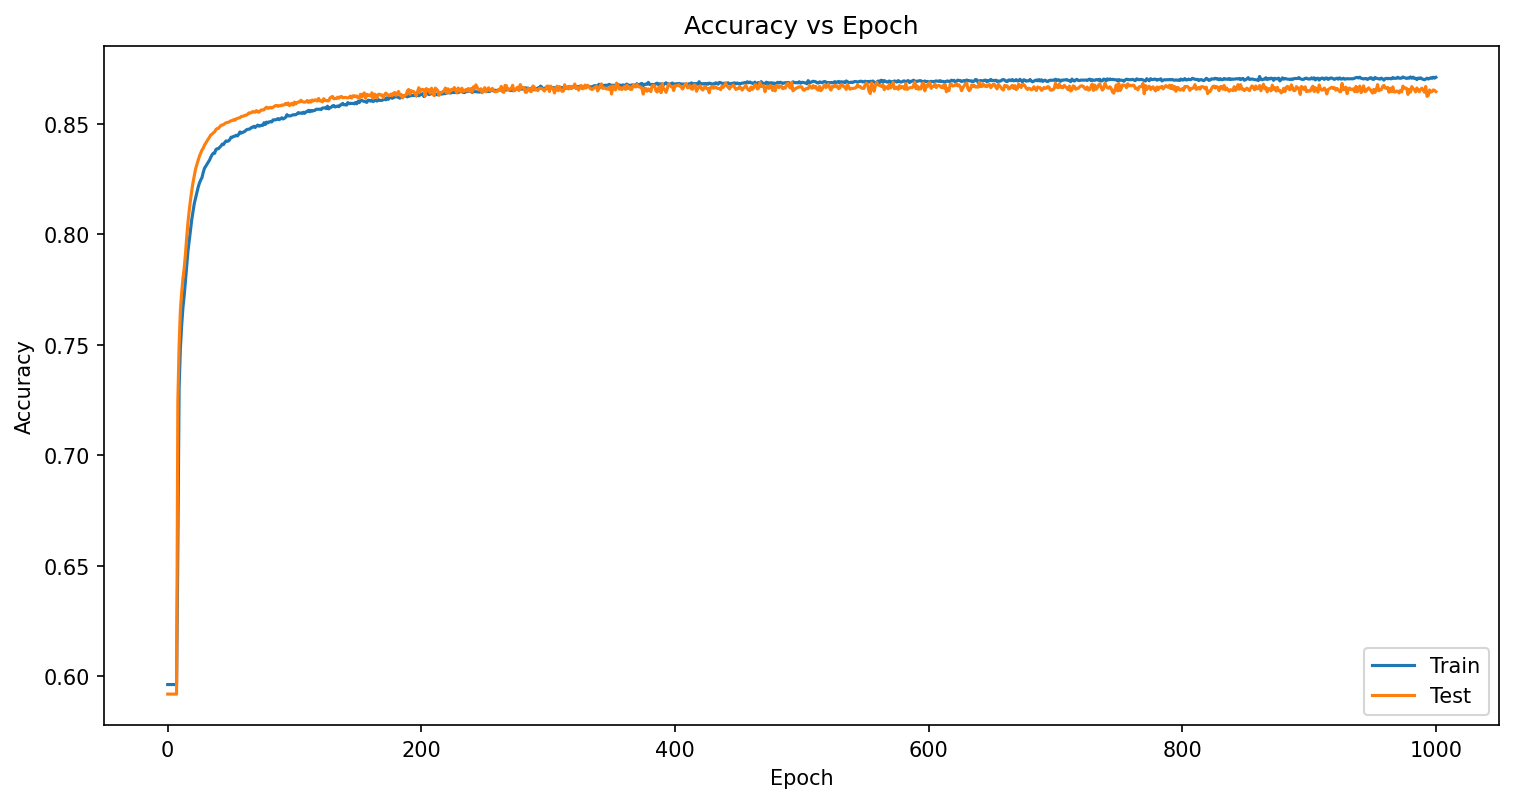

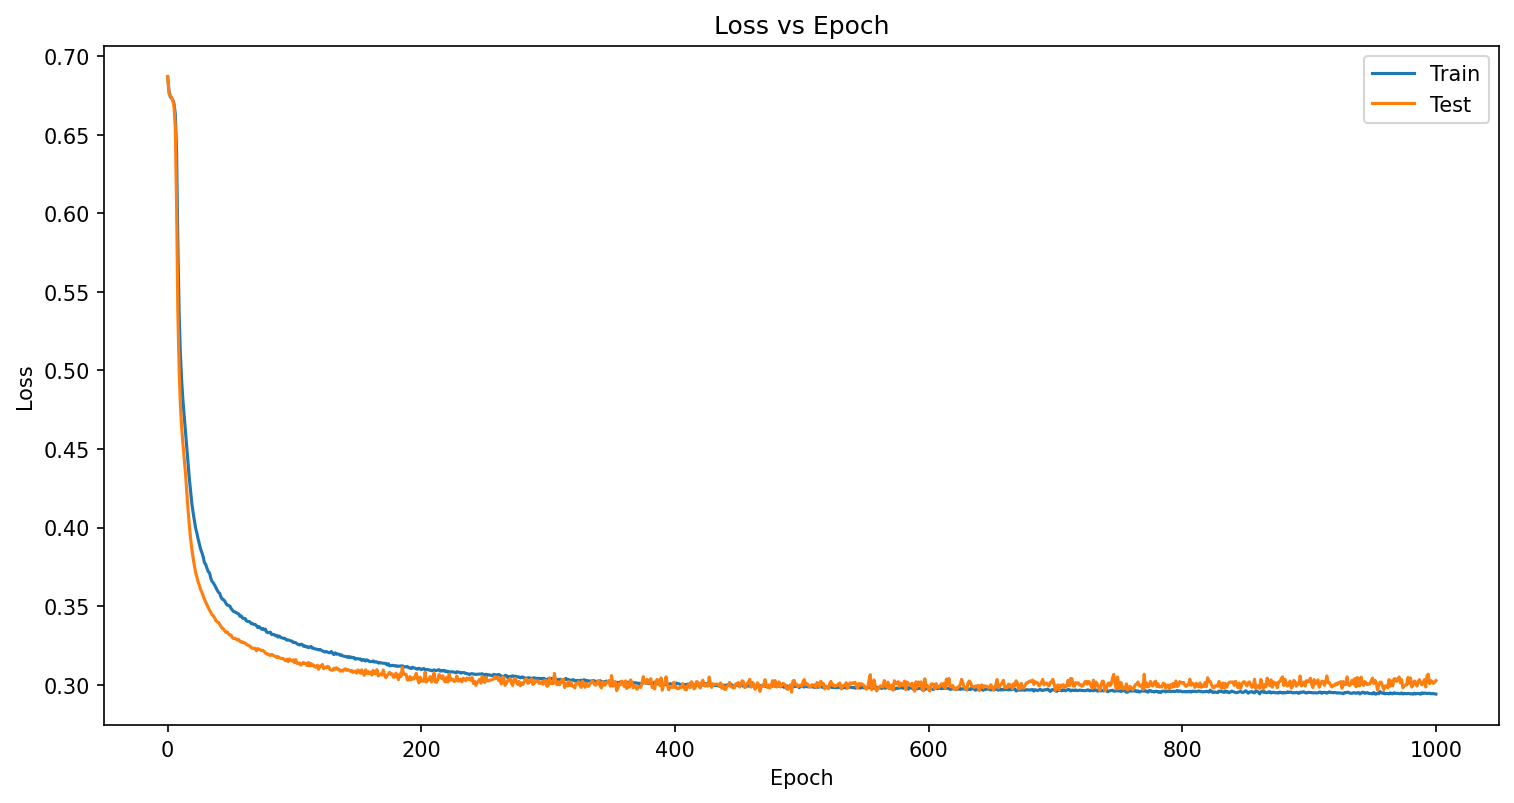

16609.08132768108


In [10]:
all_model.train()
all_before = timer()
train_nn(all_data, all_model, loss, optimizer, device, 1000) 
all_after = timer()
all_duration = all_after - all_before
print(all_duration)

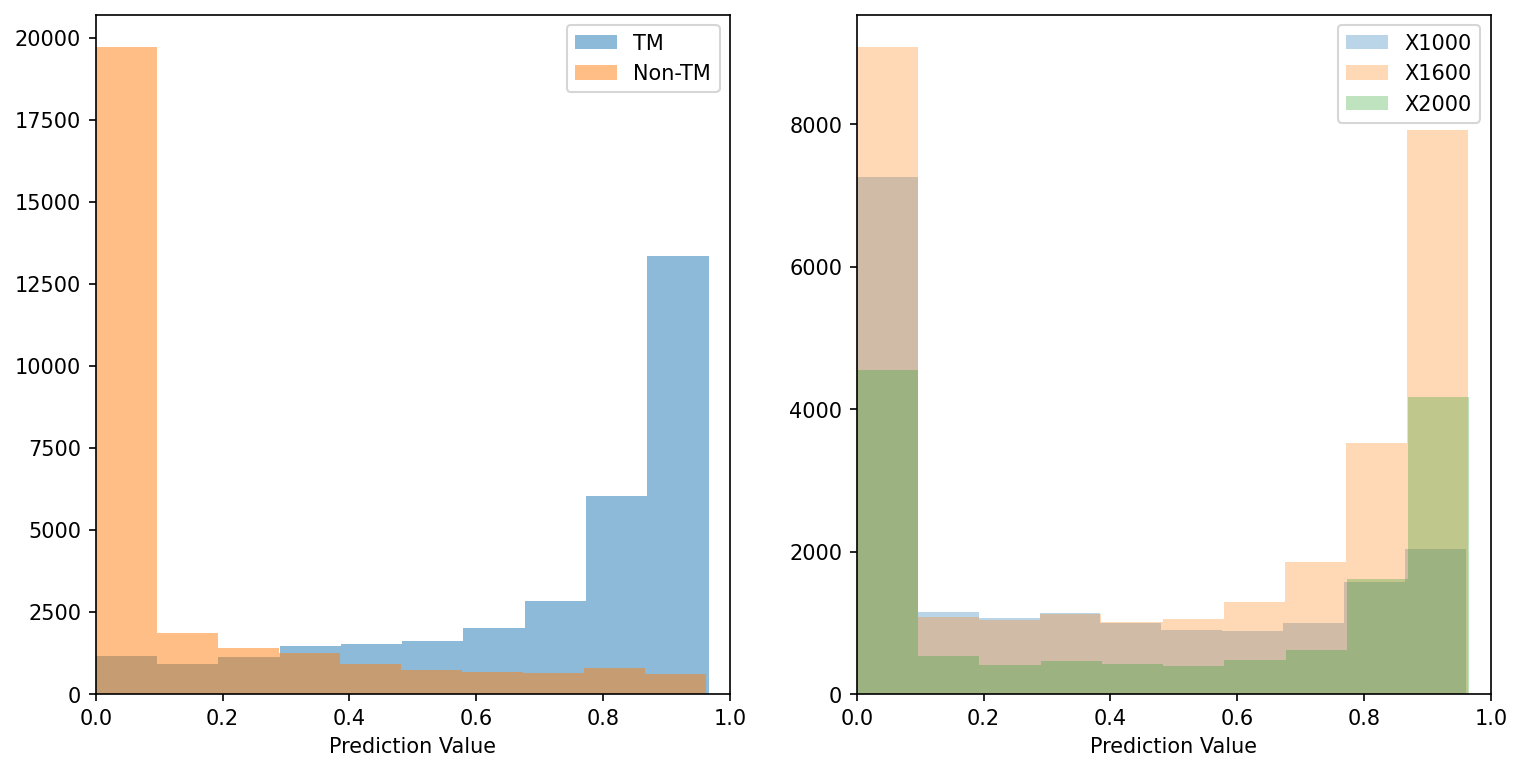

In [13]:
plot_predictions(sample_id_dict, signal_data.test_dataloader, all_model, device)

In [14]:
plt.rcParams['figure.figsize'] = [12,6] 
plt.rcParams['figure.dpi'] = 150

vals = all_data.test_df(all_model).max_signal_vals
plt.hist(vals['DiHiggsM'][vals['SampleID'] == 0], bins=50, alpha=0.5, range=(0, 3000), label='1 TeV', density=True)
plt.hist(vals['DiHiggsM'][vals['SampleID'] == 1], bins=50, alpha=0.5, range=(0, 3000), label='1.6 TeV', density=True)
plt.hist(vals['DiHiggsM'][vals['SampleID'] == 2], bins=50, alpha=0.5, range=(0, 3000), label='2 TeV', density=True)
plt.hist(vals['DiHiggsM'][vals['SampleID'] == 3], bins=50, alpha=0.5, range=(0, 3000), label='ttbar', density=True)
plt.hist(vals['DiHiggsM'][vals['SampleID'] == 4], bins=50, alpha=0.5, range=(0, 3000), label='Z+jets', density=True)
plt.title('Di-Higgs Mass Per Event')
plt.text(2000, 0.001, 'Trained on all\nEvaluated on all')
plt.legend()
plt.xlabel('NN Output')
plt.ylabel('AU')
plt.show()

TypeError: test_df() missing 1 required positional argument: 'device'

In [11]:
all_model.eval()
all_loss, all_acc = test_loop(all_data.train_dataloader, all_model, loss, device, train_mode=0)
print(f'Loss: {all_loss}')
print(f'Accuracy: {all_acc}')

Loss: 0.2888519653779958
Accuracy: 0.8721076335370505


In [ ]:
all_model.eval()
plot_best_system_pred(all_data.df(all_model, 'cpu'))

In [ ]:
final_loss, final_acc = test_loop(all_data.test_dataloader, all_model, loss)
print(f'Final loss: {final_loss:.3f}')
print(f'Final accuracy: {final_acc:.3f}')

In [ ]:
df = all_data.df(all_model, device)
print('Total systems')
print(len(df.all_vals))
print('Sytems kept (unique events)')
print(len(df.max_vals))
print('Systems discarded (multi-system events)')
print(len(df.nonmax_vals))
print('True systems discarded')
print(len(df.nonmax_signal_vals))
print('False systems discarded')
print(len(df.nonmax_background_vals))
print('True systems kept')
print(len(df.max_signal_vals))
print('False systems kept')
print(len(df.max_background_vals))
print('')
print('"Kept" = Max system per event')
print('"Discarded" = Non-max system per event')

## V2

In [23]:
version = 2`
model_path = f'../trained_models/all_trained_dnn_v{version}'
scaler_path = f'../trained_models/all_trained_dnn_v{version}_scaler.gz'

### Create  model

In [24]:
network = model_dict[version]
all_model = network(branch_names).to(device)

### Save model

In [13]:
torch.save(all_model.state_dict(), model_path)
joblib.dump(all_scaler, scaler_path)

['../trained_models/all_trained_dnn_v2_scaler.gz']

### Load model

In [10]:
all_model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
all_model.eval()

NeuralNetworkV2(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=19, out_features=38, bias=True)
    (1): ReLU()
    (2): Linear(in_features=38, out_features=57, bias=True)
    (3): ReLU()
    (4): Linear(in_features=57, out_features=57, bias=True)
    (5): ReLU()
    (6): Linear(in_features=57, out_features=57, bias=True)
    (7): ReLU()
    (8): Linear(in_features=57, out_features=57, bias=True)
    (9): Dropout(p=0.2, inplace=False)
    (10): ReLU()
    (11): Linear(in_features=57, out_features=38, bias=True)
    (12): ReLU()
    (13): Linear(in_features=38, out_features=1, bias=True)
  )
)

### Define loss and optimizer

In [25]:
learning_rate = 1e-3
loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(all_model.parameters(), lr=learning_rate)

### Train and test

100%|██████████| 1000/1000 [6:16:15<00:00, 22.58s/it] 


Done!


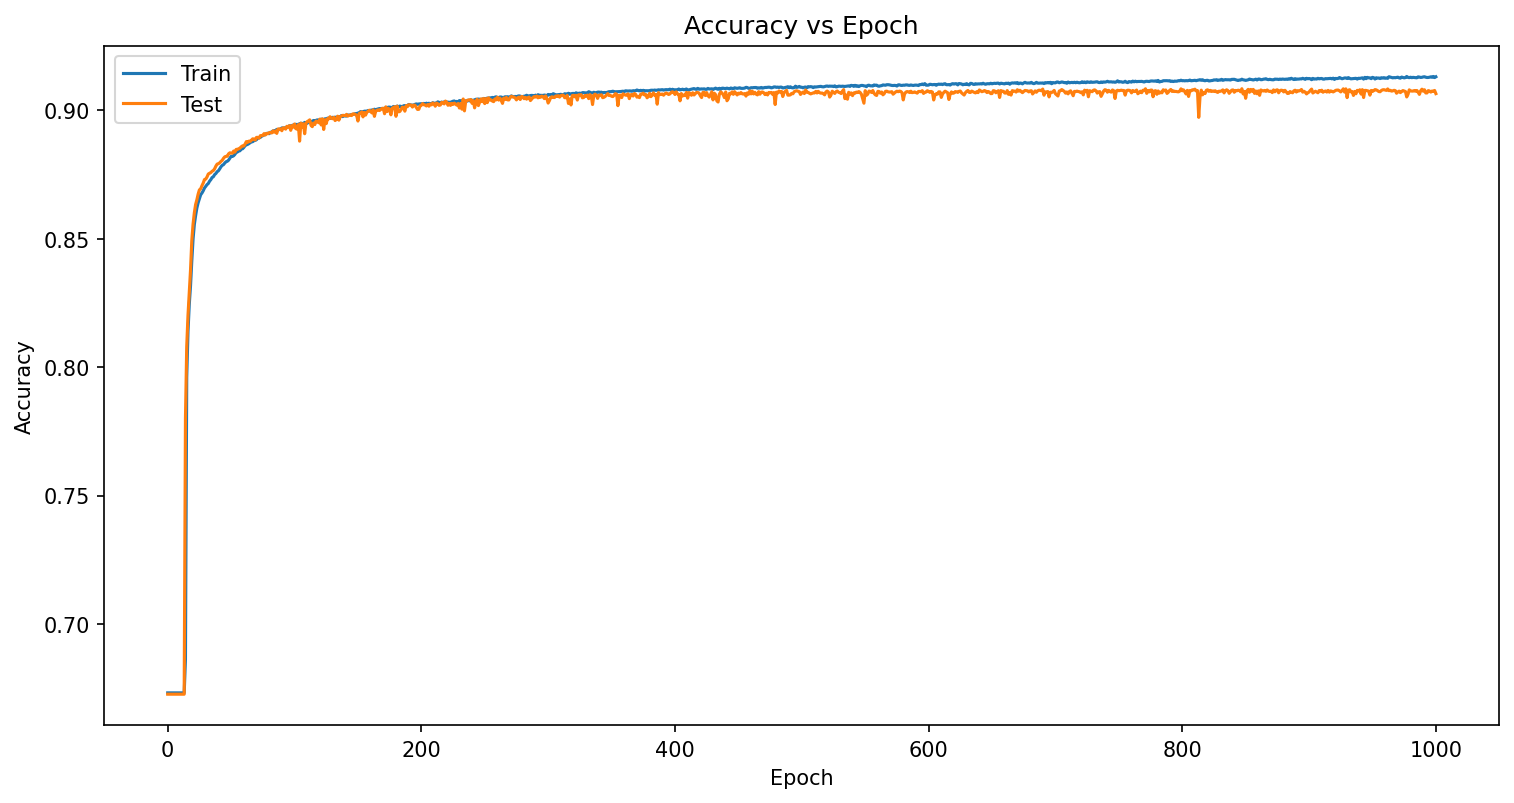

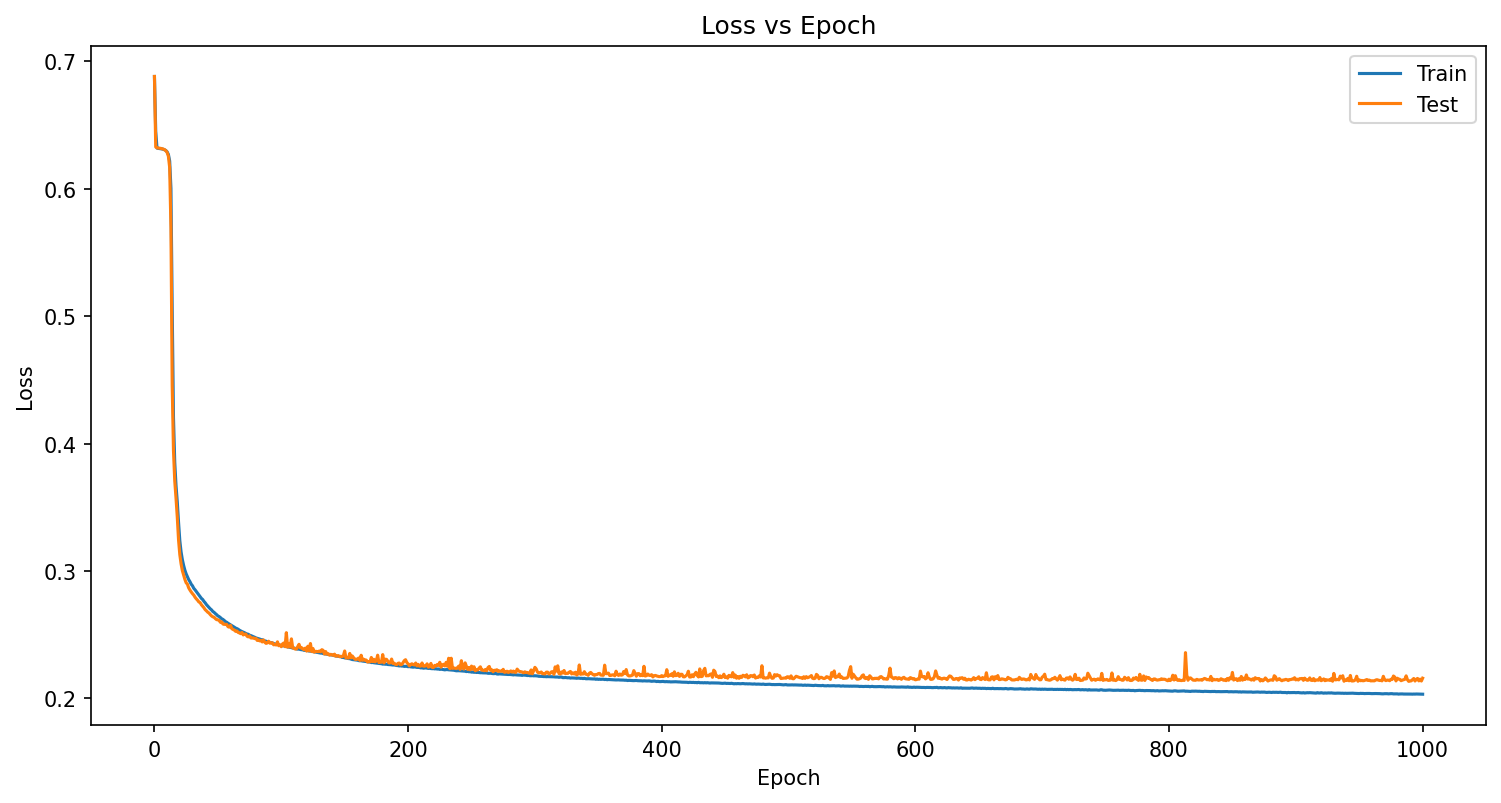

22586.70109744591


In [26]:
all_model.train()
all_before = timer()
train_nn(all_data, all_model, loss, optimizer, device, 1000) 
all_after = timer()
all_duration = all_after - all_before
print(all_duration)

In [27]:
all_model.eval()
all_loss, all_acc = test_loop(all_data.dataloader, all_model, loss, 'cpu', train_mode=0)
print(f'Loss: {all_loss}')
print(f'Accuracy: {all_acc}')

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_addmm)

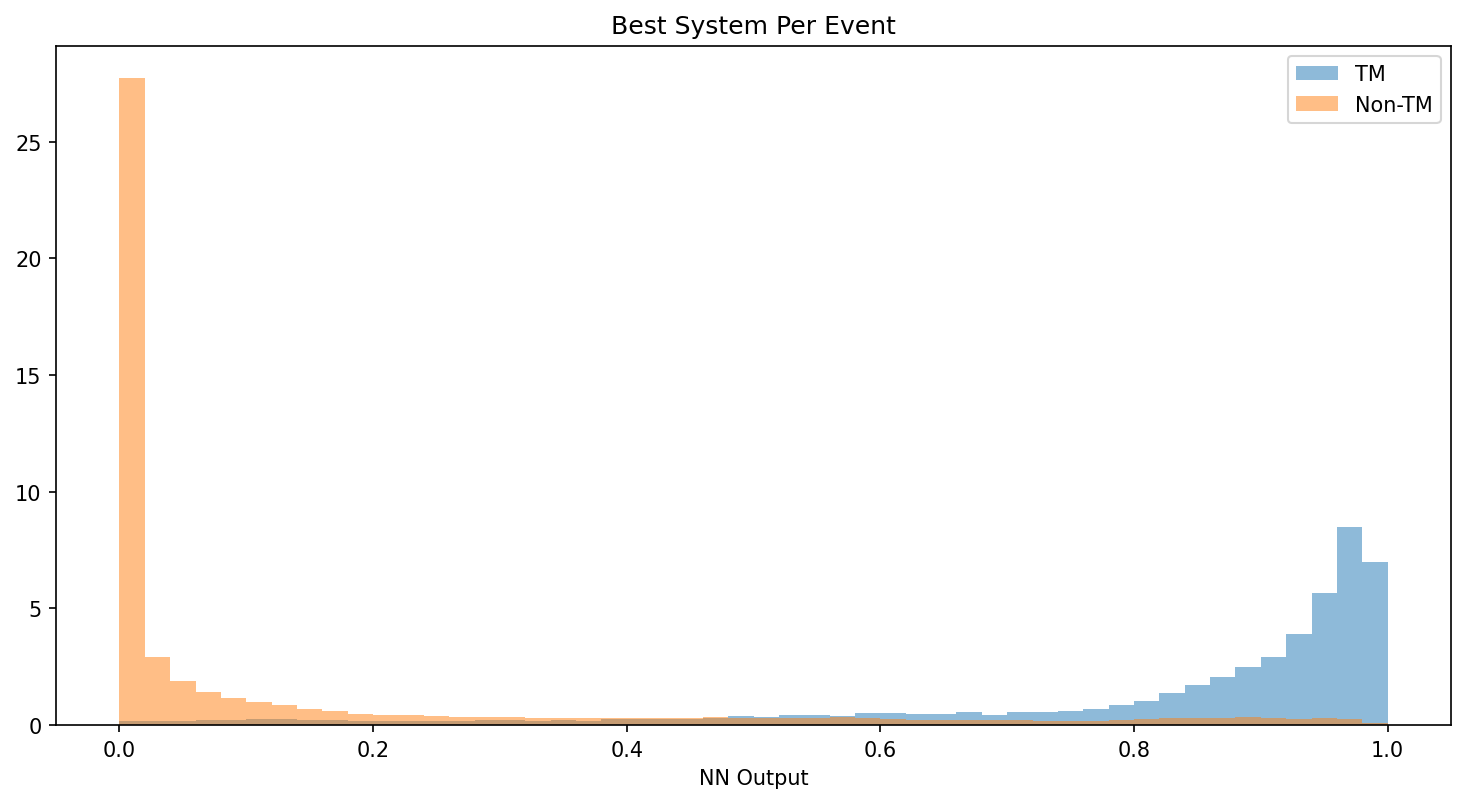

In [16]:
all_model.eval()
#plot_best_system_pred(all_data.train_df(all_model, 'cpu'))

plt.rcParams['figure.figsize'] = [12,6]
plt.rcParams['figure.dpi'] = 150

signal = all_data.test_df(all_model, 'cpu').max_signal_vals['Pred']
background = all_data.test_df(all_model, 'cpu').max_background_vals['Pred']
alpha=0.5
nbins = 50
xrange = [0, 1]
plt.hist(signal, nbins, xrange, label='TM', alpha=alpha, density=True)
plt.hist(background, nbins, xrange, label='Non-TM', alpha=alpha, density=True)
plt.title('Best System Per Event')
plt.xlabel('NN Output')
plt.legend()
plt.show()

## V2 - no ditau

In [17]:
version = 2
model_path = f'../trained_models/all_trained_dnn_v{version}_noditau'
scaler_path = f'../trained_models/all_trained_dnn_v{version}_noditau_scaler.gz'

In [18]:
noditau_branch_names = copy.deepcopy(branch_names)
noditau_branch_names.input_branch_names = ['LeptonPt',
                                          'LeptonEta',
                                          'LeptonPhi',
                                          'LeptonE',
                                          'TauPt',
                                          'TauEta',
                                          'TauPhi',
                                          'TauE',
                                          'LargeRJetPt',
                                          'LargeRJetEta',
                                          'LargeRJetPhi',
                                          'LargeRJetE',
                                          'LargeRJetM',
                                          'IsElectron'
                                          ]

all_noditau_data = SampleData(samples, sample_names, noditau_branch_names)
all_noditau_data.prepare_training_data()
all_noditau_data.prepare_full_data()
all_noditau_scaler = all_noditau_data.scaler

### Create  model

In [19]:
network = model_dict[version]
all_noditau_model = network(noditau_branch_names).to(device)

### Save model

In [22]:
torch.save(all_noditau_model.state_dict(), model_path)
joblib.dump(all_noditau_scaler, scaler_path)

['../trained_models/all_trained_dnn_v2_noditau_scaler.gz']

### Load model

In [13]:
all_model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
all_model.eval()

NameError: name 'all_model' is not defined

### Define loss and optimizer

In [20]:
learning_rate = 1e-3
loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(all_noditau_model.parameters(), lr=learning_rate)

### Train and test

100%|██████████| 1000/1000 [6:13:45<00:00, 22.43s/it] 


Done!


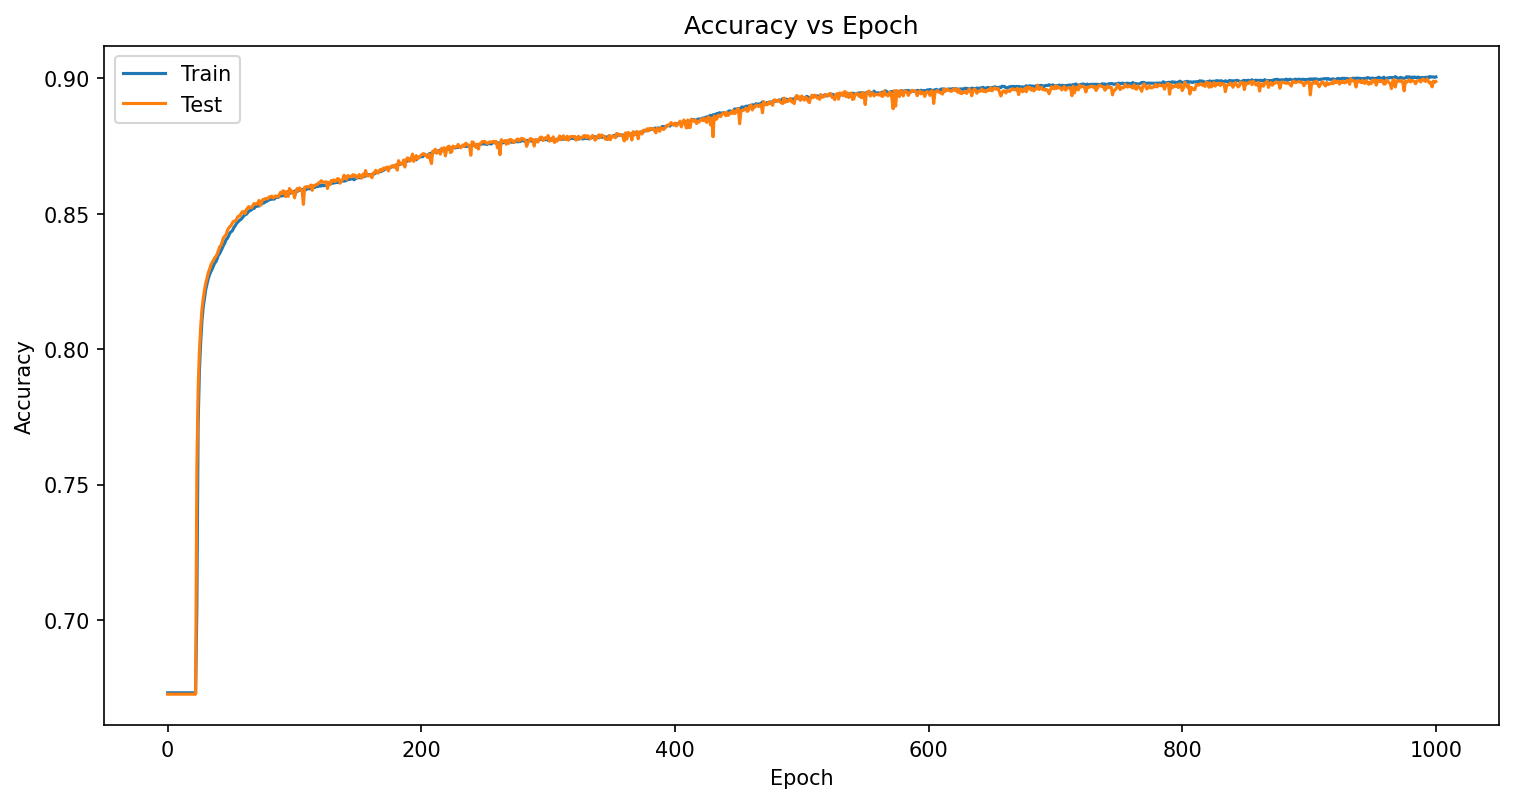

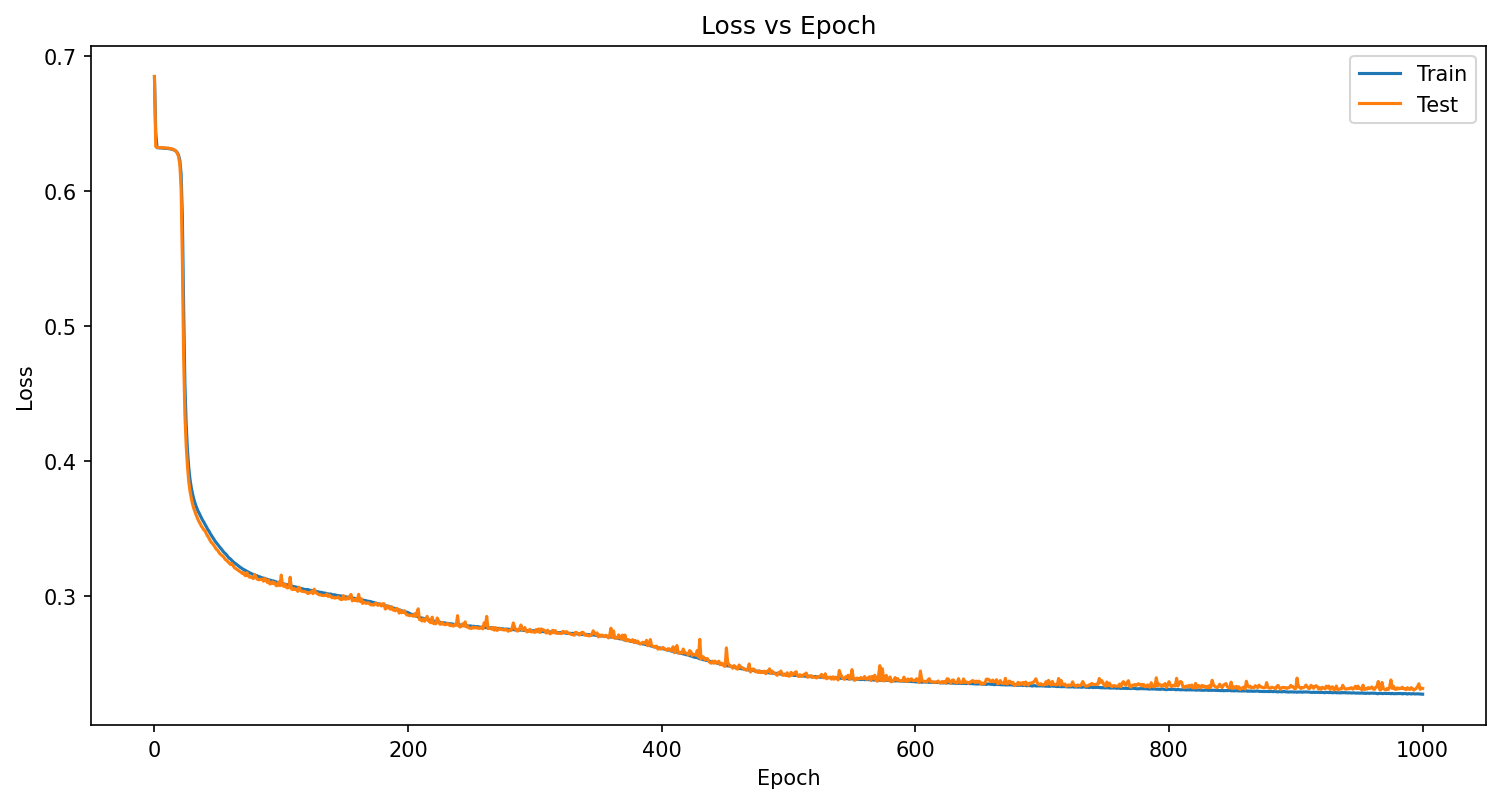

22436.818905879976


In [21]:
all_noditau_model.train()
all_before = timer()
train_nn(all_noditau_data, all_noditau_model, loss, optimizer, device, 1000) 
all_after = timer()
all_duration = all_after - all_before
print(all_duration)

## V2 Even

In [11]:
version = 2
events = 'even'
model_path = f'../trained_models/all_trained_dnn_v{version}{events}'
scaler_path = f'../trained_models/all_trained_dnn_v{version}{events}_scaler.gz'

### Create  model

In [12]:
network = model_dict[version]
even_model = network(branch_names).to(device)

### Save model

In [8]:
torch.save(even_model.state_dict(), model_path)
joblib.dump(even_scaler, scaler_path)

NameError: name 'even_model' is not defined

### Load model

In [13]:
even_model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
even_model.eval()

NeuralNetworkV2(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=19, out_features=38, bias=True)
    (1): ReLU()
    (2): Linear(in_features=38, out_features=57, bias=True)
    (3): ReLU()
    (4): Linear(in_features=57, out_features=57, bias=True)
    (5): ReLU()
    (6): Linear(in_features=57, out_features=57, bias=True)
    (7): ReLU()
    (8): Linear(in_features=57, out_features=57, bias=True)
    (9): Dropout(p=0.2, inplace=False)
    (10): ReLU()
    (11): Linear(in_features=57, out_features=38, bias=True)
    (12): ReLU()
    (13): Linear(in_features=38, out_features=1, bias=True)
  )
)

### Define loss and optimizer

In [10]:
learning_rate = 1e-3
loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(even_model.parameters(), lr=learning_rate)

### Train and test

100%|██████████| 1500/1500 [3:27:35<00:00,  8.30s/it]  


Done!


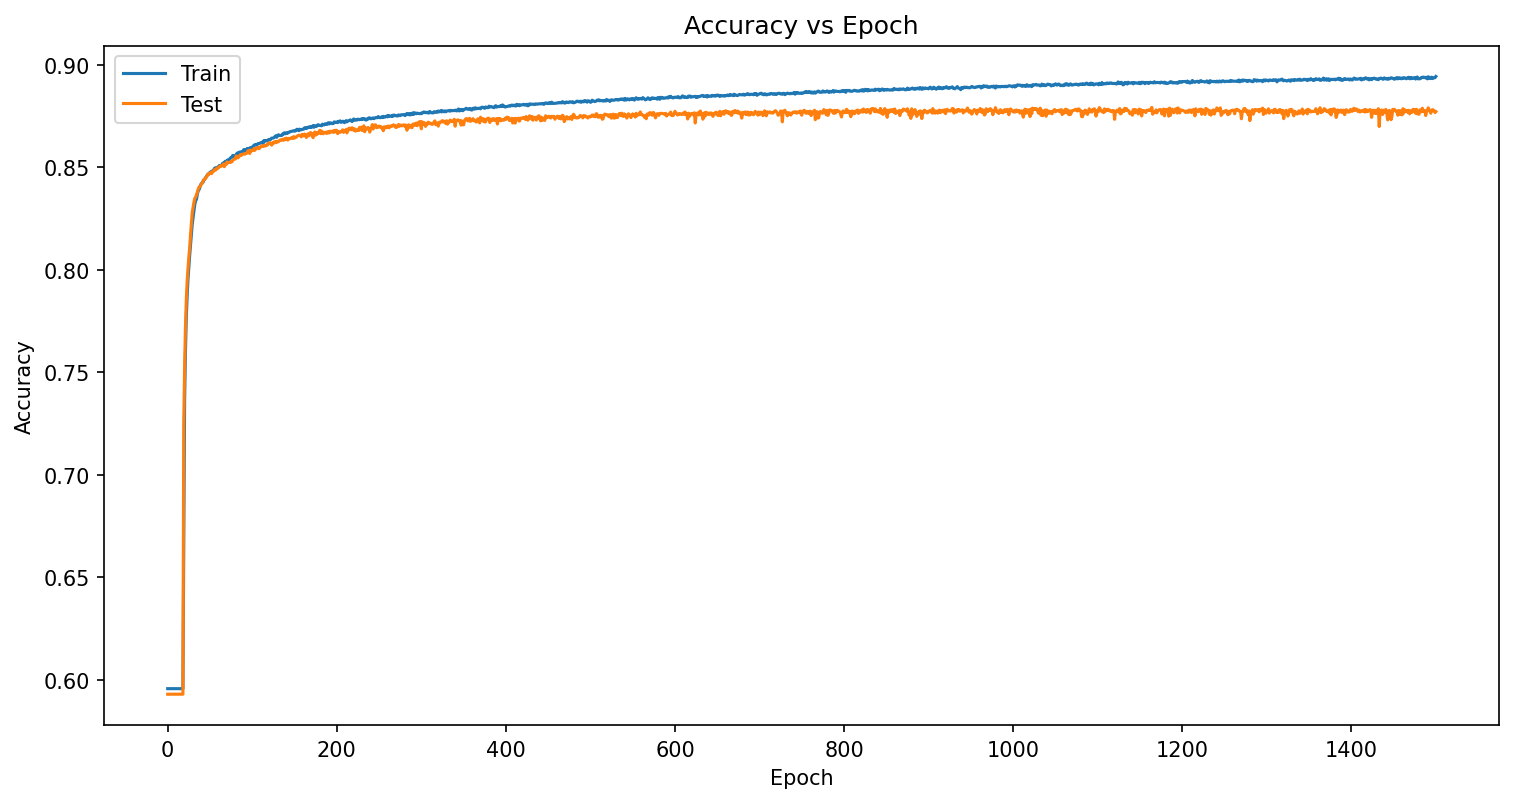

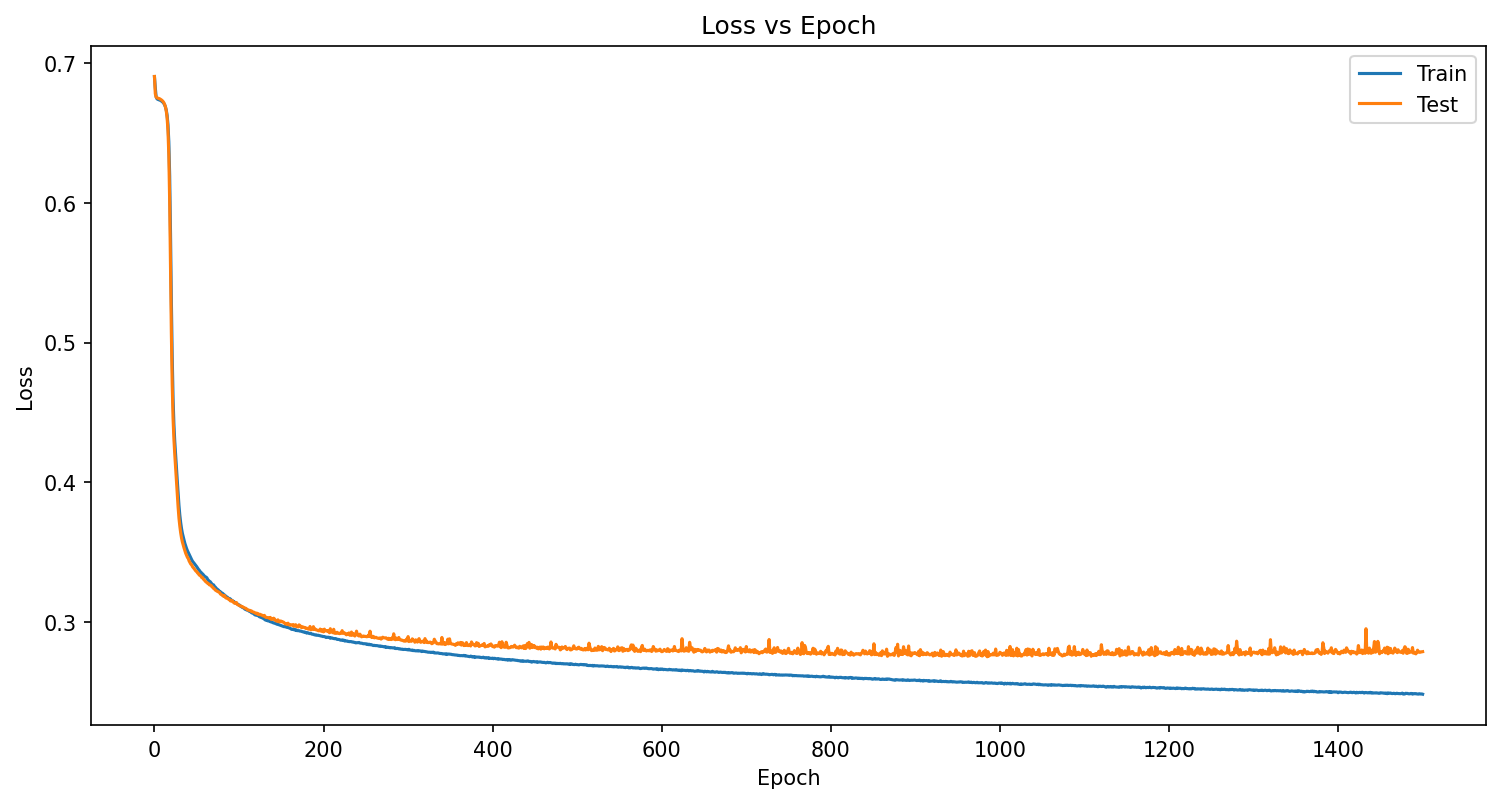

12462.060367046855


In [11]:
even_model.train()
even_before = timer()
train_nn(even_data, even_model, loss, optimizer, device, 1500) 
even_after = timer()
even_duration = even_after - even_before
print(even_duration)

In [15]:
even_model.eval()
even_loss, even_acc = test_loop(even_data.dataloader, even_model, loss, device, train_mode=0)
print(f'Loss: {even_loss}')
print(f'Accuracy: {even_acc}')

Loss: 0.2516709459056515
Accuracy: 0.8915368984336598


## V2 Odd

In [14]:
version = 2
events = 'odd'
model_path = f'../trained_models/all_trained_dnn_v{version}{events}'
scaler_path = f'../trained_models/all_trained_dnn_v{version}{events}_scaler.gz'

### Create  model

In [15]:
network = model_dict[version]
odd_model = network(branch_names).to(device)

### Save model

In [12]:
torch.save(odd_model.state_dict(), model_path)
joblib.dump(odd_scaler, scaler_path)

['../trained_models/all_trained_dnn_v2odd_scaler.gz']

### Load model

In [16]:
odd_model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
odd_model.eval()

NeuralNetworkV2(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=19, out_features=38, bias=True)
    (1): ReLU()
    (2): Linear(in_features=38, out_features=57, bias=True)
    (3): ReLU()
    (4): Linear(in_features=57, out_features=57, bias=True)
    (5): ReLU()
    (6): Linear(in_features=57, out_features=57, bias=True)
    (7): ReLU()
    (8): Linear(in_features=57, out_features=57, bias=True)
    (9): Dropout(p=0.2, inplace=False)
    (10): ReLU()
    (11): Linear(in_features=57, out_features=38, bias=True)
    (12): ReLU()
    (13): Linear(in_features=38, out_features=1, bias=True)
  )
)

### Define loss and optimizer

In [21]:
learning_rate = 1e-3
loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(odd_model.parameters(), lr=learning_rate)

### Train and test

100%|██████████| 1500/1500 [3:28:59<00:00,  8.36s/it]  


Done!


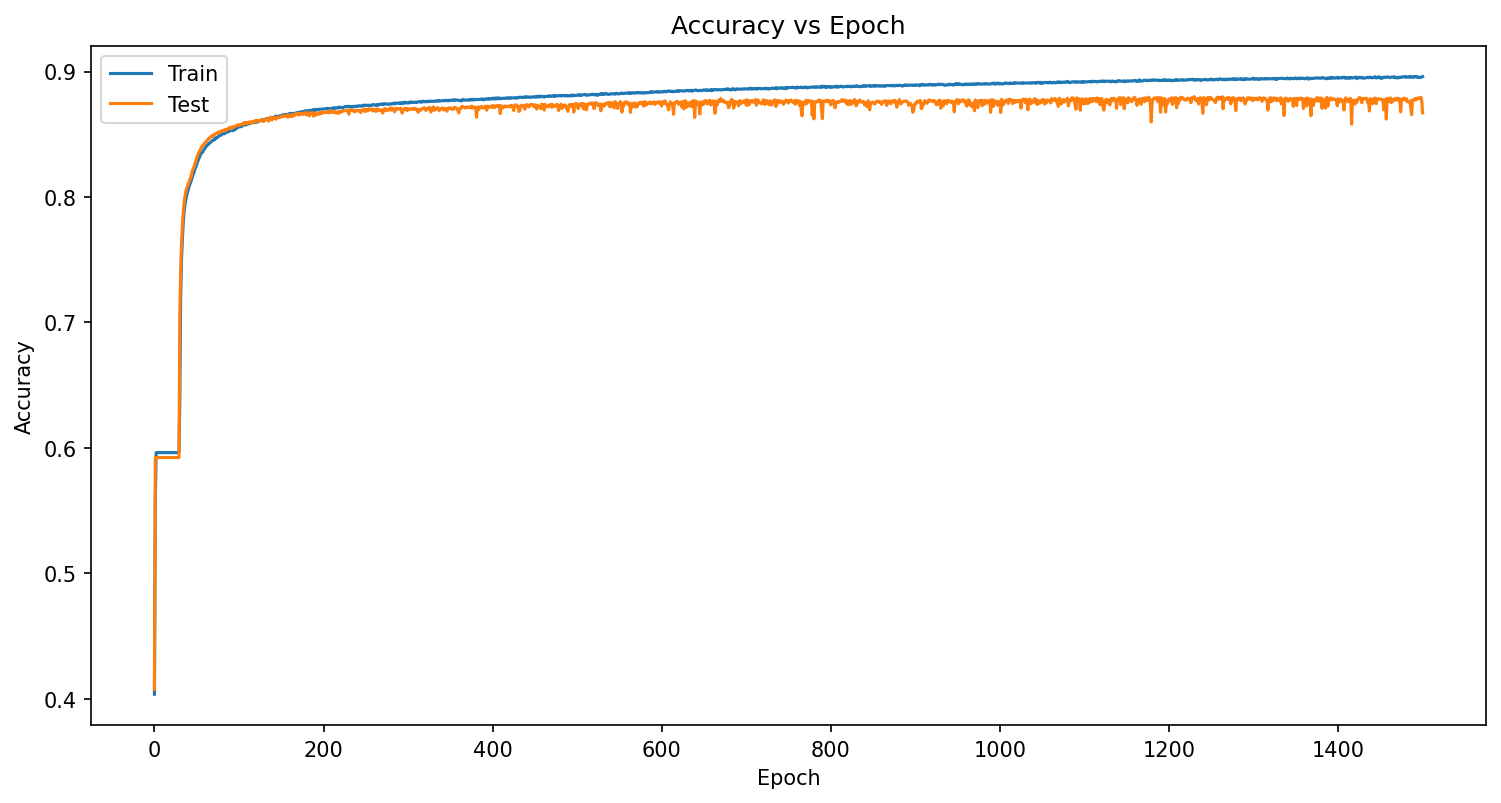

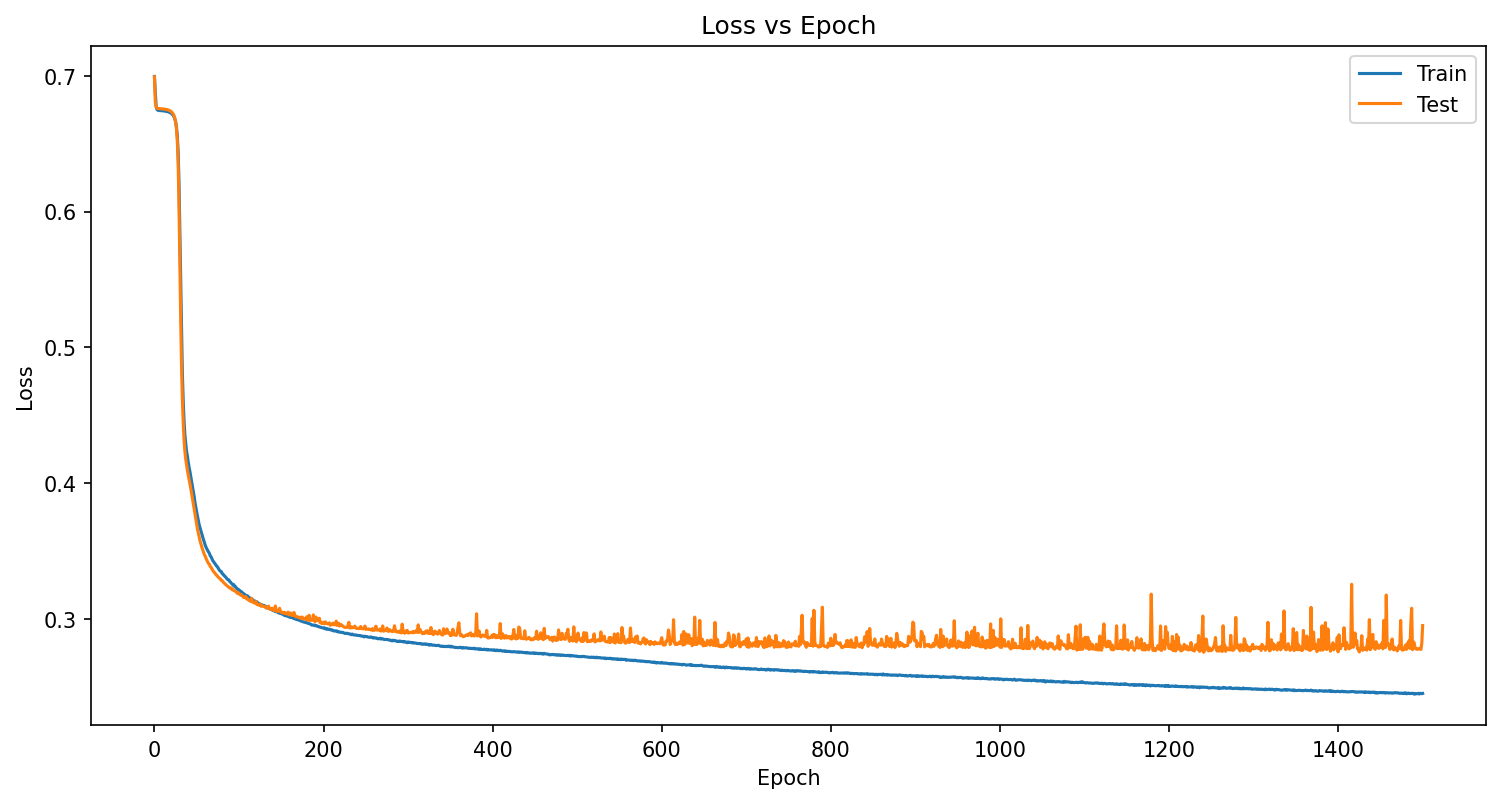

12545.636457970366


In [11]:
odd_model.train()
odd_before = timer()
train_nn(odd_data, odd_model, loss, optimizer, device, 1500) 
odd_after = timer()
odd_duration = odd_after - odd_before
print(odd_duration)

In [11]:
odd_model.eval()
odd_loss, odd_acc = test_loop(odd_data.dataloader, odd_model, loss, 'cpu', train_mode=0)
print(f'Loss: {odd_loss}')
print(f'Accuracy: {odd_acc}')

Loss: 0.2705504316981361
Accuracy: 0.8784037487412265


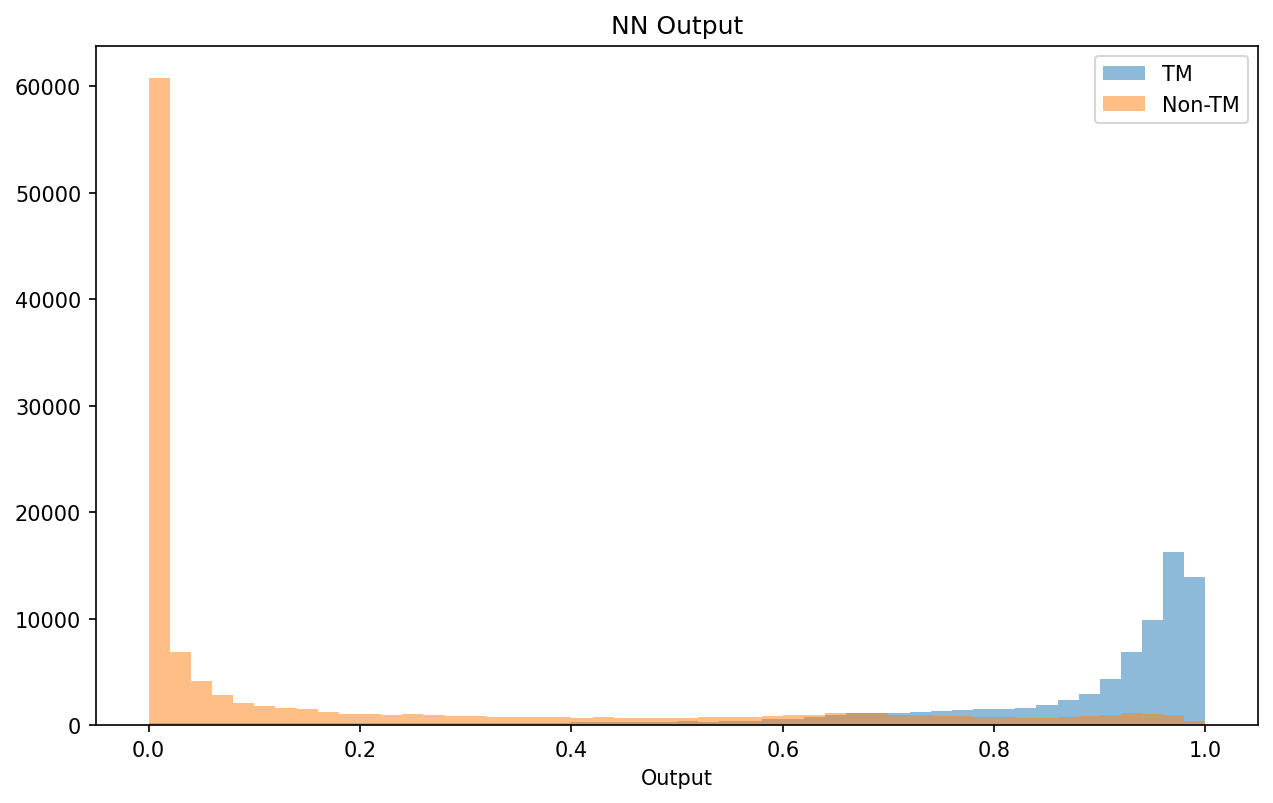

In [11]:
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams['figure.dpi'] = 150

signal = even_data.df(odd_model, 'cpu').signal_vals['Pred']
background = even_data.df(odd_model, 'cpu').background_vals['Pred']
alpha=0.5
nbins = 50
xrange = [0, 1]
plt.hist(signal, nbins, xrange, label='TM', alpha=alpha)
plt.hist(background, nbins, xrange, label='Non-TM', alpha=alpha)
plt.title('NN Output')
plt.xlabel('Output')
plt.legend()
plt.show()

In [16]:
print(len(np.arange(0, 1, 1/50)))

50


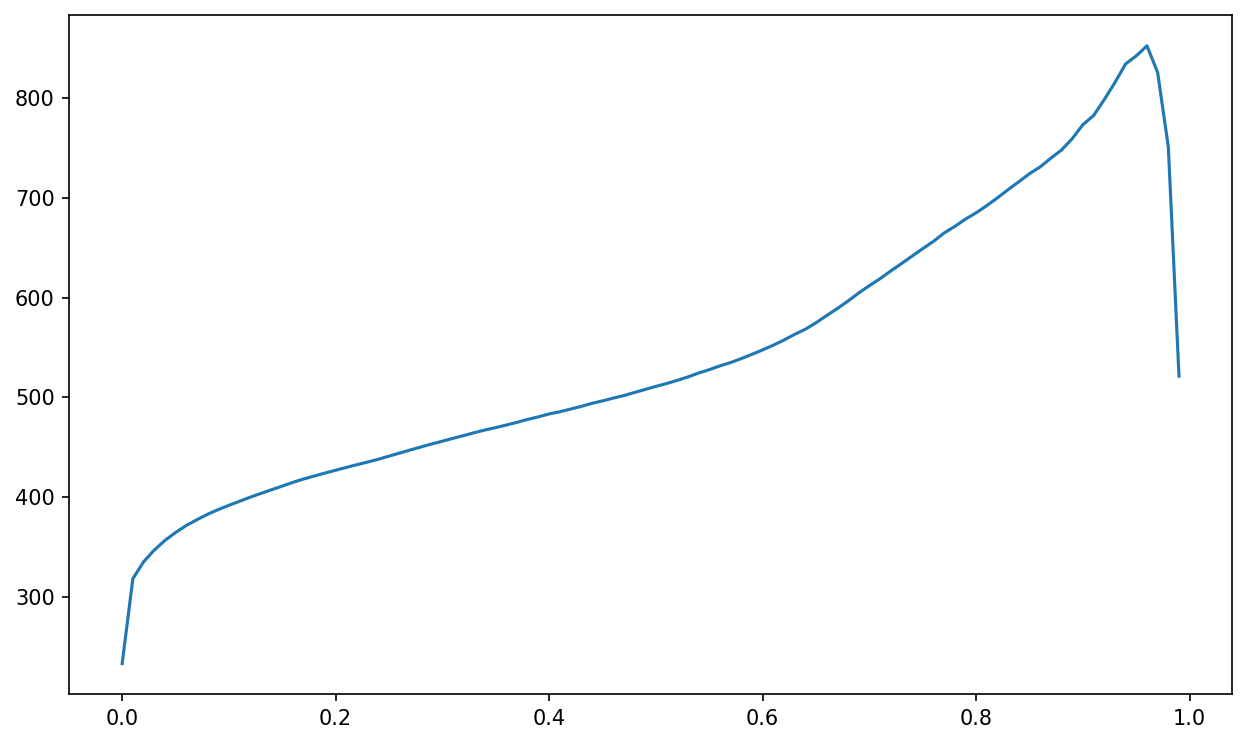

852.2885095067575


In [25]:
signal = even_data.df(odd_model, 'cpu').signal_vals['Pred']
background = even_data.df(odd_model, 'cpu').background_vals['Pred']
nbins = 100
xrange = [0, 1]

sens = []
for i in np.arange(0, 1, 1/nbins):
    pass_signal = [val for val in signal if val > i]
    npass_signal = len(pass_signal)
    pass_background = [val for val in background if val > i]
    npass_background = len(pass_background)
    bin_sens = npass_signal / math.sqrt(npass_background)
    sens.append(bin_sens)
plt.plot(np.arange(0, 1, 1/nbins), sens)
plt.show()
print(max(sens))

## V2 Performance

159832
329001


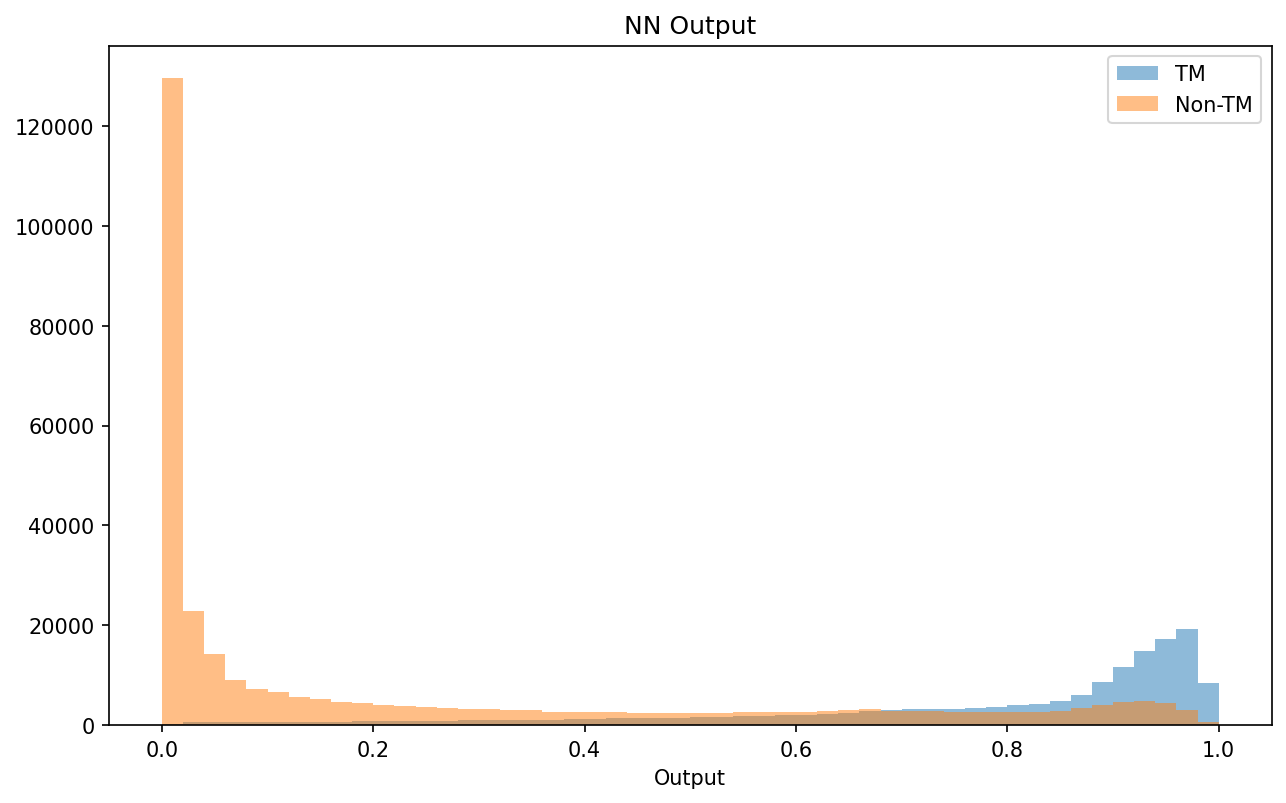

In [23]:
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams['figure.dpi'] = 150

signal = np.concatenate([even_data.df(odd_model, 'cpu').signal_vals['Pred'], odd_data.df(even_model, 'cpu').signal_vals['Pred']])
print(len(signal))
background = np.concatenate([even_data.df(odd_model, 'cpu').background_vals['Pred'], odd_data.df(even_model, 'cpu').background_vals['Pred']])
print(len(background))
alpha=0.5
nbins = 50
xrange = [0, 1]
plt.hist(signal, nbins, xrange, label='TM', alpha=alpha)
plt.hist(background, nbins, xrange, label='Non-TM', alpha=alpha)
plt.title('NN Output')
plt.xlabel('Output')
plt.legend()
plt.show()

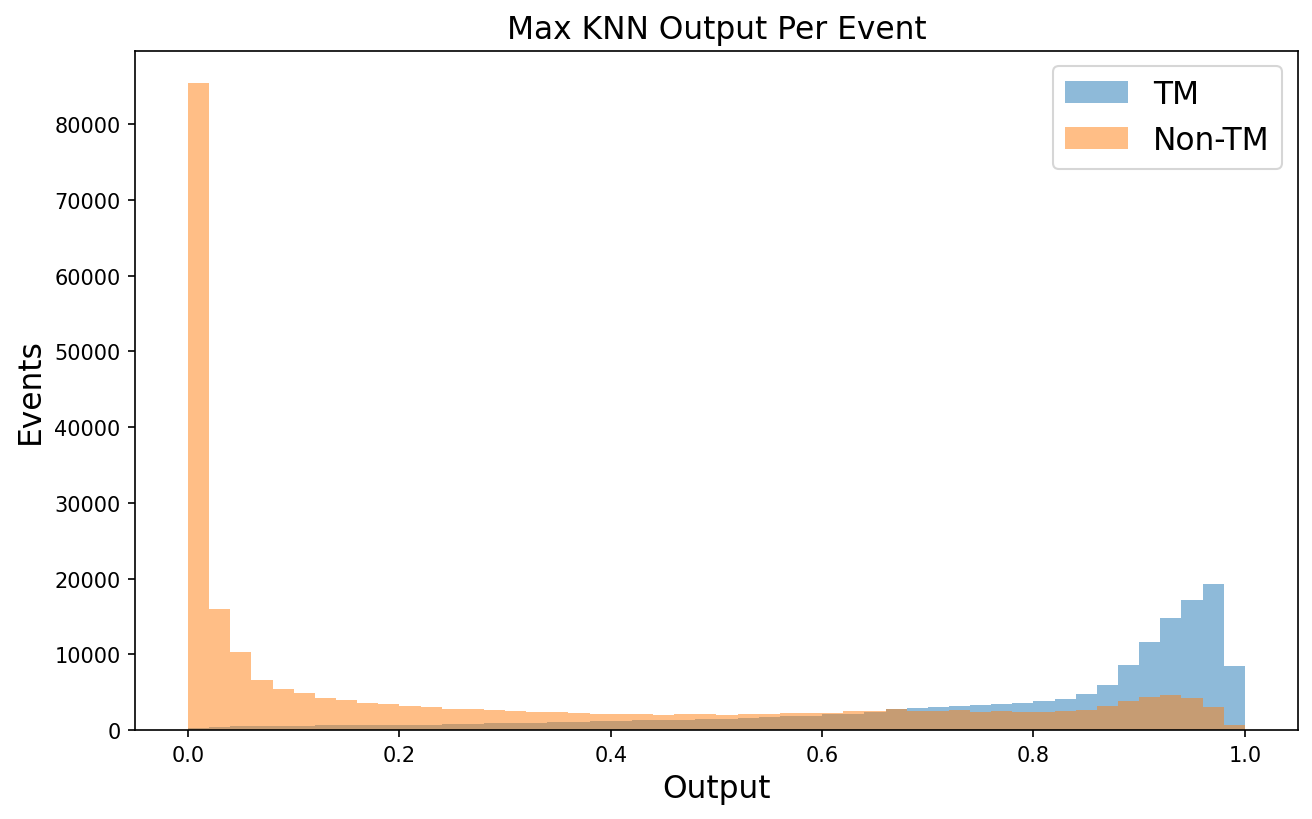

In [27]:
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams['figure.dpi'] = 150

signal = np.concatenate([even_data.df(odd_model, 'cpu').max_signal_vals['Pred'], odd_data.df(even_model, 'cpu').max_signal_vals['Pred']])
background = np.concatenate([even_data.df(odd_model, 'cpu').max_background_vals['Pred'], odd_data.df(even_model, 'cpu').max_background_vals['Pred']])
alpha=0.5
nbins = 50
xrange = [0, 1]
plt.hist(signal, nbins, xrange, label='TM', alpha=alpha)
plt.hist(background, nbins, xrange, label='Non-TM', alpha=alpha)
plt.title('Max KNN Output Per Event', fontsize=15)
plt.xlabel('Output', fontsize=15)
plt.ylabel('Events', fontsize=15)
plt.legend(fontsize=15)
plt.show()

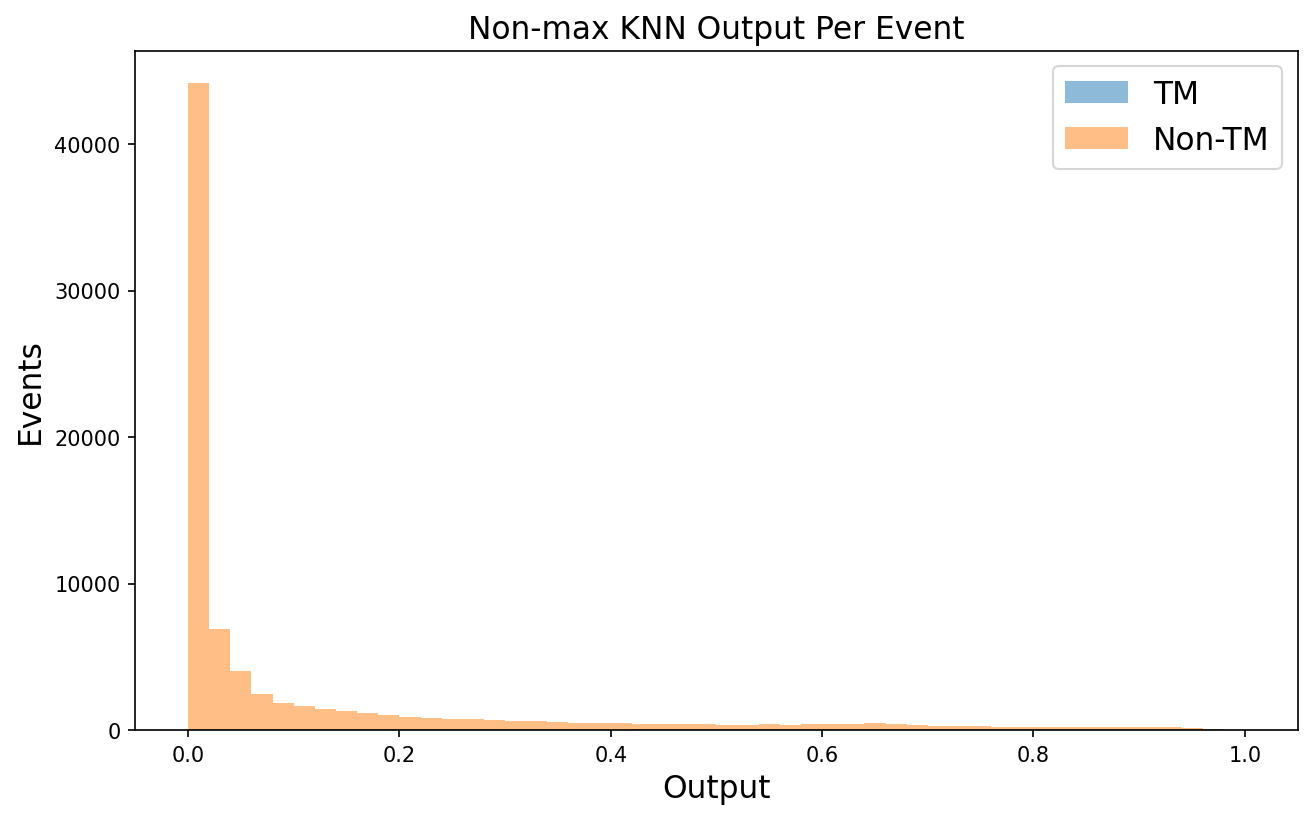

In [24]:
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams['figure.dpi'] = 150

signal = np.concatenate([even_data.df(odd_model, 'cpu').nonmax_signal_vals['Pred'], odd_data.df(even_model, 'cpu').nonmax_signal_vals['Pred']])
background = np.concatenate([even_data.df(odd_model, 'cpu').nonmax_background_vals['Pred'], odd_data.df(even_model, 'cpu').nonmax_background_vals['Pred']])
alpha=0.5
nbins = 50
xrange = [0, 1]
plt.hist(signal, nbins, xrange, label='TM', alpha=alpha)
plt.hist(background, nbins, xrange, label='Non-TM', alpha=alpha)
plt.title('Non-max KNN Output Per Event', fontsize=15)
plt.xlabel('Output', fontsize=15)
plt.ylabel('Events', fontsize=15)
plt.legend(fontsize=15)
plt.show()

In [19]:
even_df = even_data.df(odd_model, 'cpu')
odd_df = odd_data.df(even_model, 'cpu')
print('Total systems')
print(len(even_df.all_vals) + len(odd_df.all_vals))
#print(len(all_data.df(all_model, 'cpu').all_vals))
print('Sytems kept (unique events)')
print(len(even_df.max_vals) + len(odd_df.max_vals))
print('Systems discarded (multi-system events)')
print(len(even_df.nonmax_vals) + len(odd_df.nonmax_vals))
print('True systems discarded')
print(len(even_df.nonmax_signal_vals) + len(odd_df.nonmax_signal_vals))
print('False systems discarded')
print(len(even_df.nonmax_background_vals) + len(odd_df.nonmax_background_vals))
print('True systems kept')
print(len(even_df.max_signal_vals) + len(odd_df.max_signal_vals))
print('False systems kept')
print(len(even_df.max_background_vals) + len(odd_df.max_background_vals))
# print('')
# print('"Kept" = Max system per event')
# print('"Discarded" = Non-max system per event')

Total systems
394952
Sytems kept (unique events)
314514
Systems discarded (multi-system events)
80438
True systems discarded
1510
False systems discarded
78928
True systems kept
158322
False systems kept
156192


|                          |       |
|--------------------------|-------|
| TM Systems Discarded     | 0.9% |
| Non-TM Systems Discarded | 33.6% |
| TM Systems Kept          | 99.1% |
| Non-TM Systems Kept      | 66.4% |

In [ ]:
max_df = even_df.max_vals
max_df = max_df[max_df['SampleID'] < 3]

print(max_df['IsElectron'])
print(max_df['PDGTruthMatchType'])

print(len(max_df))
nonmax_df = even_df.nonmax_vals
nonmax_df = nonmax_df[nonmax_df['SampleID'] < 3]
print(len(nonmax_df))
max_signal_df = even_df.max_signal_vals
max_signal_df = max_signal_df[max_signal_df['SampleID'] < 3]
print(len(max_signal_df))

merge_df = pd.merge(max_df, nonmax_df, 'inner', on='UniqueEventID')
print(len(merge_df))

merge_signal_df = pd.merge(max_signal_df, nonmax_df, 'inner', on='UniqueEventID')
print(len(merge_signal_df))

# max_ids = even_df.max_signal_vals[branch_names.id_branch_name]
# nonmax_ids = even_df.nonmax_vals[branch_names.id_branch_name]
# print(max_ids)
# print(nonmax_ids)
# merge_ids = pd.merge(max_ids, nonmax_ids, 'inner', on='UniqueEventID')
# print(merge_ids)
# test_id = merge_ids['UniqueEventID'][0]
# print(test_id)
# print(max_ids[max_ids == test_id])
# print(nonmax_ids[nonmax_ids == test_id])
#even_df.nonmax_signal_vals[branch_names.id_branch_name] in ids

## V2 Odd Shortened

In [8]:
version = 2
events = 'odd_short'
model_path = f'../trained_models/all_trained_dnn_v{version}{events}'
scaler_path = f'../trained_models/all_trained_dnn_v{version}odd_scaler.gz'

### Create  model

In [9]:
network = model_dict[version]
odd_jzw_model = network(branch_names).to(device)

### Save model

In [18]:
torch.save(odd_jzw_model.state_dict(), model_path)
joblib.dump(odd_scaler, scaler_path)

['../trained_models/all_trained_dnn_v2odd_scaler.gz']

### Load model

In [23]:
odd_short_model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
odd_short_model.eval()

NeuralNetworkV2(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=19, out_features=38, bias=True)
    (1): ReLU()
    (2): Linear(in_features=38, out_features=57, bias=True)
    (3): ReLU()
    (4): Linear(in_features=57, out_features=57, bias=True)
    (5): ReLU()
    (6): Linear(in_features=57, out_features=57, bias=True)
    (7): ReLU()
    (8): Linear(in_features=57, out_features=57, bias=True)
    (9): Dropout(p=0.2, inplace=False)
    (10): ReLU()
    (11): Linear(in_features=57, out_features=38, bias=True)
    (12): ReLU()
    (13): Linear(in_features=38, out_features=1, bias=True)
  )
)

### Define loss and optimizer

In [10]:
learning_rate = 1e-3
loss = nn.BCEWithLogitsLoss()
#optimizer = torch.optim.SGD(odd_short_model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(odd_short_model.parameters(), lr=learning_rate, momentum=0.9)

### Train and test

100%|██████████| 150/150 [29:55<00:00, 11.97s/it]


Done!


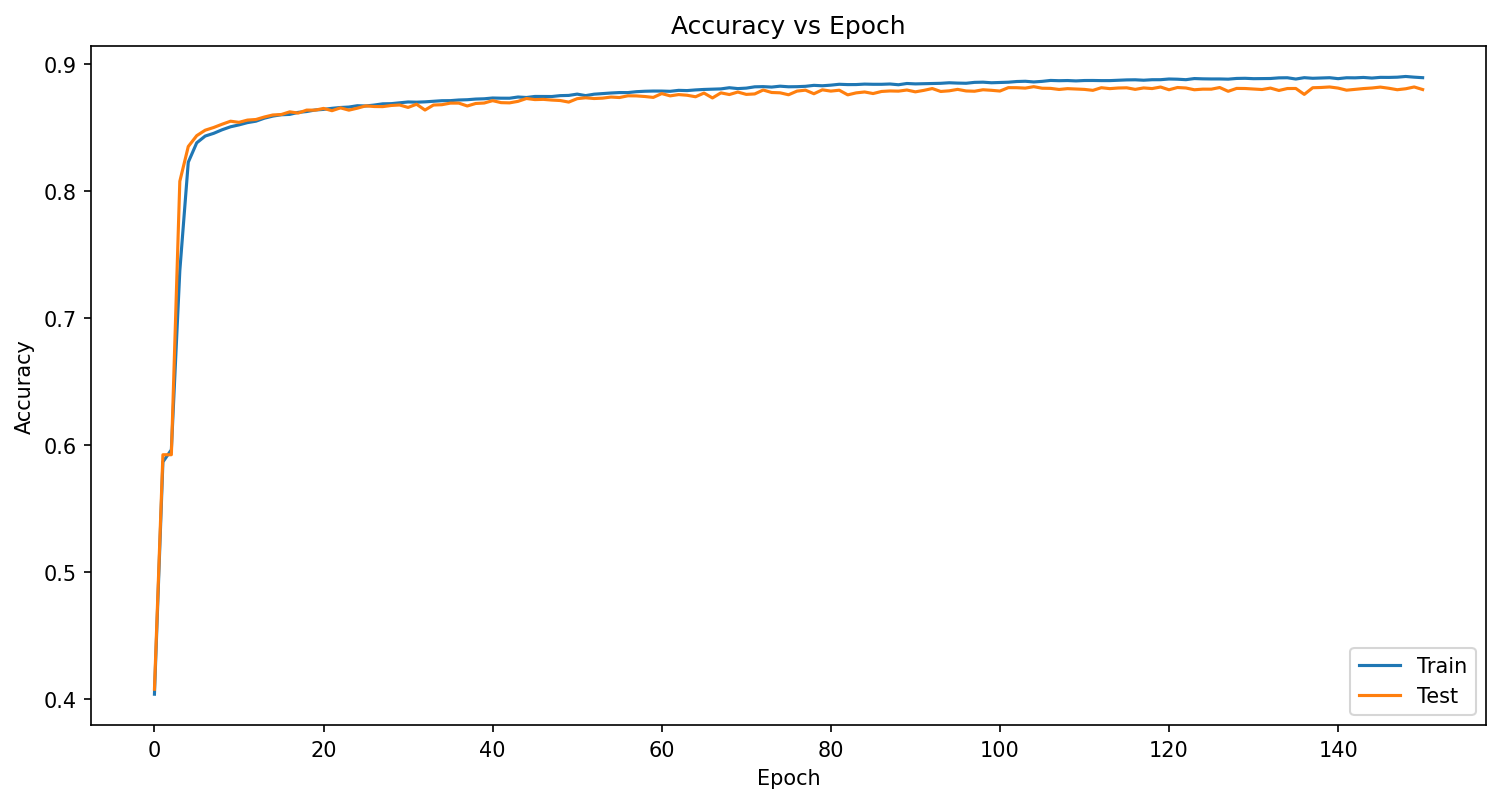

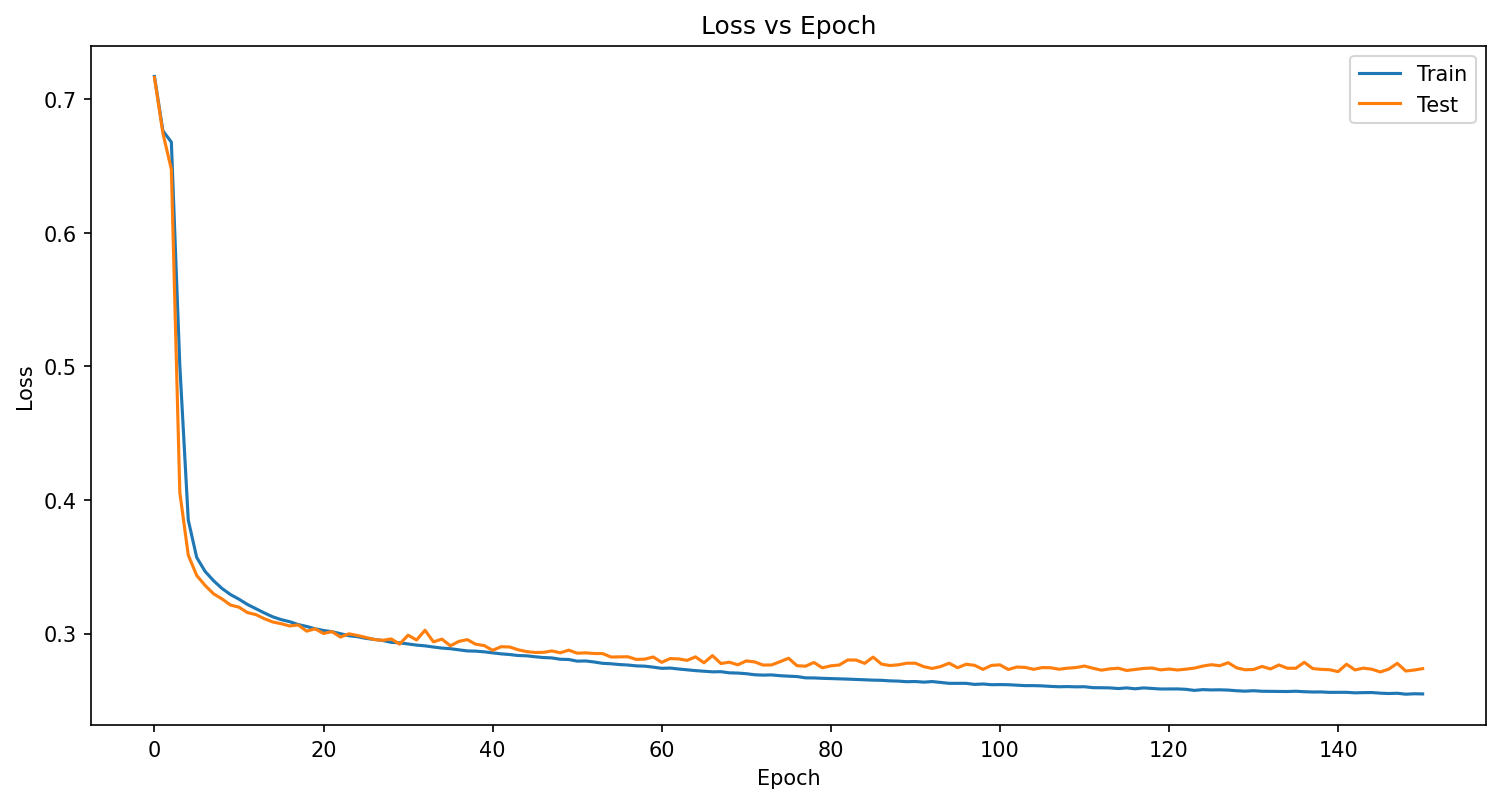

1802.5648723728955


In [11]:
odd_short_model.train()
odd_before = timer()
train_nn(odd_data, odd_short_model, loss, optimizer, device, 150) 
odd_after = timer()
odd_duration = odd_after - odd_before
print(odd_duration)

In [12]:
odd_short_model.eval()
odd_loss, odd_acc = test_loop(odd_data.dataloader, odd_short_model, loss, 'cpu', train_mode=0)
print(f'Loss: {odd_loss}')
print(f'Accuracy: {odd_acc}')

Loss: 0.25578329705999964
Accuracy: 0.888737077014164


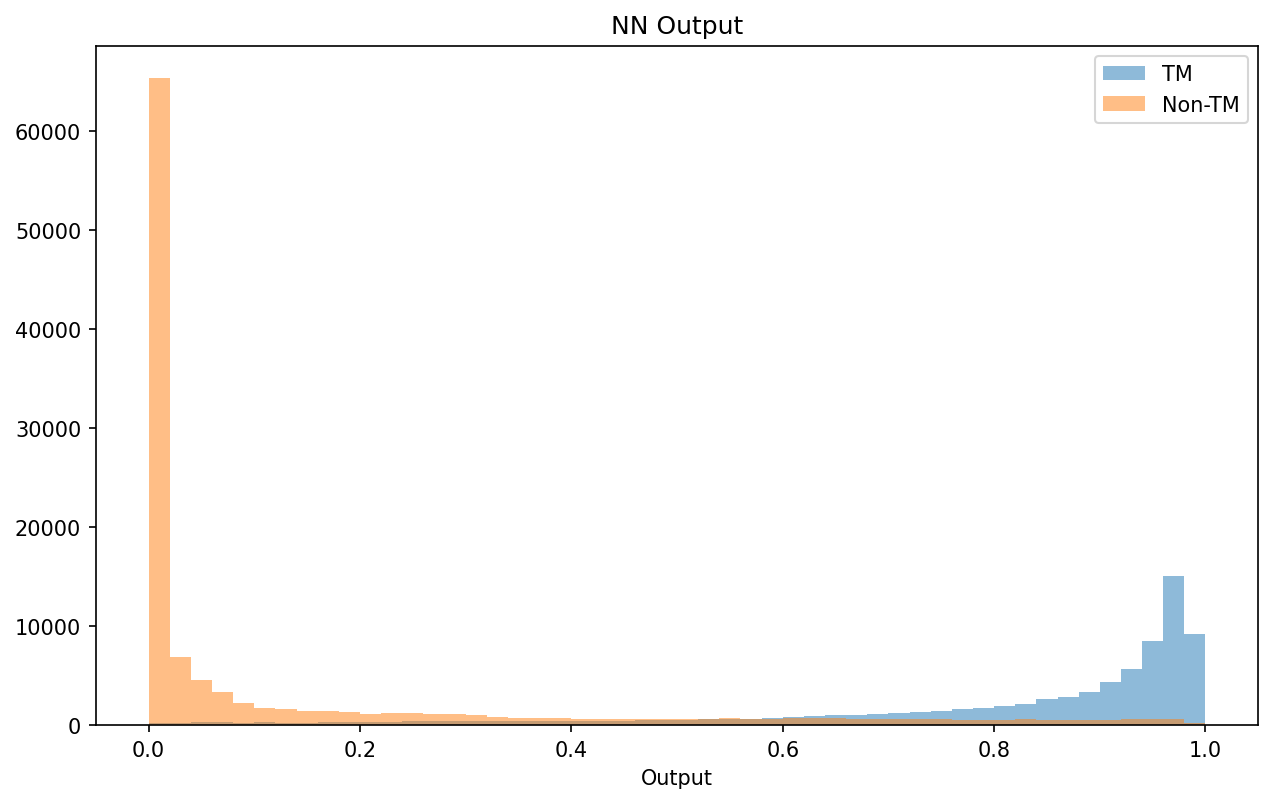

In [13]:
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams['figure.dpi'] = 150

signal = even_data.df(odd_short_model, 'cpu').signal_vals['Pred']
background = even_data.df(odd_short_model, 'cpu').background_vals['Pred']
alpha=0.5
nbins = 50
xrange = [0, 1]
plt.hist(signal, nbins, xrange, label='TM', alpha=alpha)
plt.hist(background, nbins, xrange, label='Non-TM', alpha=alpha)
plt.title('NN Output')
plt.xlabel('Output')
plt.legend()
plt.show()

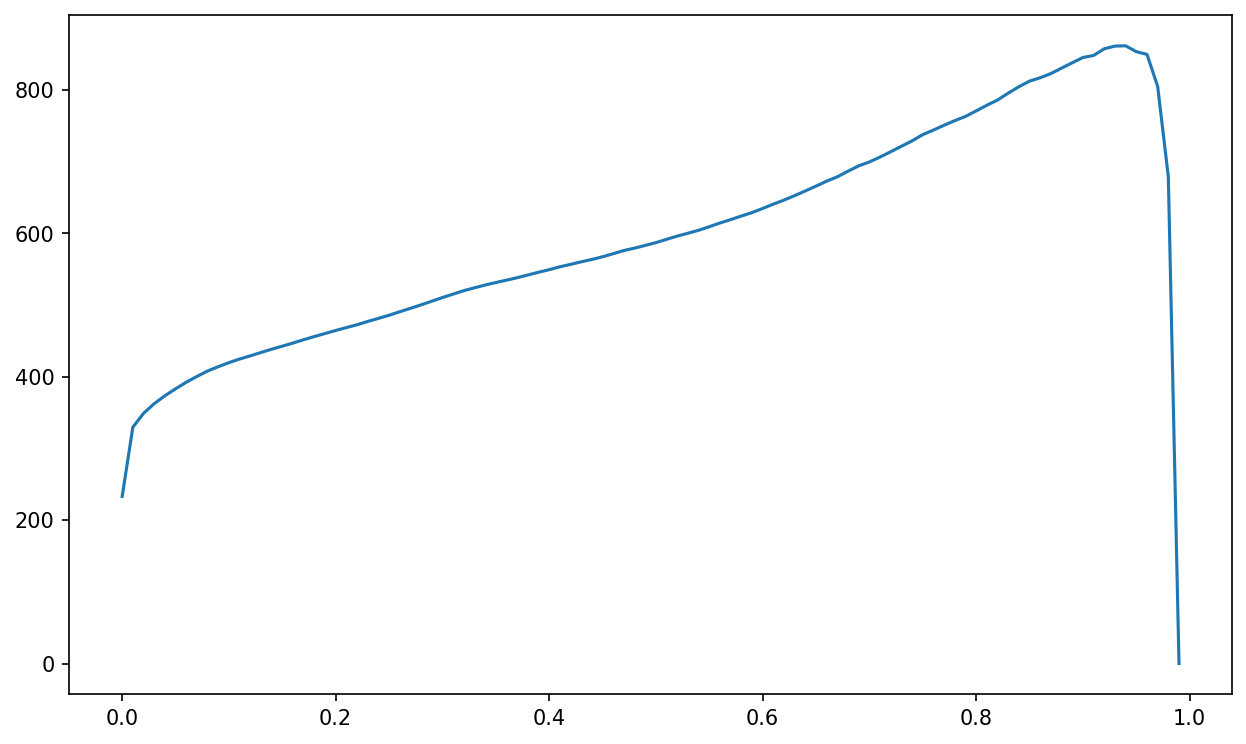

861.8684210526316


In [14]:
signal = even_data.df(odd_short_model, 'cpu').signal_vals['Pred']
background = even_data.df(odd_short_model, 'cpu').background_vals['Pred']
nbins = 100
xrange = [0, 1]

sens = []
for i in np.arange(0, 1, 1/nbins):
    pass_signal = [val for val in signal if val > i]
    npass_signal = len(pass_signal)
    pass_background = [val for val in background if val > i]
    npass_background = len(pass_background)
    if npass_background == 0:
        bin_sens = 0
    else:
        bin_sens = npass_signal / math.sqrt(npass_background)
    sens.append(bin_sens)
plt.plot(np.arange(0, 1, 1/nbins), sens)
plt.show()
print(max(sens))

## V2Odd with JZXW

In [28]:
version = 2
events = 'odd_jzw'
model_path = f'../trained_models/all_trained_dnn_v{version}{events}'
scaler_path = f'../trained_models/all_trained_dnn_v{version}odd_scaler.gz'

### Create  model

In [29]:
network = model_dict[version]
odd_jzw_model = network(branch_names).to(device)

### Save model

In [14]:
torch.save(odd_jzw_model.state_dict(), model_path)
joblib.dump(odd_scaler, scaler_path)

['../trained_models/all_trained_dnn_v2odd_scaler.gz']

### Load model

In [11]:
# odd_jzw_model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
# odd_jzw_model.eval()

### Define loss and optimizer

In [30]:
learning_rate = 1e-3
loss = nn.BCEWithLogitsLoss()
#optimizer = torch.optim.SGD(odd_jzw_model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(odd_jzw_model.parameters(), lr=learning_rate, momentum=0.9)

### Train and test

100%|██████████| 300/300 [59:46<00:00, 11.95s/it]


Done!


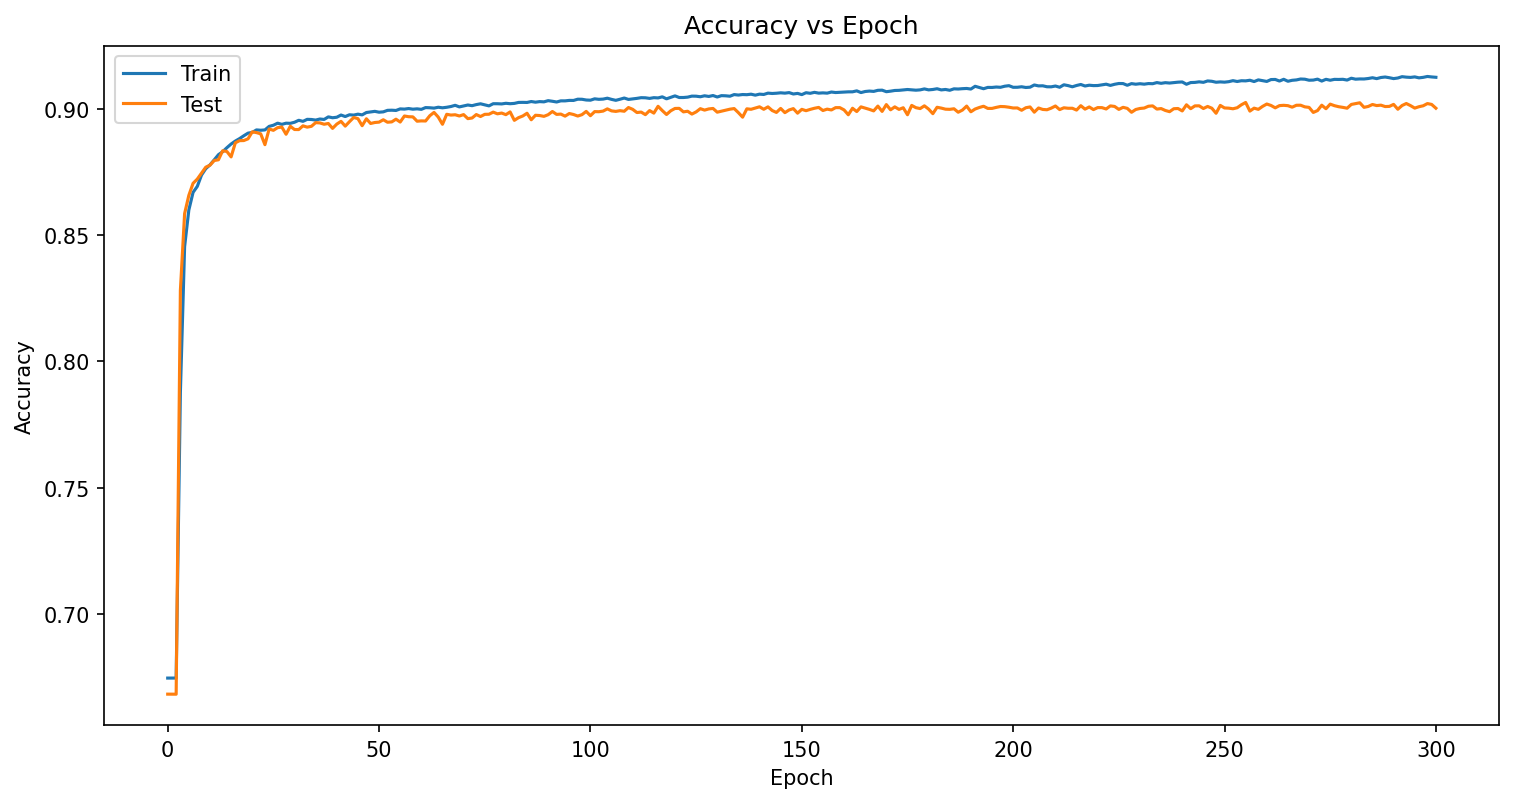

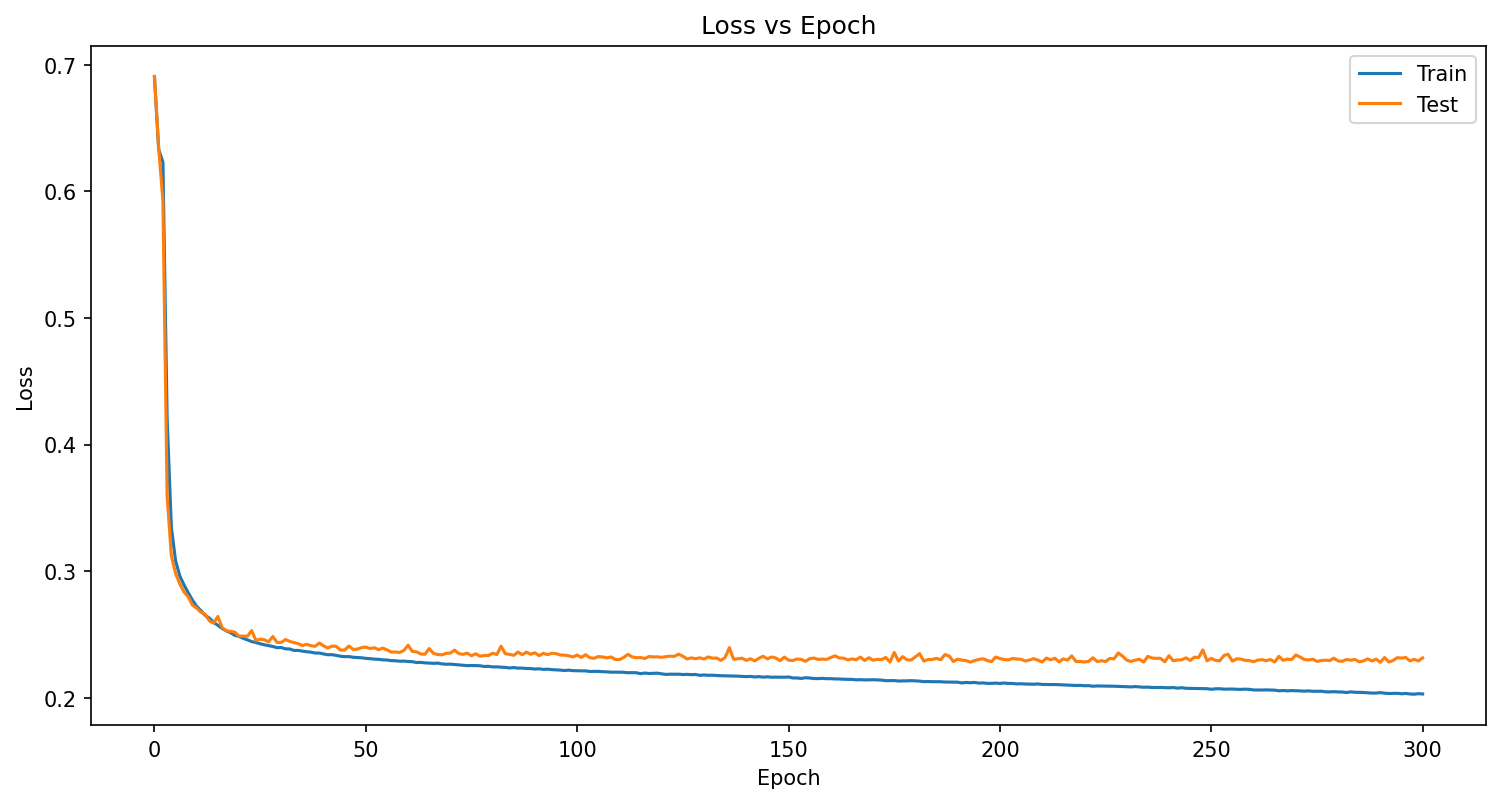

3592.5666035050526


In [31]:
odd_jzw_model.train()
odd_before = timer()
train_nn(odd_data, odd_jzw_model, loss, optimizer, device, 300) 
odd_after = timer()
odd_duration = odd_after - odd_before
print(odd_duration)

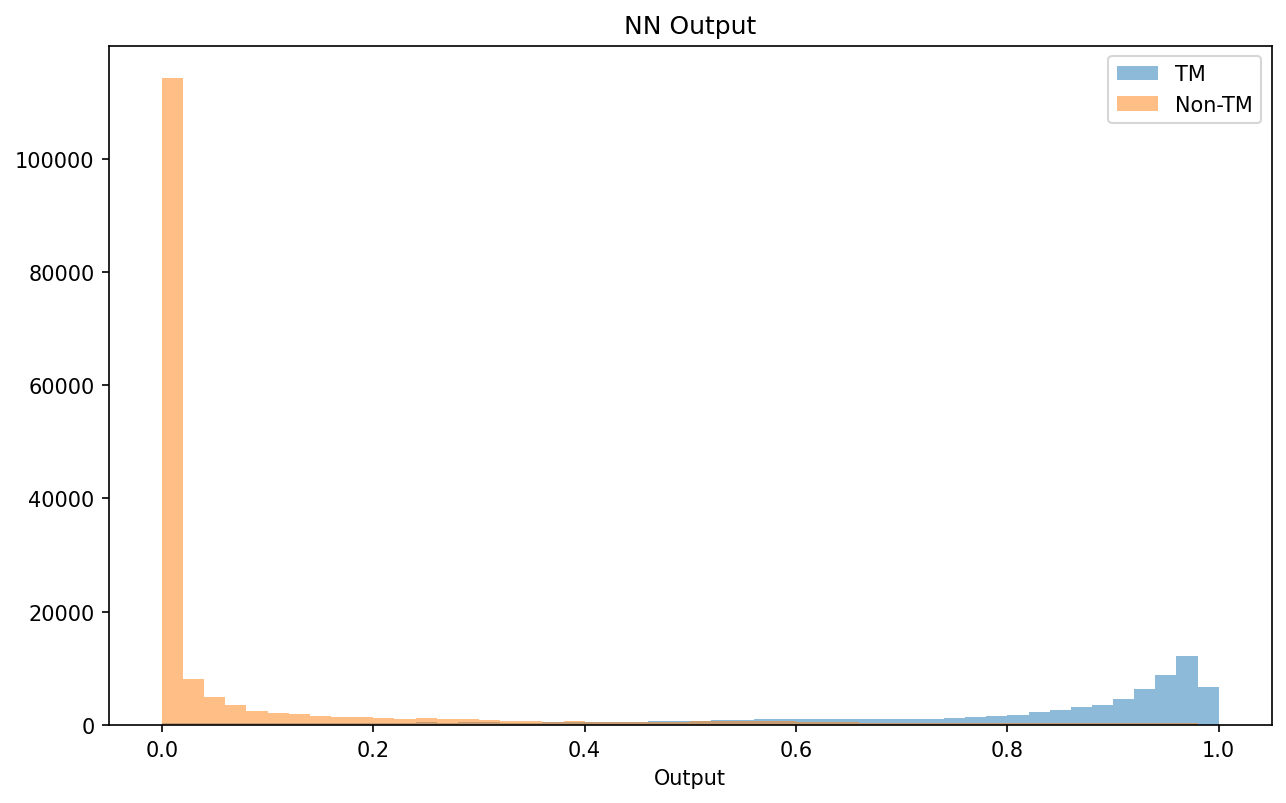

In [33]:
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams['figure.dpi'] = 150

signal = odd_data.df(odd_jzw_model, 'cpu').signal_vals['Pred']
background = odd_data.df(odd_jzw_model, 'cpu').background_vals['Pred']
# signal = even_data.df(odd_jzw_model, 'cpu').signal_vals['Pred']
# background = even_data.df(odd_jzw_model, 'cpu').background_vals['Pred']
alpha=0.5
nbins = 50
xrange = [0, 1]
plt.hist(signal, nbins, xrange, label='TM', alpha=alpha)
plt.hist(background, nbins, xrange, label='Non-TM', alpha=alpha)
plt.title('NN Output')
plt.xlabel('Output')
plt.legend()
plt.show()

## V2Even with JZXW

In [14]:
version = 2
events = 'even_jzw'
model_path = f'../trained_models/all_trained_dnn_v{version}{events}'
scaler_path = f'../trained_models/all_trained_dnn_v{version}even_scaler.gz'

### Create  model

In [15]:
network = model_dict[version]
even_jzw_model = network(branch_names).to(device)

### Save model

In [ ]:
torch.save(even_jzw_model.state_dict(), model_path)
joblib.dump(even_scaler, scaler_path)

### Load model

In [17]:
# even_jzw_model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
# even_jzw_model.eval()

### Define loss and optimizer

In [18]:
learning_rate = 1e-3
loss = nn.BCEWithLogitsLoss()
#optimizer = torch.optim.SGD(even_jzw_model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(even_jzw_model.parameters(), lr=learning_rate, momentum=0.9)

### Train and test

100%|██████████| 150/150 [36:42<00:00, 14.68s/it]


Done!


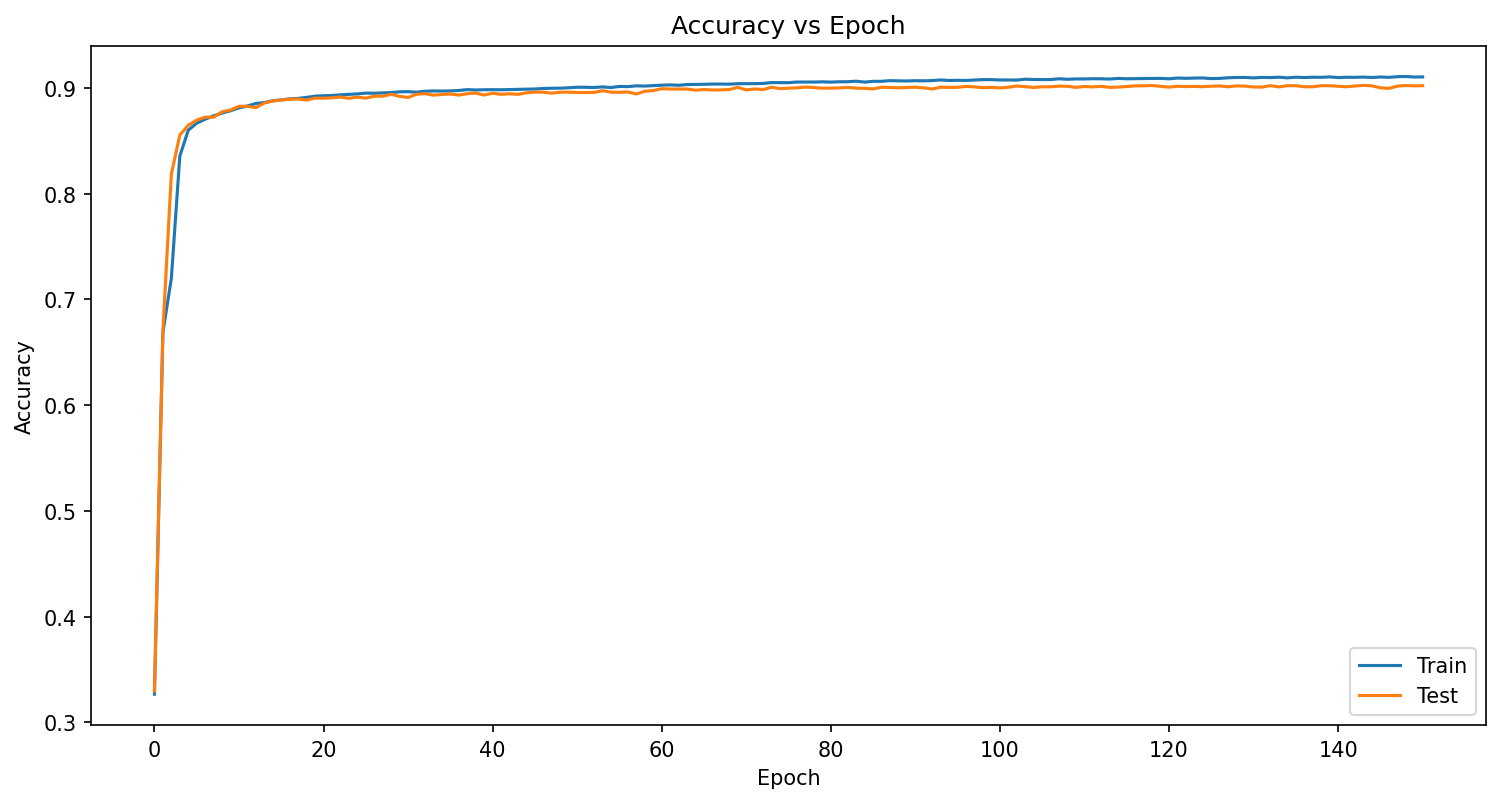

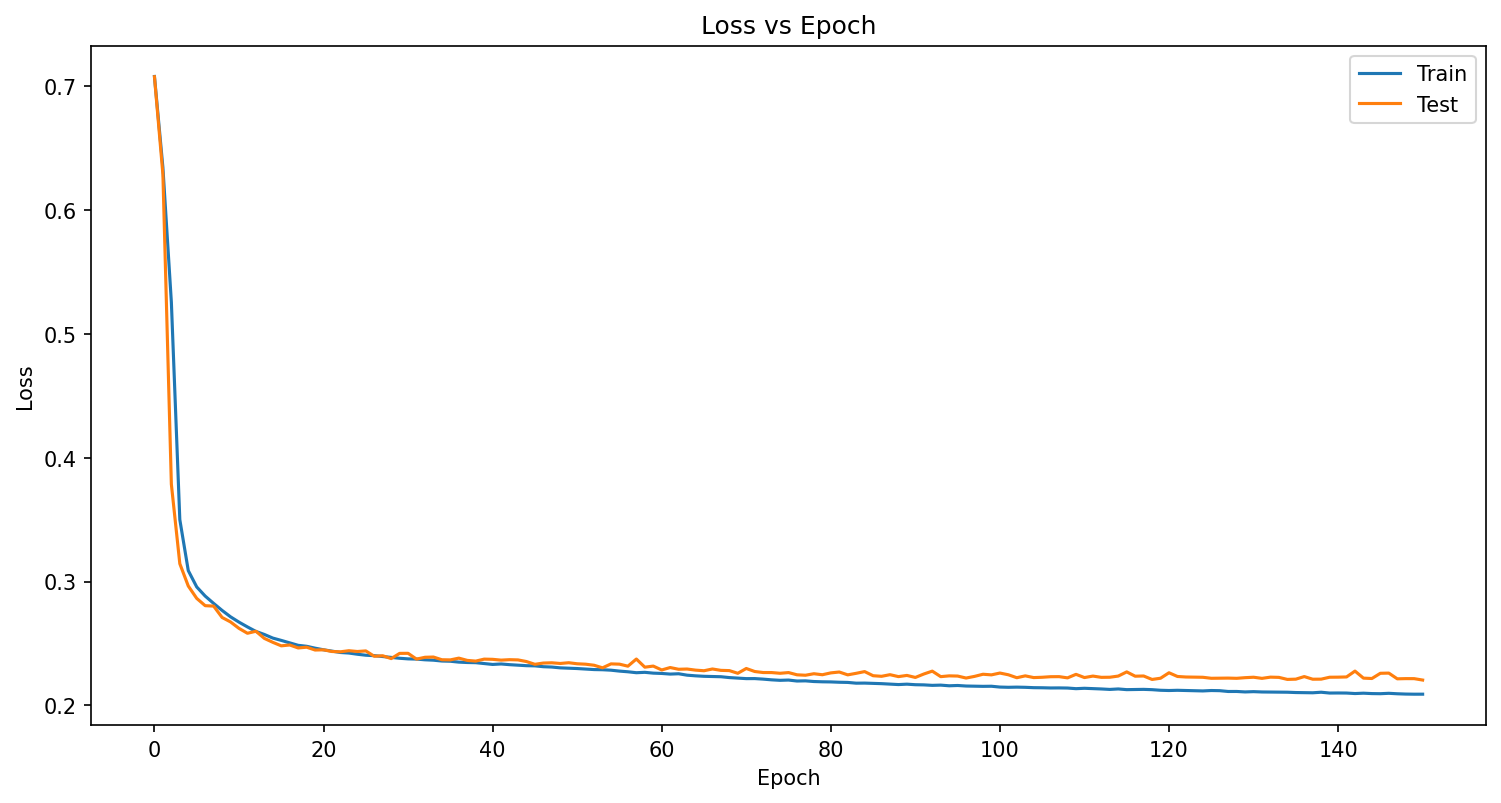

2209.457215433009


In [19]:
even_jzw_model.train()
even_before = timer()
train_nn(even_data, even_jzw_model, loss, optimizer, device, 150) 
even_after = timer()
even_duration = even_after - even_before
print(even_duration)

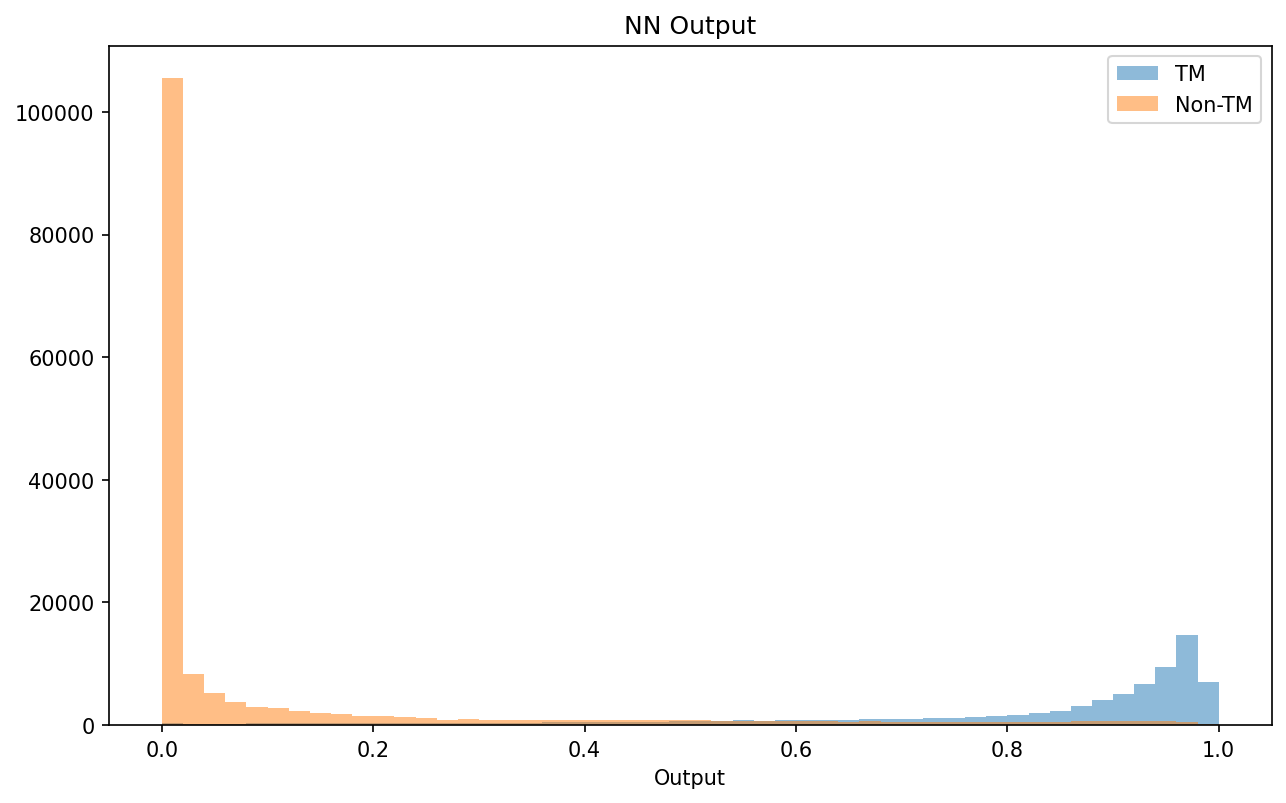

In [23]:
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams['figure.dpi'] = 150

signal = odd_data.df(even_jzw_model, 'cpu').signal_vals['Pred']
background = odd_data.df(even_jzw_model, 'cpu').background_vals['Pred']
alpha=0.5
nbins = 50
xrange = [0, 1]
plt.hist(signal, nbins, xrange, label='TM', alpha=alpha)
plt.hist(background, nbins, xrange, label='Non-TM', alpha=alpha)
plt.title('NN Output')
plt.xlabel('Output')
plt.legend()
plt.show()

## V2 - Tanh

In [8]:
version = 2
model_path = f'../trained_models/all_trained_dnn_v{version}_tanh'
scaler_path = f'../trained_models/all_trained_dnn_v{version}_tanh_scaler.gz'

### Create  model

In [9]:
network = model_dict[version]
tanh_model = network(branch_names, nn.Tanh()).to(device)

### Save model

In [13]:
torch.save(tanh_model.state_dict(), model_path)
joblib.dump(all_scaler, scaler_path)

['../trained_models/all_trained_dnn_v2_scaler.gz']

### Load model

In [10]:
tanh_model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
tanh_model.eval()

NeuralNetworkV2(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=19, out_features=38, bias=True)
    (1): ReLU()
    (2): Linear(in_features=38, out_features=57, bias=True)
    (3): ReLU()
    (4): Linear(in_features=57, out_features=57, bias=True)
    (5): ReLU()
    (6): Linear(in_features=57, out_features=57, bias=True)
    (7): ReLU()
    (8): Linear(in_features=57, out_features=57, bias=True)
    (9): Dropout(p=0.2, inplace=False)
    (10): ReLU()
    (11): Linear(in_features=57, out_features=38, bias=True)
    (12): ReLU()
    (13): Linear(in_features=38, out_features=1, bias=True)
  )
)

### Define loss and optimizer

In [10]:
learning_rate = 1e-3
loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(tanh_model.parameters(), lr=learning_rate, momentum=0.9)

### Train and test

100%|██████████| 1000/1000 [6:50:57<00:00, 24.66s/it] 


Done!


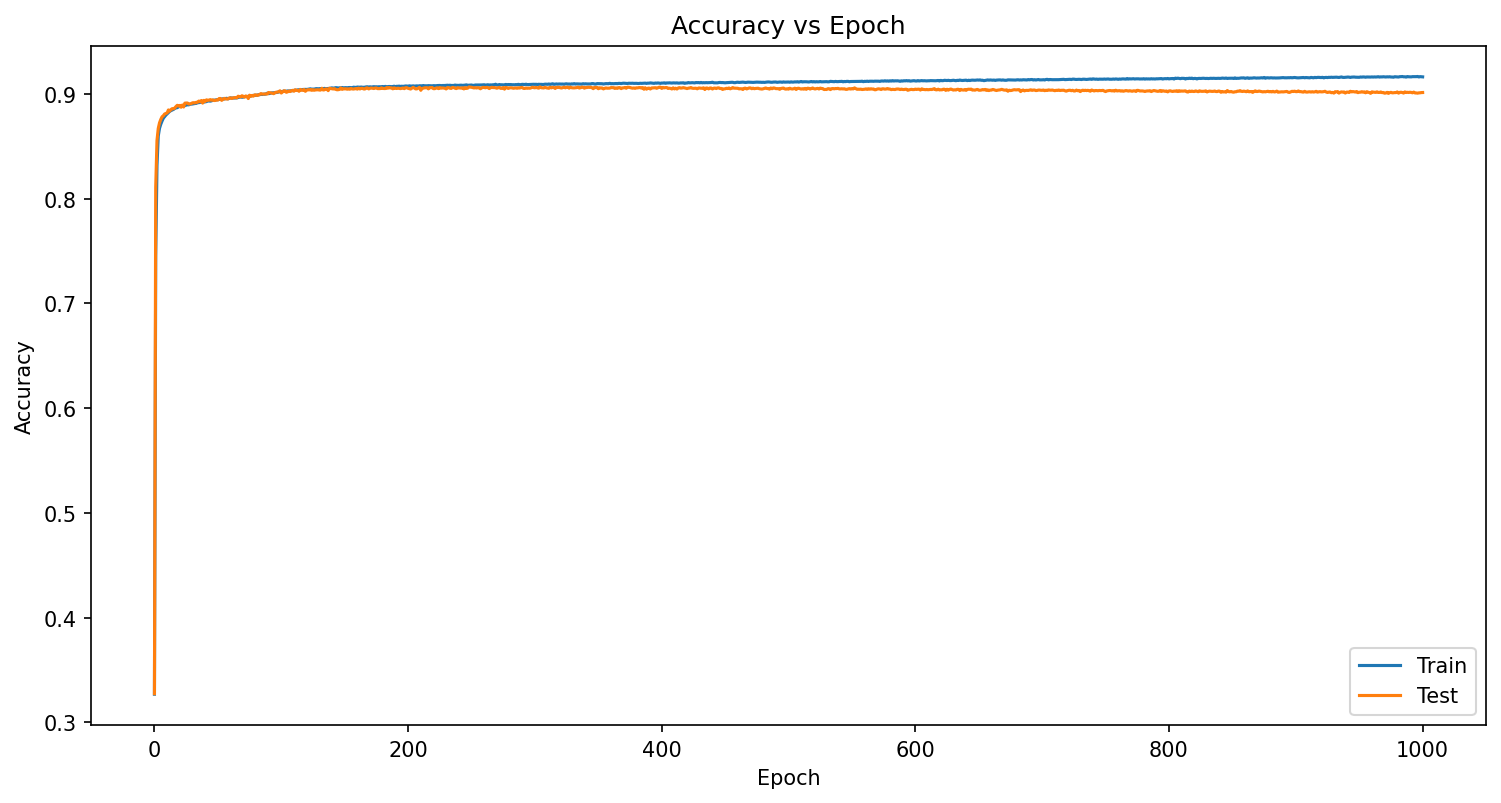

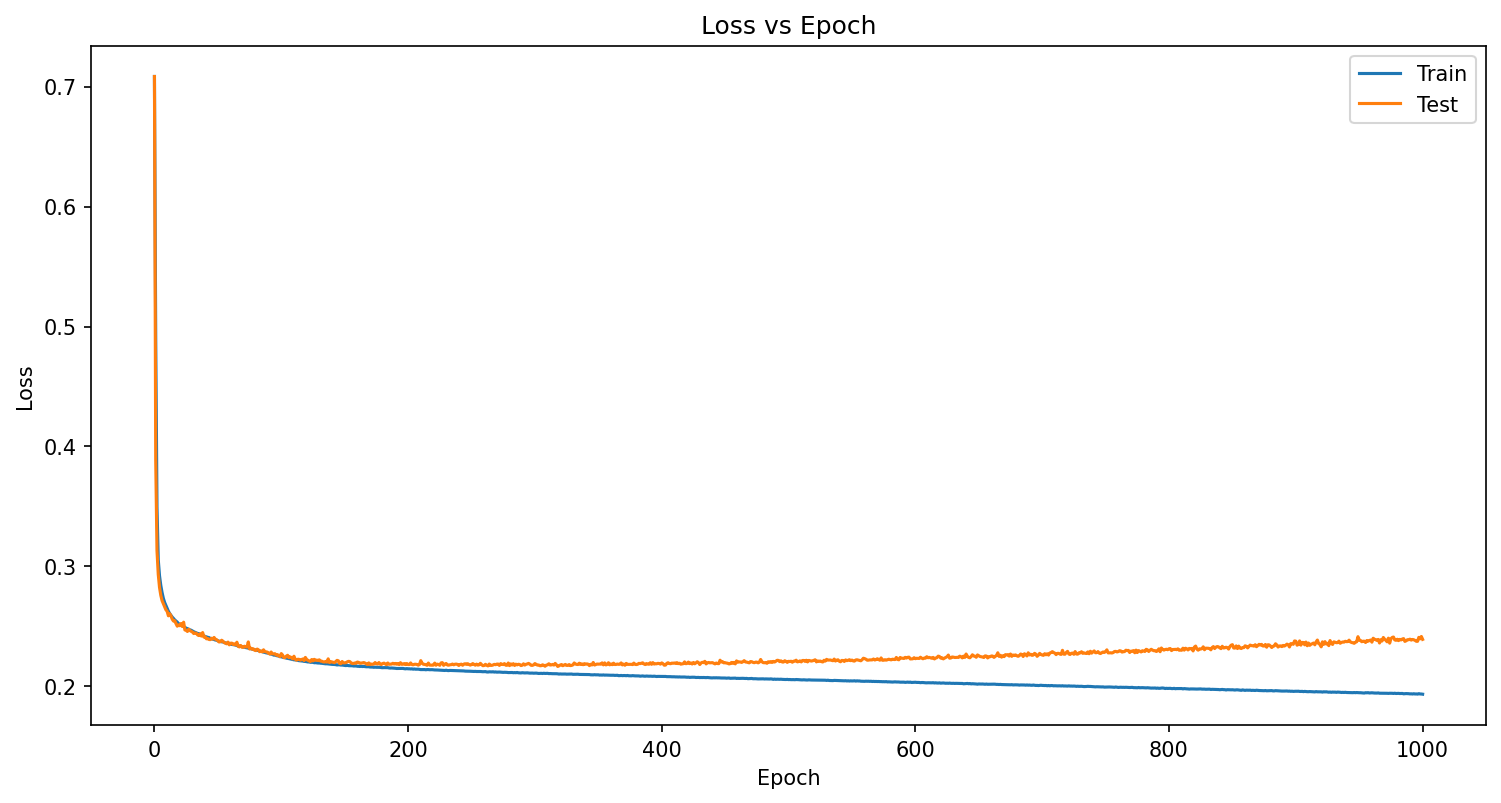

24684.158021142997


In [11]:
tanh_model.train()
tanh_before = timer()
train_nn(all_data, tanh_model, loss, optimizer, device, 1000) 
tanh_after = timer()
tanh_duration = tanh_after - tanh_before
print(tanh_duration)

## Signal-only Model

### Load and save model

In [36]:
torch.save(signal_model.state_dict(), '../trained_models/signal_trained_dnn_v2')
#joblib.dump(scaler, '../trained_models/signal_trained_dnn_v1_scaler.gz')

In [159]:
signal_model = NeuralNetworkV1(branch_names)
signal_model.load_state_dict(torch.load('../trained_models/signal_trained_dnn_v1'))

<All keys matched successfully>

### Create  model

In [34]:
signal_model = NeuralNetworkV2(branch_names).to(device)

### Train and test

100%|██████████| 500/500 [1:57:07<00:00, 14.05s/it]  


Done!


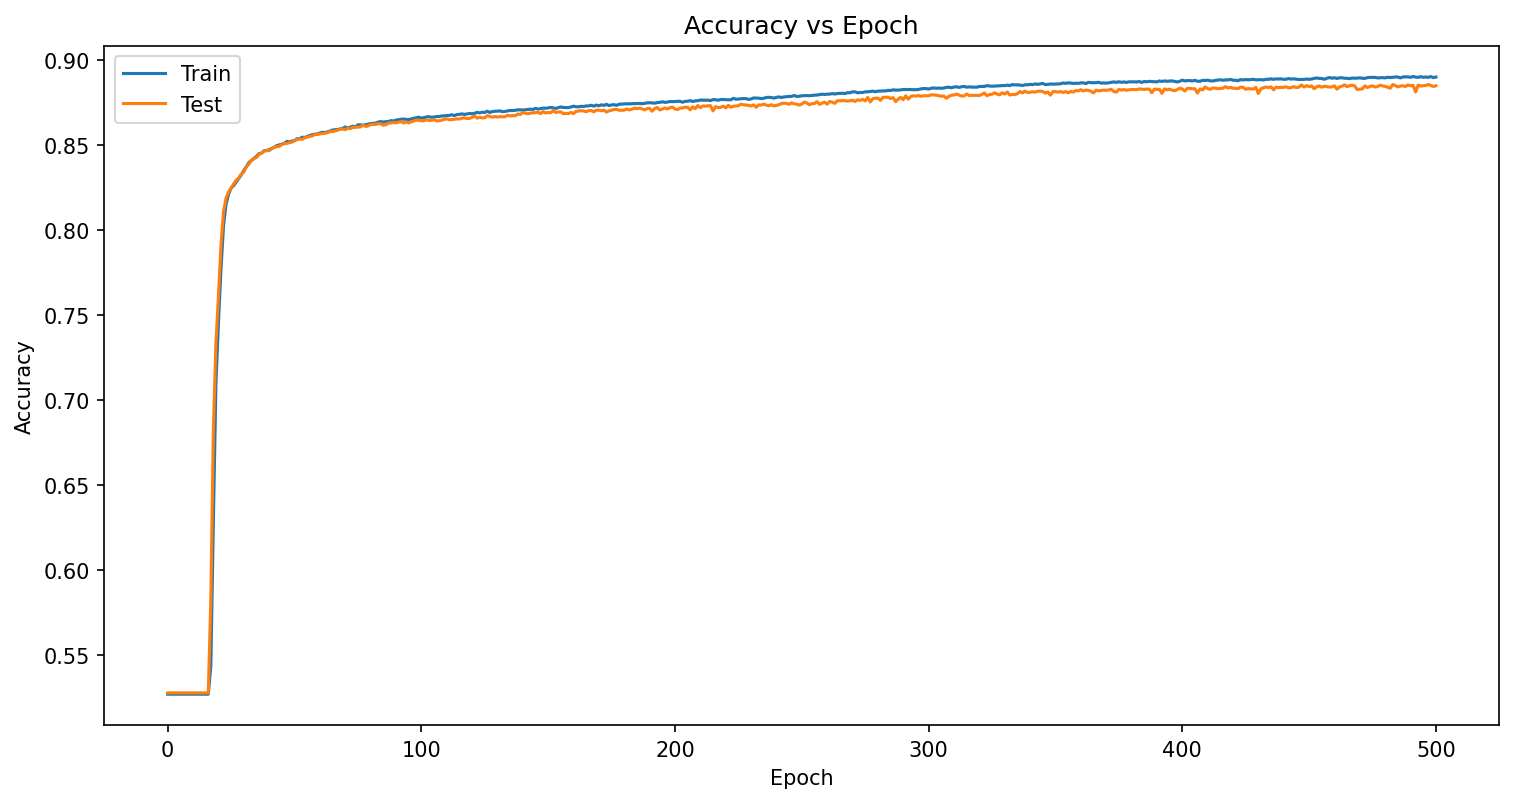

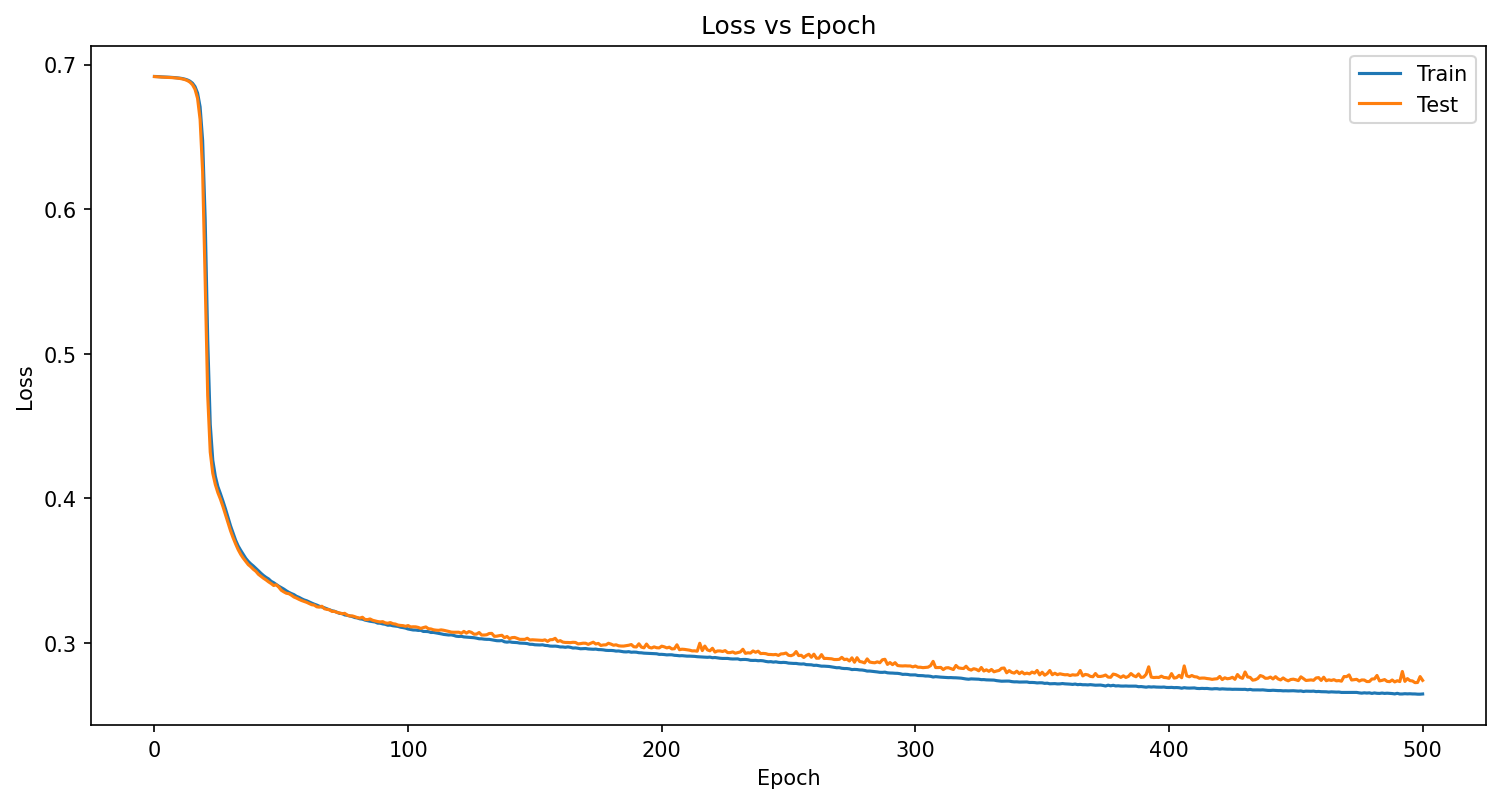

In [35]:
optimizer = torch.optim.SGD(signal_model.parameters(), lr=learning_rate)
train_nn(signal_data, signal_model, loss, optimizer, device, 500) 

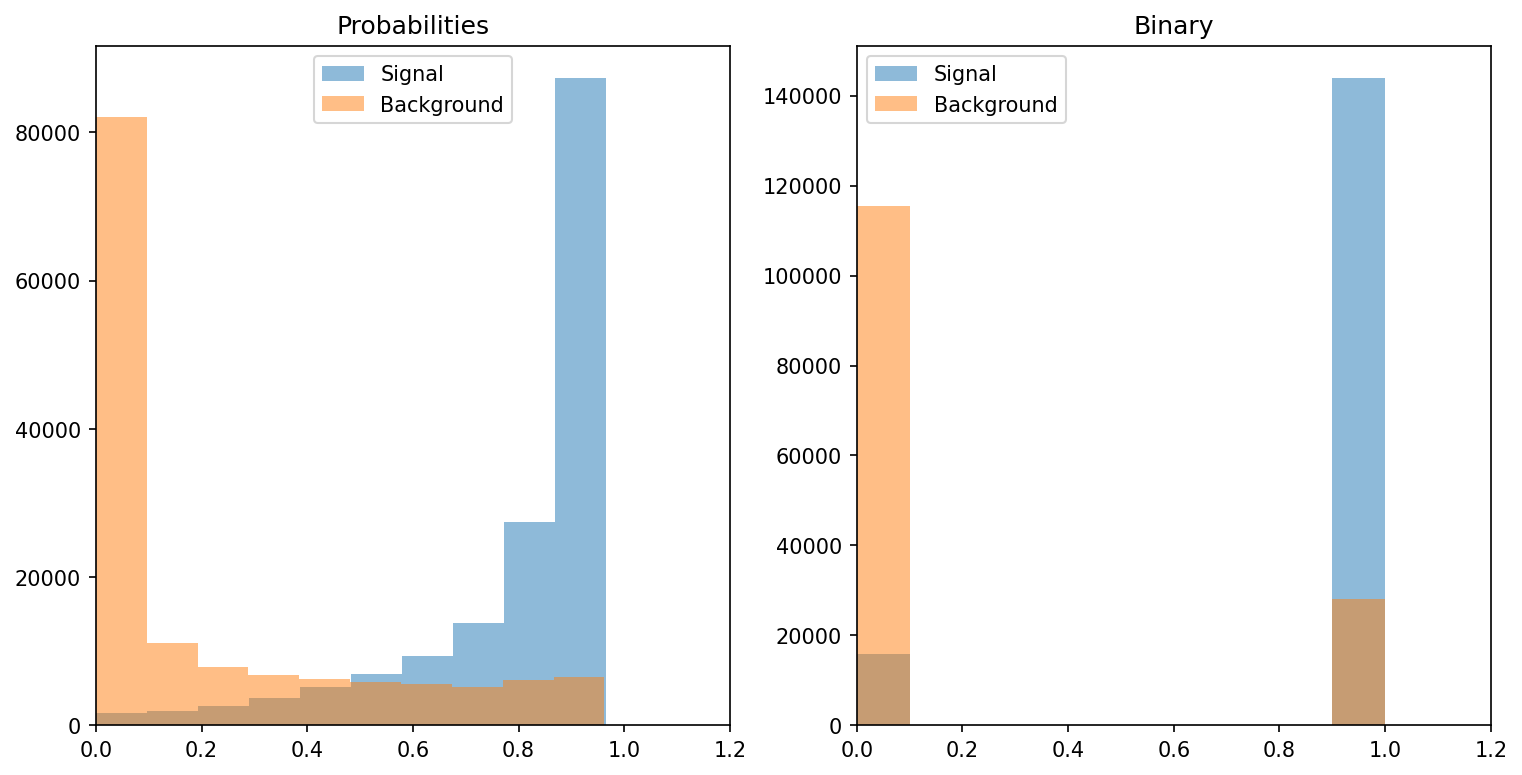

In [8]:
plot_predictions_by_truth(signal_data.dataloader, signal_model)

X1000 events: 89983
Signal: 60.0%
Background: 40.0%
X1600 events: 144842
Signal: 63.7%
Background: 36.3%
X2000 events: 68408
Signal: 60.2%
Background: 39.8%
ttbar events: 70191
Signal: 35.5%
Background: 64.5%
Z+jets events: 21528
Signal: 23.5%
Background: 76.5%


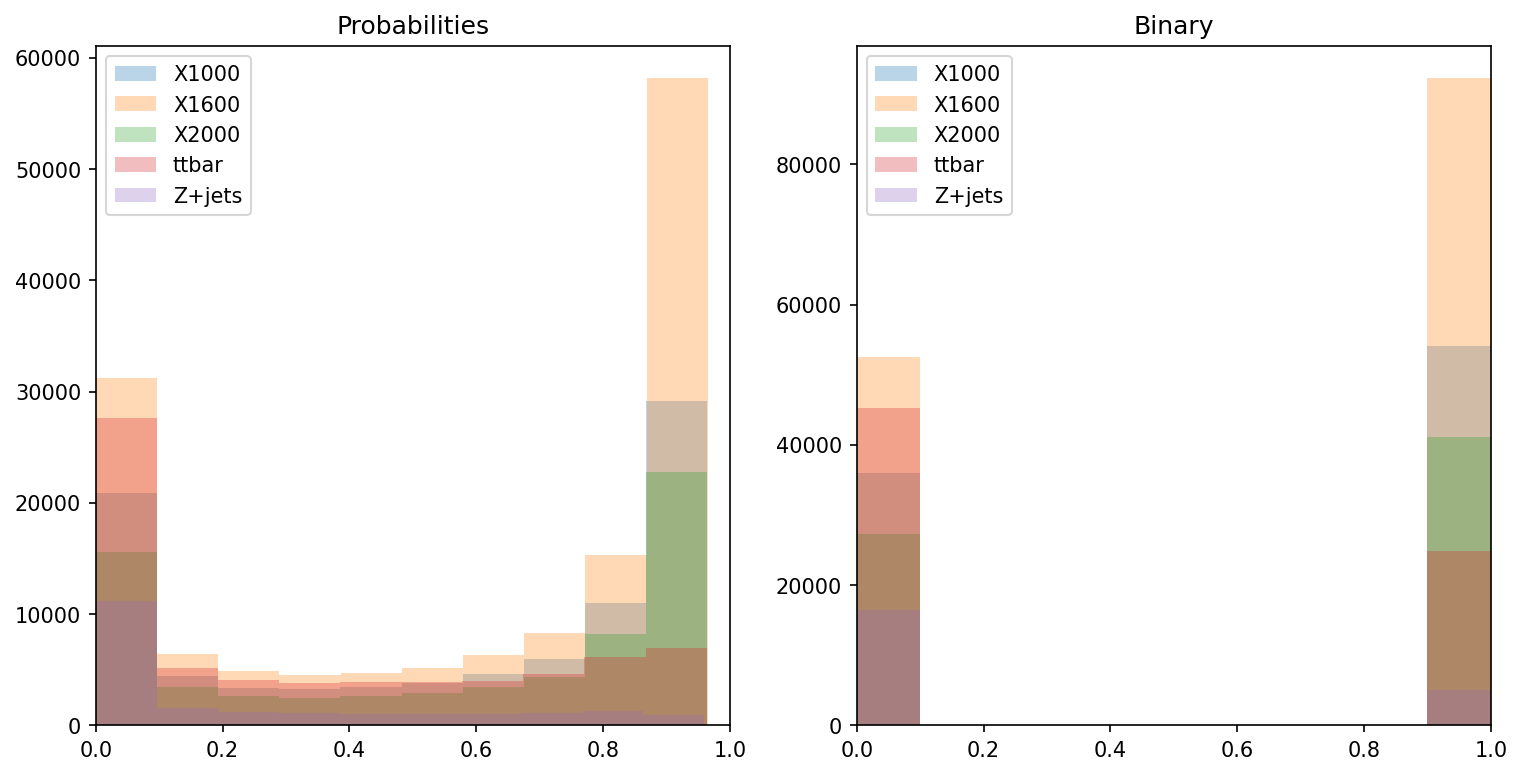

In [9]:
plot_predictions_by_sample(sample_id_dict, all_data.dataloader, signal_model)

3 Hidden Layers:

2000 epochs

Accuracy: 87.2%

Loss: 0.299

In [39]:
df = signal_data.test_df(signal_model)
print('Total systems')
print(len(df.all_vals))
print('Sytems kept (unique events)')
print(len(df.max_vals))
print('Systems discarded (multi-system events)')
print(len(df.nonmax_vals))
print('True systems discarded')
print(len(df.nonmax_signal_vals))
print('False systems discarded')
print(len(df.nonmax_background_vals))
print('True systems kept')
print(len(df.max_signal_vals))
print('False systems kept')
print(len(df.max_background_vals))
print('')
print('"Kept" = Max system per event')
print('"Discarded" = Non-max system per event')

Total systems
60647
Sytems kept (unique events)
58198
Systems discarded (multi-system events)
2449
True systems discarded
34
False systems discarded
2415
True systems kept
31970
False systems kept
26228

"Kept" = Max system per event
"Discarded" = Non-max system per event


|                          |       |
|--------------------------|-------|
| TM Systems Discarded     | 0.1%  |
| Non-TM Systems Discarded | 8.5%  |
| TM Systems Kept          | 99.9% |
| Non-TM Systems Kept      | 91.5% |

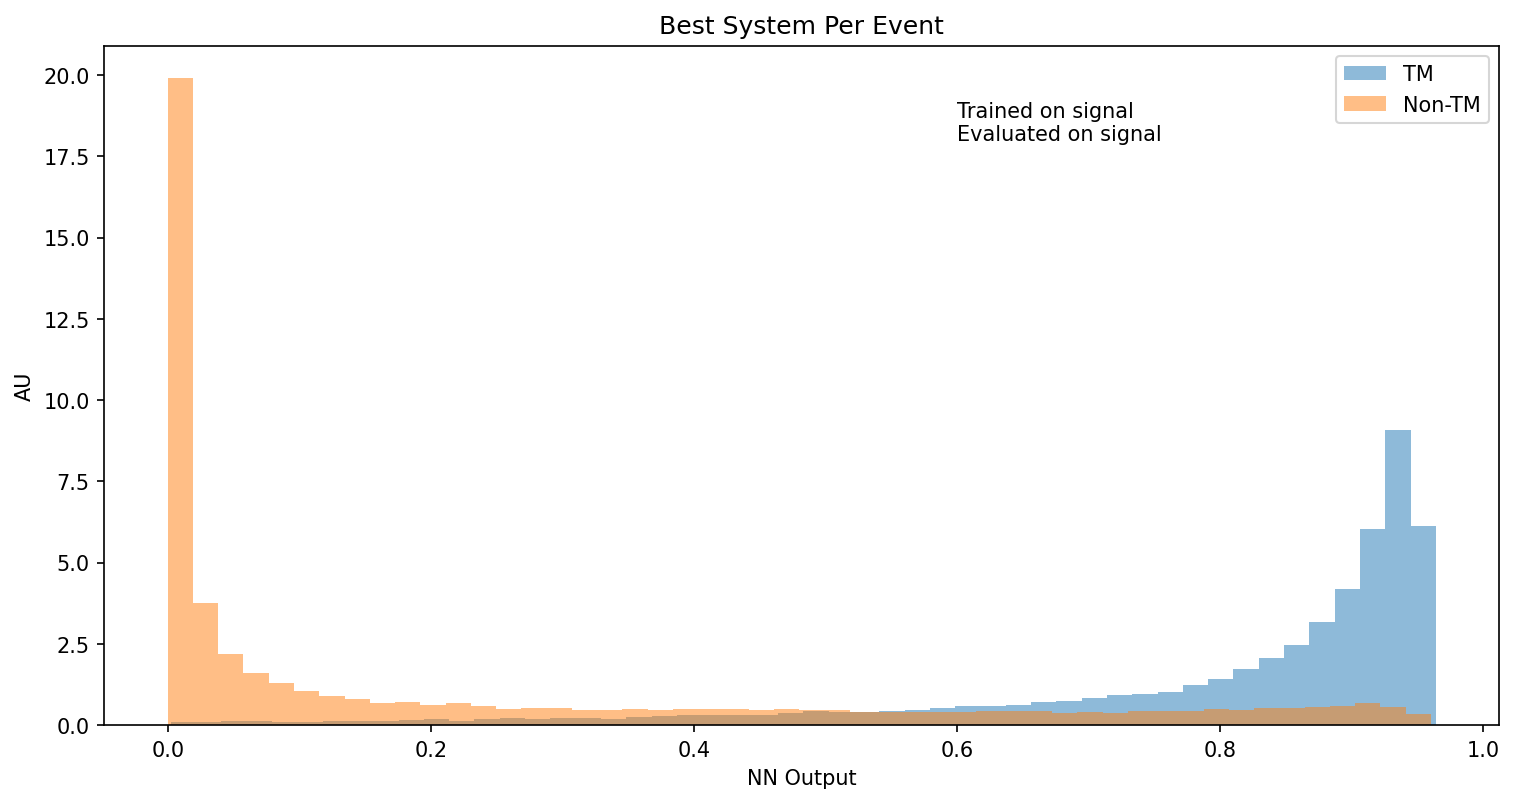

In [10]:
plot_best_system_pred(signal_data.test_df(signal_model), 'Trained on signal', 'Evaluated on signal')

In [11]:
final_loss, final_acc = test_loop(signal_data.test_dataloader, signal_model, loss)
print(f'Final loss: {final_loss:.3f}')
print(f'Final accuracy: {final_acc:.3f}')

Final loss: 0.335
Final accuracy: 0.854


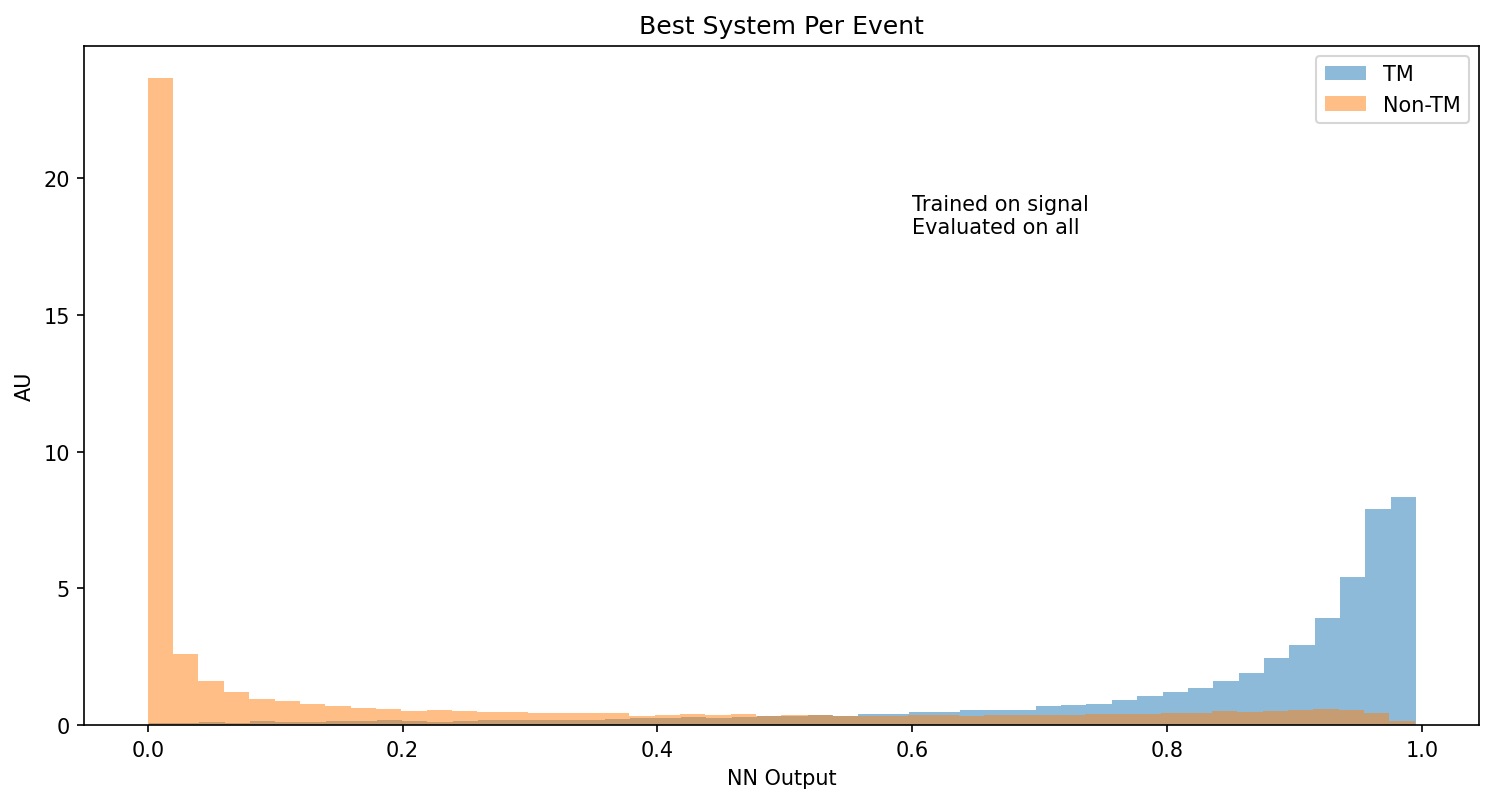

In [28]:
plot_best_system_pred(all_data.test_df(signal_model), 'Trained on signal', 'Evaluated on all')

In [29]:
final_loss, final_acc = test_loop(all_data.test_dataloader, signal_model, loss)
print(f'Final loss: {final_loss:.3f}')
print(f'Final accuracy: {final_acc:.3f}')

Final loss: 0.335
Final accuracy: 0.849


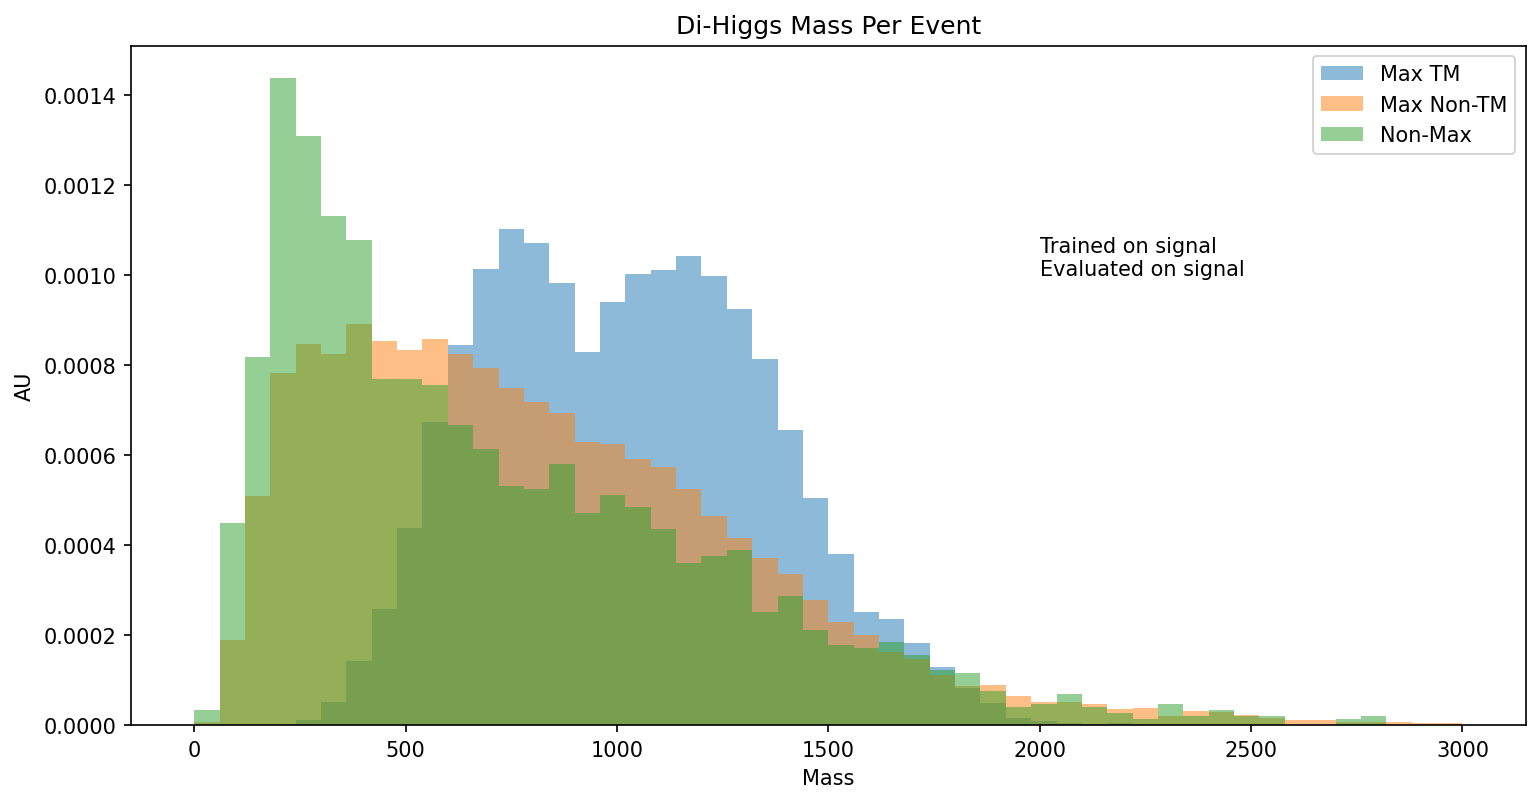

In [42]:
plt.rcParams['figure.figsize'] = [12,6] 
plt.rcParams['figure.dpi'] = 150

df = signal_data.test_df(signal_model)
plt.hist(df.max_signal_vals['DiHiggsM'], bins=50, alpha=0.5, range=(0, 3000), label='Max TM', density=True)
plt.hist(df.max_background_vals['DiHiggsM'], bins=50, alpha=0.5, range=(0, 3000), label='Max Non-TM', density=True)
plt.hist(df.nonmax_vals['DiHiggsM'], bins=50, alpha=0.5, range=(0, 3000), label='Non-Max', density=True)
plt.title('Di-Higgs Mass Per Event')
plt.text(2000, 0.001, 'Trained on signal\nEvaluated on signal')
plt.legend()
plt.xlabel('Mass')
plt.ylabel('AU')
plt.show()

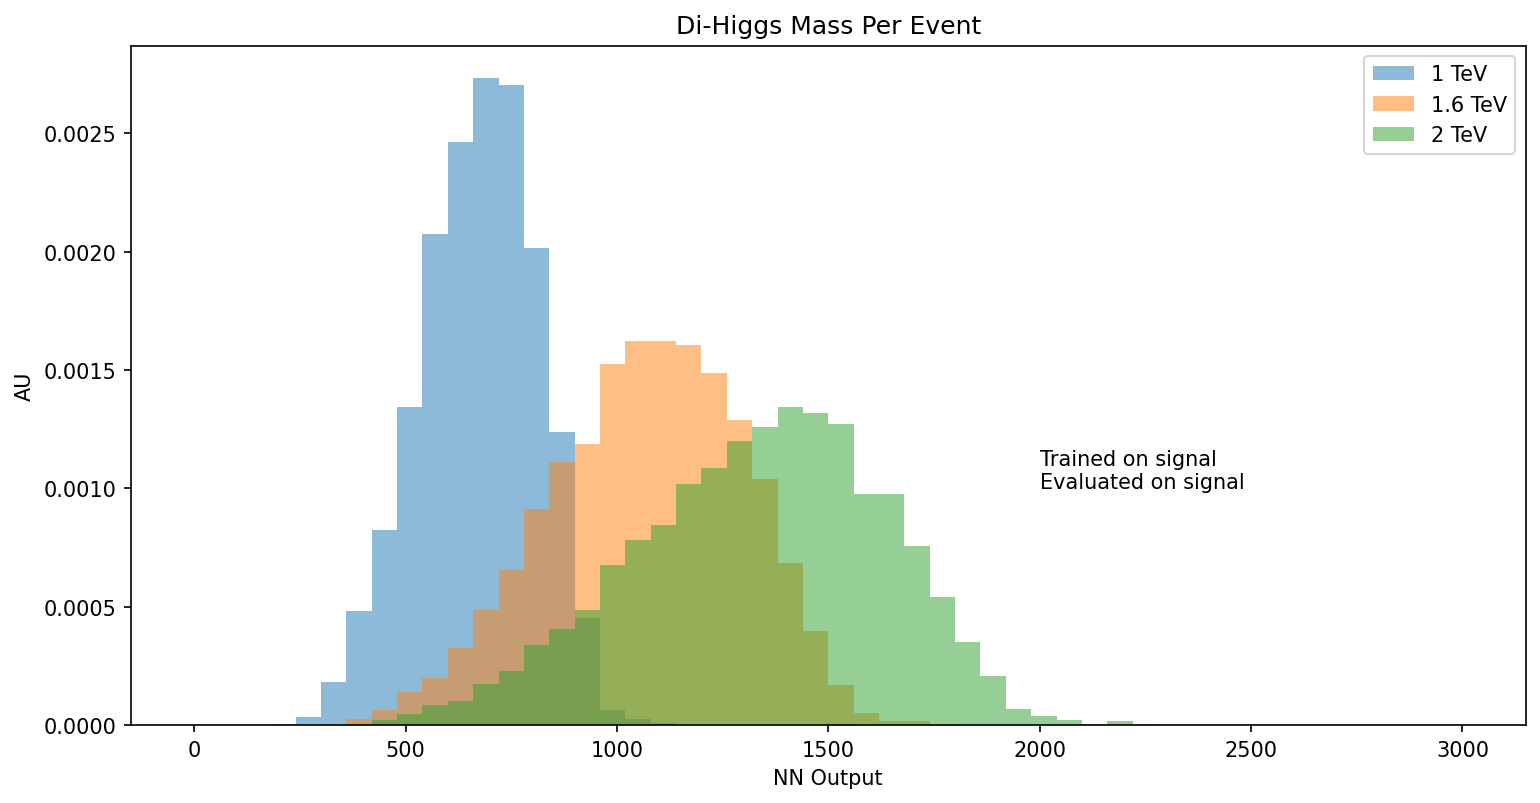

In [160]:
plt.rcParams['figure.figsize'] = [12,6] 
plt.rcParams['figure.dpi'] = 150

df = signal_data.test_df(signal_model)
plt.hist(df.max_signal_vals['DiHiggsM'][df.max_signal_vals['SampleID'] == 0], bins=50, alpha=0.5, range=(0, 3000), label='1 TeV', density=True)
plt.hist(df.max_signal_vals['DiHiggsM'][df.max_signal_vals['SampleID'] == 1], bins=50, alpha=0.5, range=(0, 3000), label='1.6 TeV', density=True)
plt.hist(df.max_signal_vals['DiHiggsM'][df.max_signal_vals['SampleID'] == 2], bins=50, alpha=0.5, range=(0, 3000), label='2 TeV', density=True)
plt.title('Di-Higgs Mass Per Event')
plt.text(2000, 0.001, 'Trained on signal\nEvaluated on signal')
plt.legend()
plt.xlabel('NN Output')
plt.ylabel('AU')
plt.show()

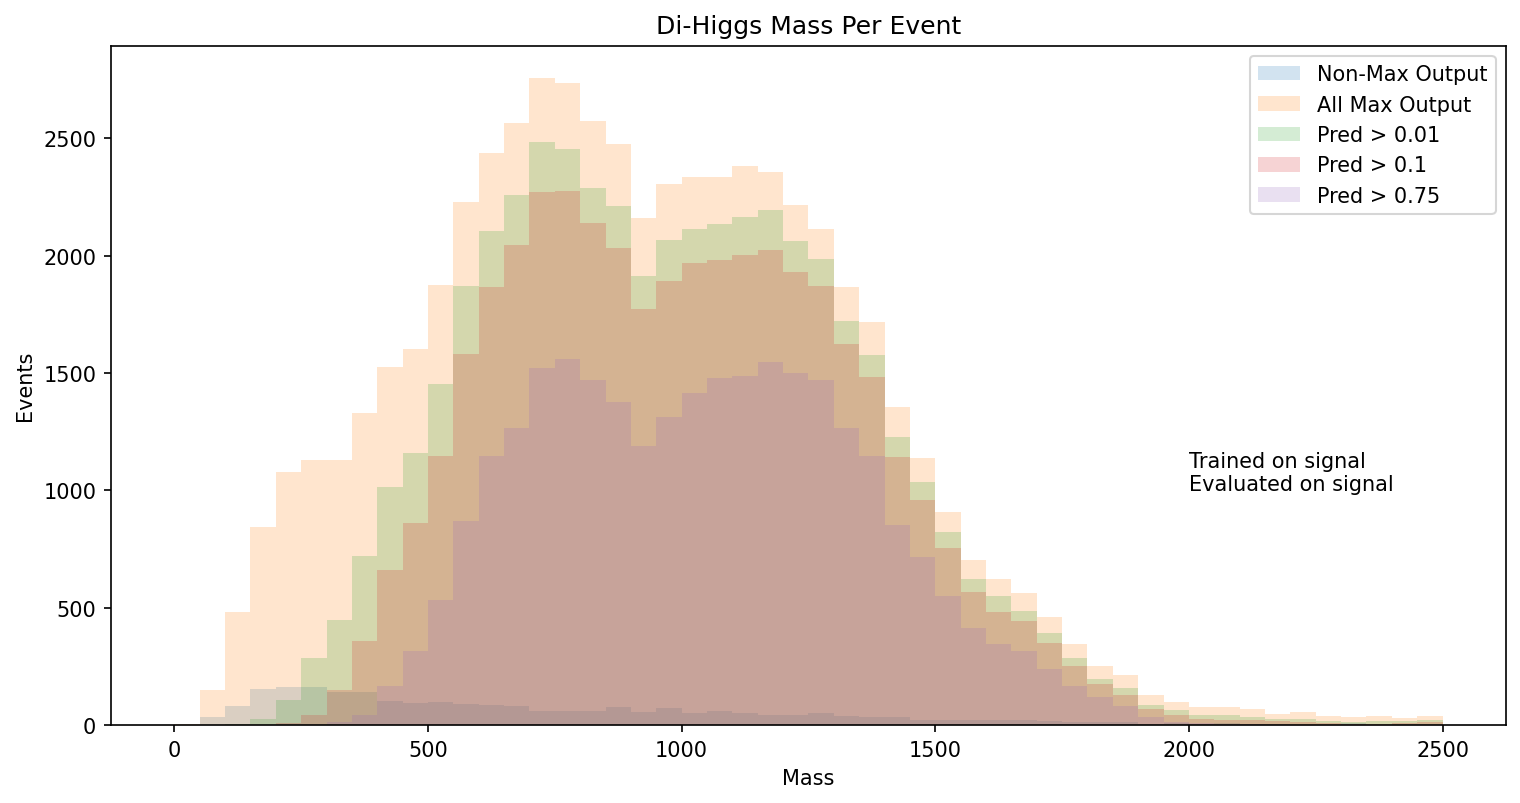

In [57]:
plt.rcParams['figure.figsize'] = [12,6] 
plt.rcParams['figure.dpi'] = 150

df = signal_data.test_df(signal_model)
nn_cuts = [0.01, 0.1, 0.75]
density = False
alpha=0.2
min_range = 0
max_range = 2500
plt.hist(df.nonmax_vals['DiHiggsM'], bins=50, alpha=alpha, range=(min_range, max_range), label='Non-Max Output', density=density)
max_vals = df.max_vals
plt.hist(max_vals['DiHiggsM'], bins=50, alpha=alpha, range=(min_range, max_range), label='All Max Output', density=density)
for cut in nn_cuts:
    plt.hist(max_vals['DiHiggsM'][max_vals['Pred'] > cut], bins=50, alpha=alpha, range=(min_range, max_range), label=f'Pred > {cut}', density=density)

plt.title('Di-Higgs Mass Per Event')
plt.text(2000, 1000, 'Trained on signal\nEvaluated on signal')
plt.legend()
plt.xlabel('Mass')
plt.ylabel('Events')
plt.show()

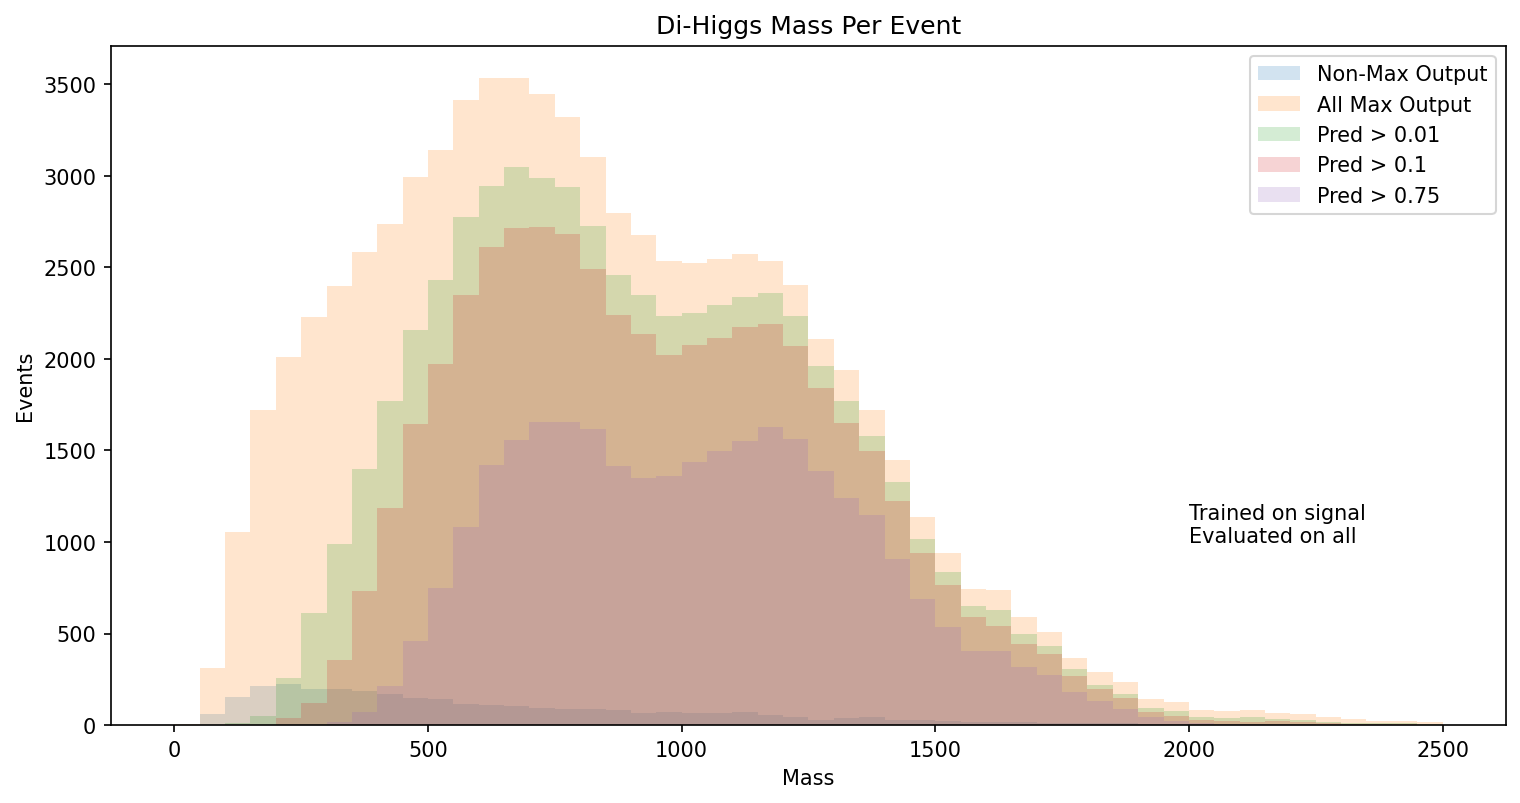

In [17]:
plt.rcParams['figure.figsize'] = [12,6] 
plt.rcParams['figure.dpi'] = 150

df = all_data.test_df(signal_model)
nn_cuts = [0.01, 0.1, 0.75]
density = False
alpha=0.2
min_range = 0
max_range = 2500
plt.hist(df.nonmax_vals['DiHiggsM'], bins=50, alpha=alpha, range=(min_range, max_range), label='Non-Max Output', density=density)
max_vals = df.max_vals
plt.hist(max_vals['DiHiggsM'], bins=50, alpha=alpha, range=(min_range, max_range), label='All Max Output', density=density)
for cut in nn_cuts:
    plt.hist(max_vals['DiHiggsM'][max_vals['Pred'] > cut], bins=50, alpha=alpha, range=(min_range, max_range), label=f'Pred > {cut}', density=density)

plt.title('Di-Higgs Mass Per Event')
plt.text(2000, 1000, 'Trained on signal\nEvaluated on all')
plt.legend()
plt.xlabel('Mass')
plt.ylabel('Events')
plt.show()

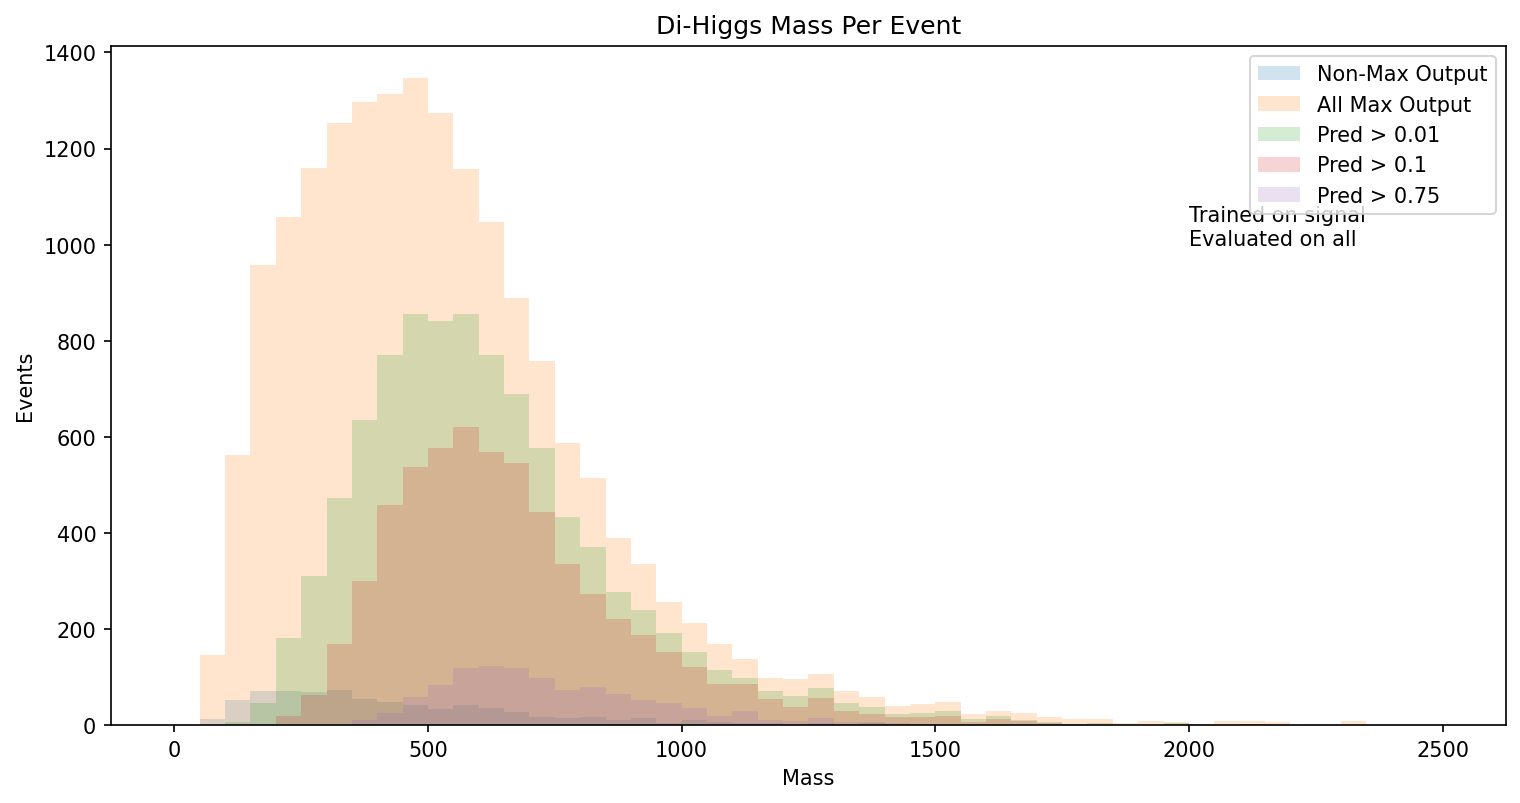

In [26]:
plt.rcParams['figure.figsize'] = [12,6] 
plt.rcParams['figure.dpi'] = 150

df = background_data.test_df(signal_model)
nn_cuts = [0.01, 0.1, 0.75]
density = False
alpha=0.2
min_range = 0
max_range = 2500
plt.hist(df.nonmax_vals['DiHiggsM'], bins=50, alpha=alpha, range=(min_range, max_range), label='Non-Max Output', density=density)
max_vals = df.max_vals
plt.hist(max_vals['DiHiggsM'], bins=50, alpha=alpha, range=(min_range, max_range), label='All Max Output', density=density)
for cut in nn_cuts:
    plt.hist(max_vals['DiHiggsM'][max_vals['Pred'] > cut], bins=50, alpha=alpha, range=(min_range, max_range), label=f'Pred > {cut}', density=density)

plt.title('Di-Higgs Mass Per Event')
plt.text(2000, 1000, 'Trained on signal\nEvaluated on background')
plt.legend()
plt.xlabel('Mass')
plt.ylabel('Events')
plt.show()

Optimal cut value
0.53

Optimal signal efficiency
0.92

Optimal background rejection
0.82


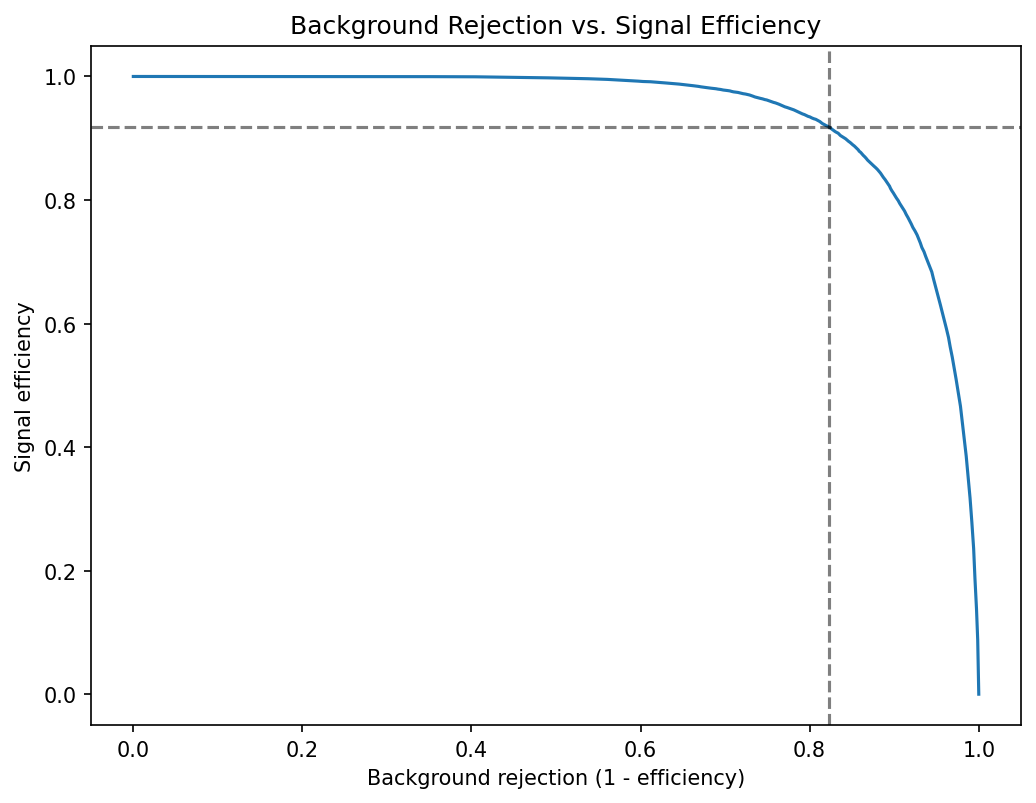

In [118]:
import math

plt.rcParams['figure.figsize'] = [8,6] 
plt.rcParams['figure.dpi'] = 150
min_val = 0
max_val = 1
step_size = 0.005
df = test_df
output_branch = branch_names.output_branch_name
signal_preds = df.max_signal_vals[output_branch]
background_preds = df.max_background_vals[output_branch]
nsignal = len(signal_vals)
nbackground = len(background_vals)
signal_effs = []
background_rejs = []
pred_vals = []
eff_metric = []
for i in np.arange(min_val, max_val, step_size):
    signal_cut = signal_preds[signal_preds > i]
    nsignal_cut = len(signal_cut)
    signal_eff = nsignal_cut / nsignal
    signal_effs.append(signal_eff)
    
    background_cut = background_preds[background_preds > i]
    nbackground_cut = len(background_cut)
    background_rej = 1 - nbackground_cut / nbackground
    background_rejs.append(background_rej)
    
    metric = math.sqrt(signal_eff**2 + background_rej**2)
    eff_metric.append(metric)
    
max_ind = eff_metric.index(max(eff_metric))
print('Optimal cut value')
print(max_ind * step_size)
print('\nOptimal signal efficiency')
print(f'{signal_effs[max_ind]:.2f}')
print('\nOptimal background rejection')
print(f'{background_rejs[max_ind]:.2f}') 

plt.plot(background_rejs, signal_effs)
plt.axhline(signal_effs[max_ind], linestyle='--', color='black', alpha=0.5)
plt.axvline(background_rejs[max_ind], linestyle='--', color='black', alpha=0.5)
plt.title('Background Rejection vs. Signal Efficiency')
plt.xlabel('Background rejection (1 - efficiency)')
plt.ylabel('Signal efficiency')
plt.show()

In [9]:
plt.rcParams['figure.figsize'] = [12,6] 
plt.rcParams['figure.dpi'] = 150
val_df = all_df
plt.hist(val_df.max_signal_vals['Pred'], bins=50, alpha=0.5, label='TM', density=True)
plt.hist(val_df.max_background_vals['Pred'], bins=50, alpha=0.5, label='Non-TM', density=True)
plt.title('Max System Probabilities Per Event')
plt.text(0.6, 18, 'Trained on signal\nEvaluated on signal+background')
plt.legend()
plt.show()

NameError: name 'all_df' is not defined

Optimal cut value
0.58

Optimal signal efficiency
0.89

Optimal background rejection
0.76


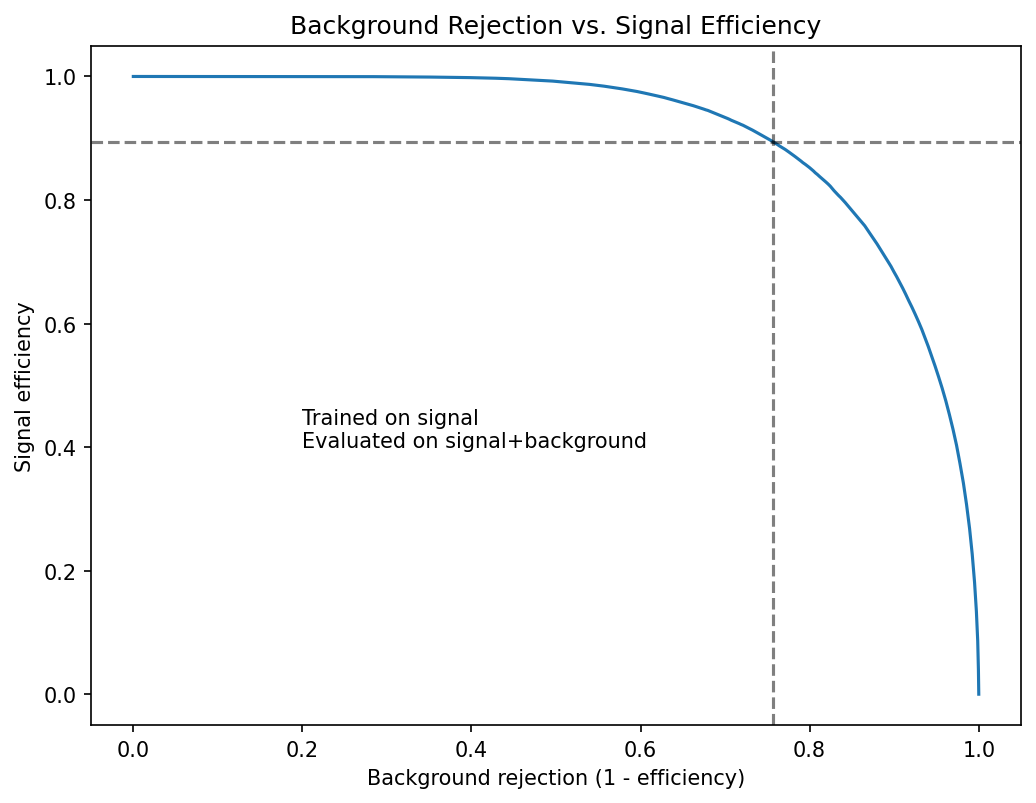

In [137]:
import math

plt.rcParams['figure.figsize'] = [8,6] 
plt.rcParams['figure.dpi'] = 150
min_val = 0
max_val = 1
step_size = 0.005
df = all_df
output_branch = branch_names.output_branch_name
signal_preds = df.max_signal_vals[output_branch]
background_preds = df.max_background_vals[output_branch]
nsignal = len(signal_preds)
nbackground = len(background_preds)
signal_effs = []
background_rejs = []
pred_vals = []
eff_metric = []
for i in np.arange(min_val, max_val, step_size):
    signal_cut = signal_preds[signal_preds > i]
    nsignal_cut = len(signal_cut)
    signal_eff = nsignal_cut / nsignal
    signal_effs.append(signal_eff)
    
    background_cut = background_preds[background_preds > i]
    nbackground_cut = len(background_cut)
    background_rej = 1 - nbackground_cut / nbackground
    background_rejs.append(background_rej)
    
    metric = math.sqrt(signal_eff**2 + background_rej**2)
    eff_metric.append(metric)
    
max_ind = eff_metric.index(max(eff_metric))
print('Optimal cut value')
print(max_ind * step_size)
print('\nOptimal signal efficiency')
print(f'{signal_effs[max_ind]:.2f}')
print('\nOptimal background rejection')
print(f'{background_rejs[max_ind]:.2f}') 

plt.plot(background_rejs, signal_effs)
plt.axhline(signal_effs[max_ind], linestyle='--', color='black', alpha=0.5)
plt.axvline(background_rejs[max_ind], linestyle='--', color='black', alpha=0.5)
plt.text(0.2, 0.4, 'Trained on signal\nEvaluated on signal+background')
plt.title('Background Rejection vs. Signal Efficiency')
plt.xlabel('Background rejection (1 - efficiency)')
plt.ylabel('Signal efficiency')
plt.show()

### Train on signal + ttbar

In [26]:
sigbar_branches = ak.concatenate([samples['X1000'].branches, samples['X1600'].branches, samples['X2000'].branches, samples['ttbar'].branches, samples['Z+jets'].branches])
print(len(sigbar_branches))
sigbar_branches['AllNNPred'] = all_data.df(all_model, device).all_vals['Pred']
#sigbar_branches = sigbar_branches[0:1]
sigbar_branches = sigbar_branches[sigbar_branches['SampleID'] < 4]
sigbar_branches = sigbar_branches[sigbar_branches['AllNNPred'] > 0.5]
print(len(sigbar_branches))

394952
182244


[0.952, 0.602, 0.941, 0.573, 0.834, 0.503, ... 0.863, 0.69, 0.536, 0.515, 0.619]


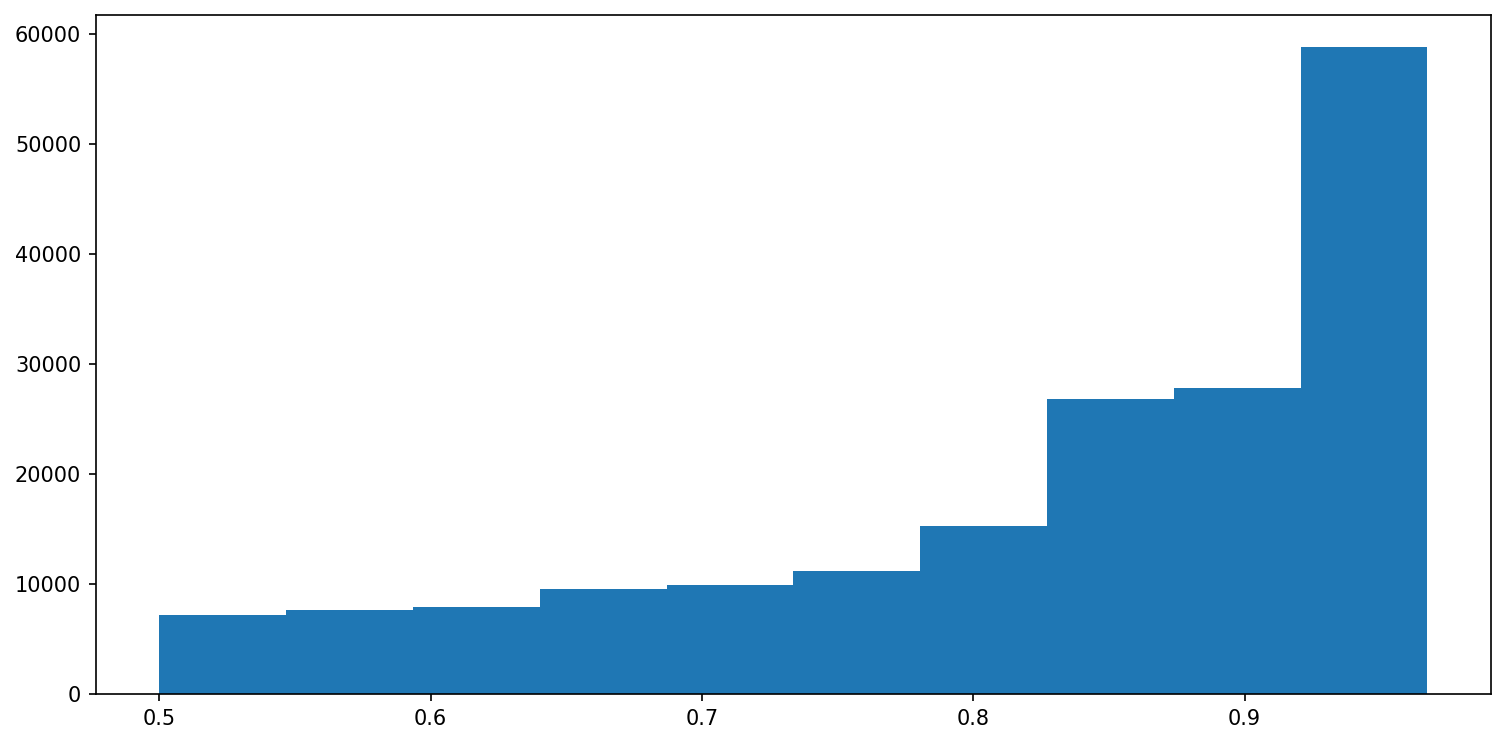

In [27]:
print(sigbar_branches['AllNNPred'])
plt.hist(sigbar_branches['AllNNPred'])
plt.show()

In [28]:
sigbar_data = AdHocData(sigbar_branches, branch_names, all_scaler)
sigbar_data.split_data(0)
sigbar_data.prepare_training_data()
sigbar_data.prepare_full_data()

In [18]:
print(sigbar_branches['DiHiggsM'])

[1.45e+03, 1.59e+03, 924, 881, 799, 601, ... 1.36e+03, 966, 1.03e+03, 488, 864, 862]


In [23]:
# for data in sigbar_data.dataloader.dataset:
#     print(data)
#     break
vals = pred_vals(sigbar_data.dataloader, all_model, device)
print(len(vals))
for val in vals:
    print(val[0])

4
0.96609056
[-0.64210459  0.80095032 -0.89664499 -0.62847559  0.97379441  1.28868995
 -0.88759082  1.53495045  0.49859046  1.25112526 -0.88701872  0.92301716
  0.01028855  0.91631689 -0.49226102  0.86862569  0.09720092  0.67970484
 -0.90536993]
0
[ 8.02558350e+13  0.00000000e+00  3.31514835e-04  2.14671902e-03
  5.03575027e-01  1.45014697e+03  2.73050308e+01  7.99106538e-01
 -1.61570764e+00  3.64972038e+01  3.53219330e+02  1.25767136e+00
 -1.59740150e+00  6.71388184e+02  3.80520142e+02  1.22981298e+00
 -1.59871507e+00  7.07885376e+02  4.54679489e+01  6.86605835e+02
 -5.17717838e-01  1.57234108e+00  7.91063110e+02  1.27652557e+02
  0.00000000e+00]


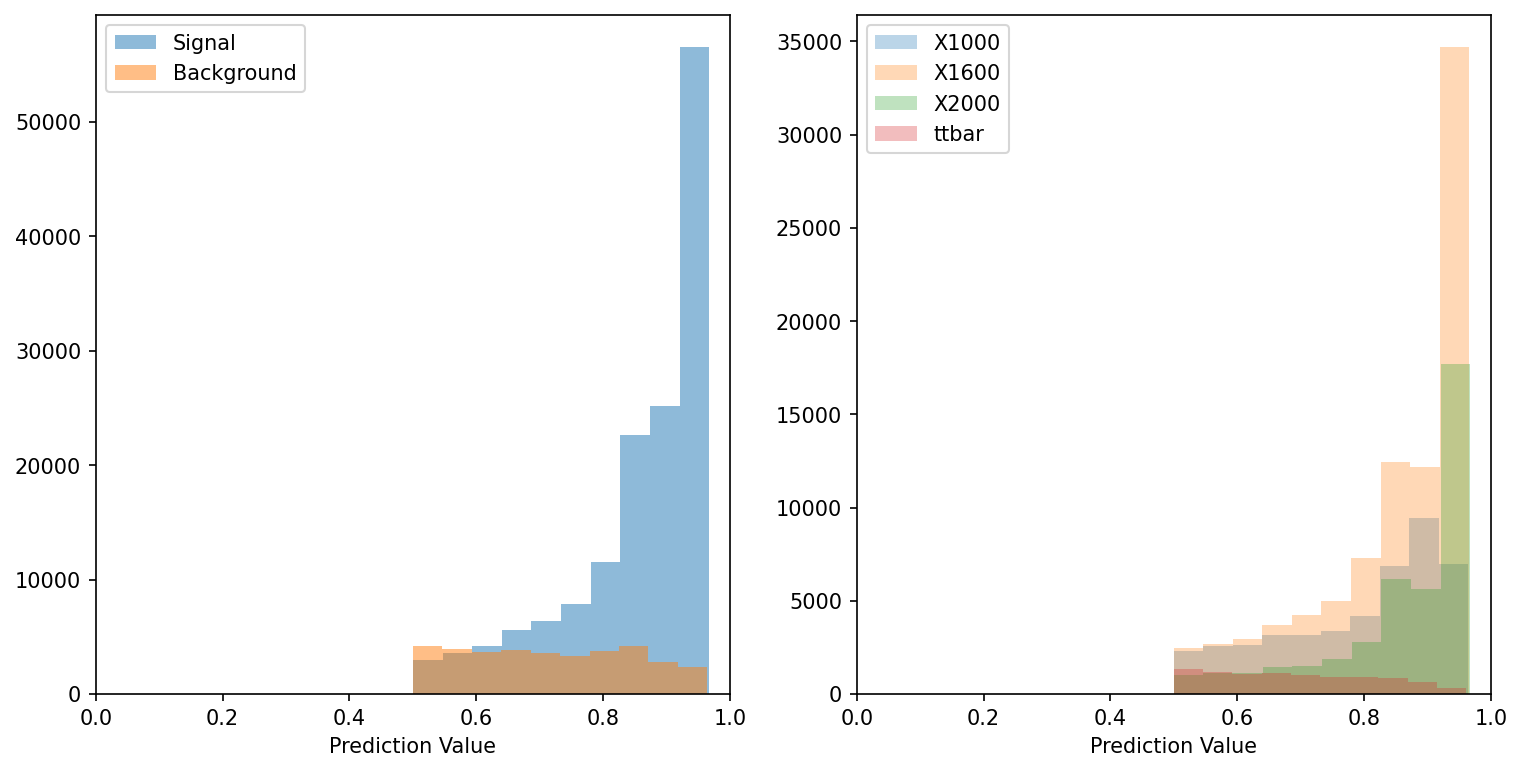

In [29]:
plot_predictions(sample_id_dict, sigbar_data.dataloader, all_model, device)

### Load and save model

In [34]:
torch.save(sigbar_model.state_dict(), '../trained_models/sigbar_dnn_v1')

In [19]:
sigbar_model = NeuralNetworkV1(branch_names)
sigbar_model.load_state_dict(torch.load('../trained_models/sigbar_dnn_v1'))

<All keys matched successfully>

In [30]:
sigbar_model = NeuralNetworkV1(branch_names).to(device)

### Train and test

100%|██████████| 1000/1000 [2:09:53<00:00,  7.79s/it] 


Done!


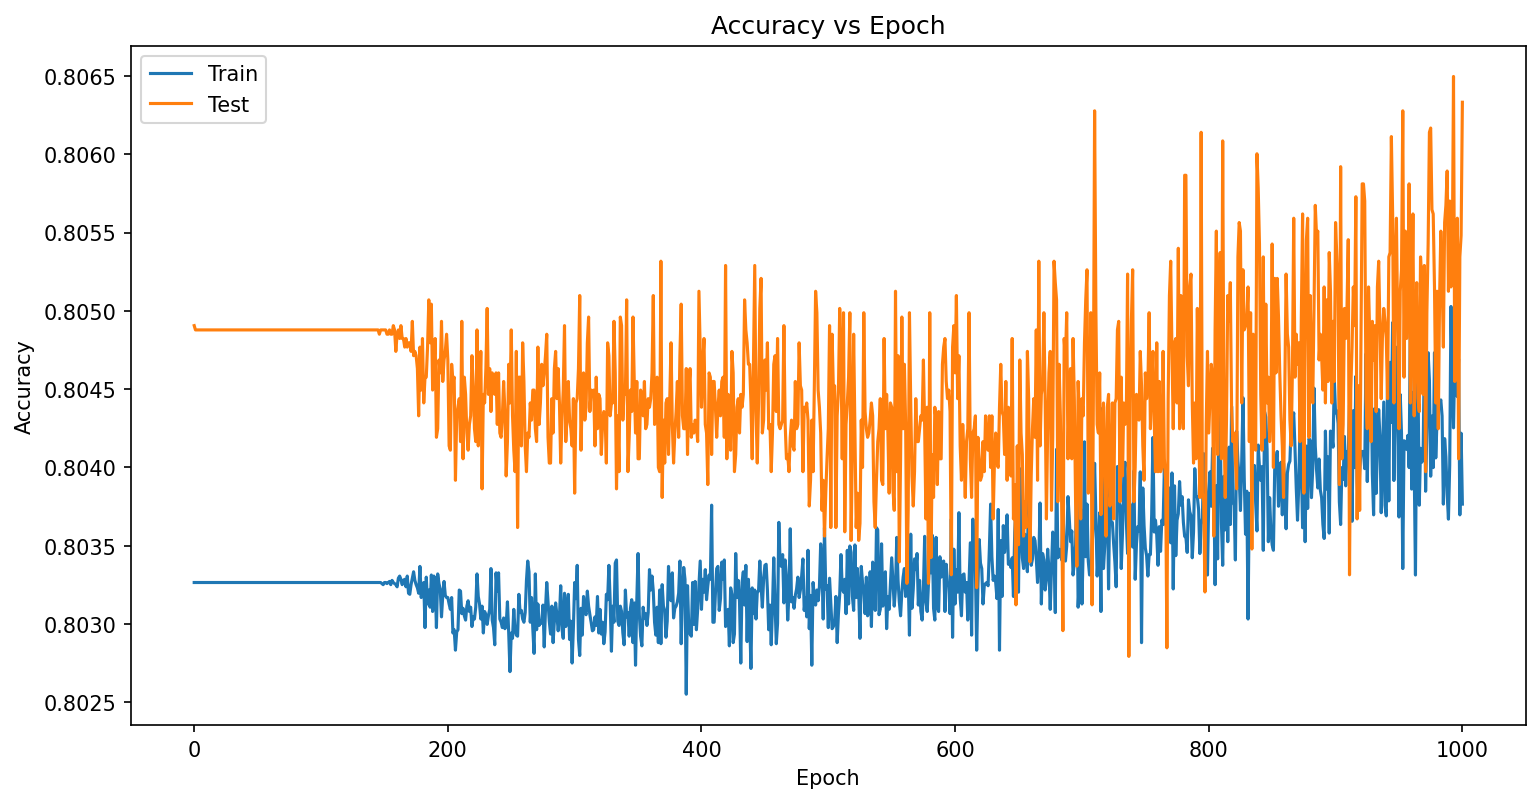

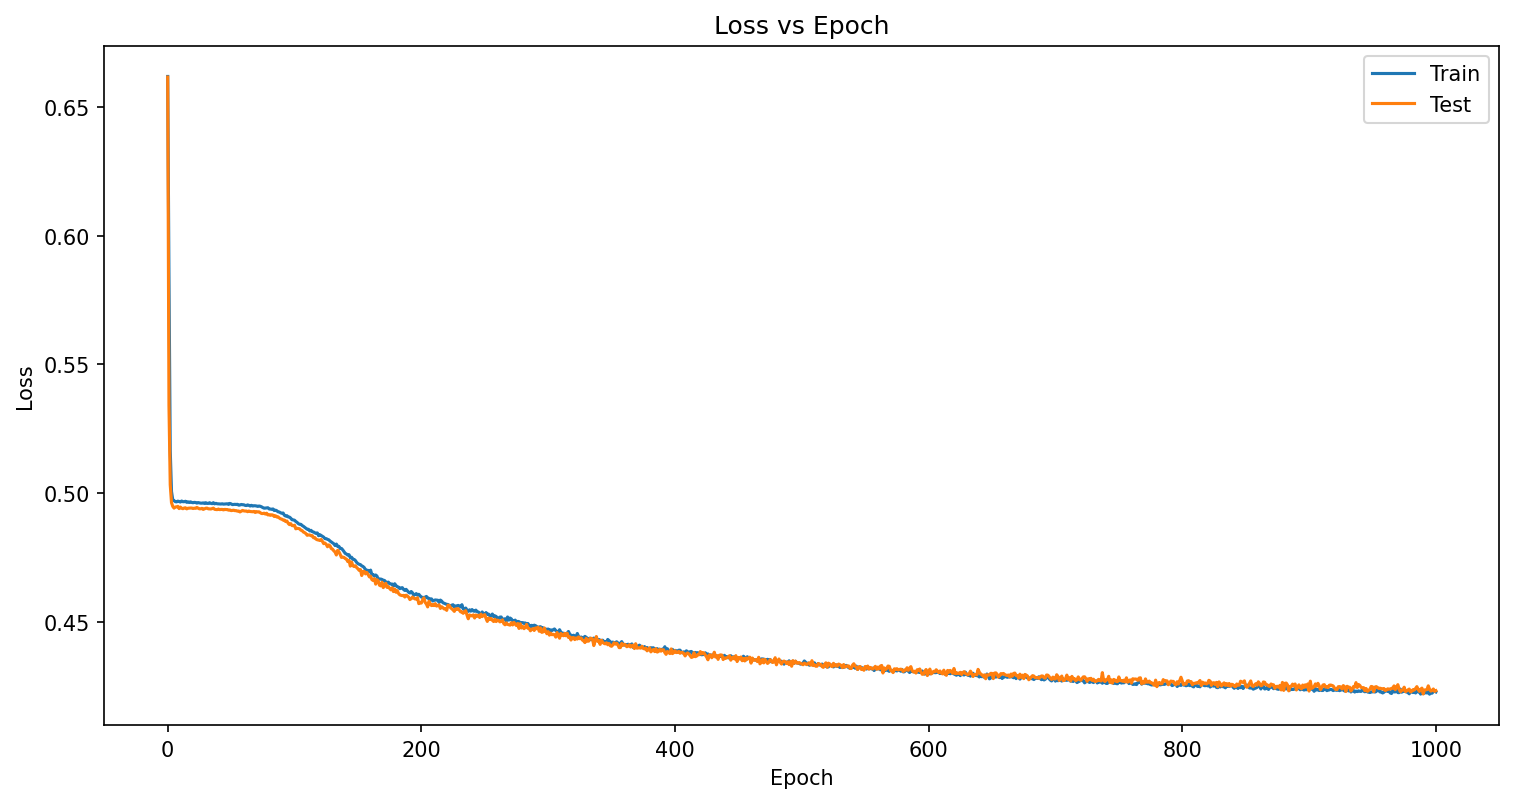

7798.68085584091


NeuralNetworkV1(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=19, out_features=38, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=38, out_features=57, bias=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=57, out_features=57, bias=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): ReLU()
    (9): Linear(in_features=57, out_features=57, bias=True)
    (10): Dropout(p=0.2, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=57, out_features=38, bias=True)
    (13): Dropout(p=0.2, inplace=False)
    (14): ReLU()
    (15): Linear(in_features=38, out_features=1, bias=True)
  )
)

In [31]:
sigbar_before = timer()
optimizer = torch.optim.SGD(sigbar_model.parameters(), lr=learning_rate)
train_nn(sigbar_data, sigbar_model, loss, optimizer, device, 1000)
sigbar_after = timer()
sigbar_duration = sigbar_after - sigbar_before
print(sigbar_duration)
sigbar_model.eval()

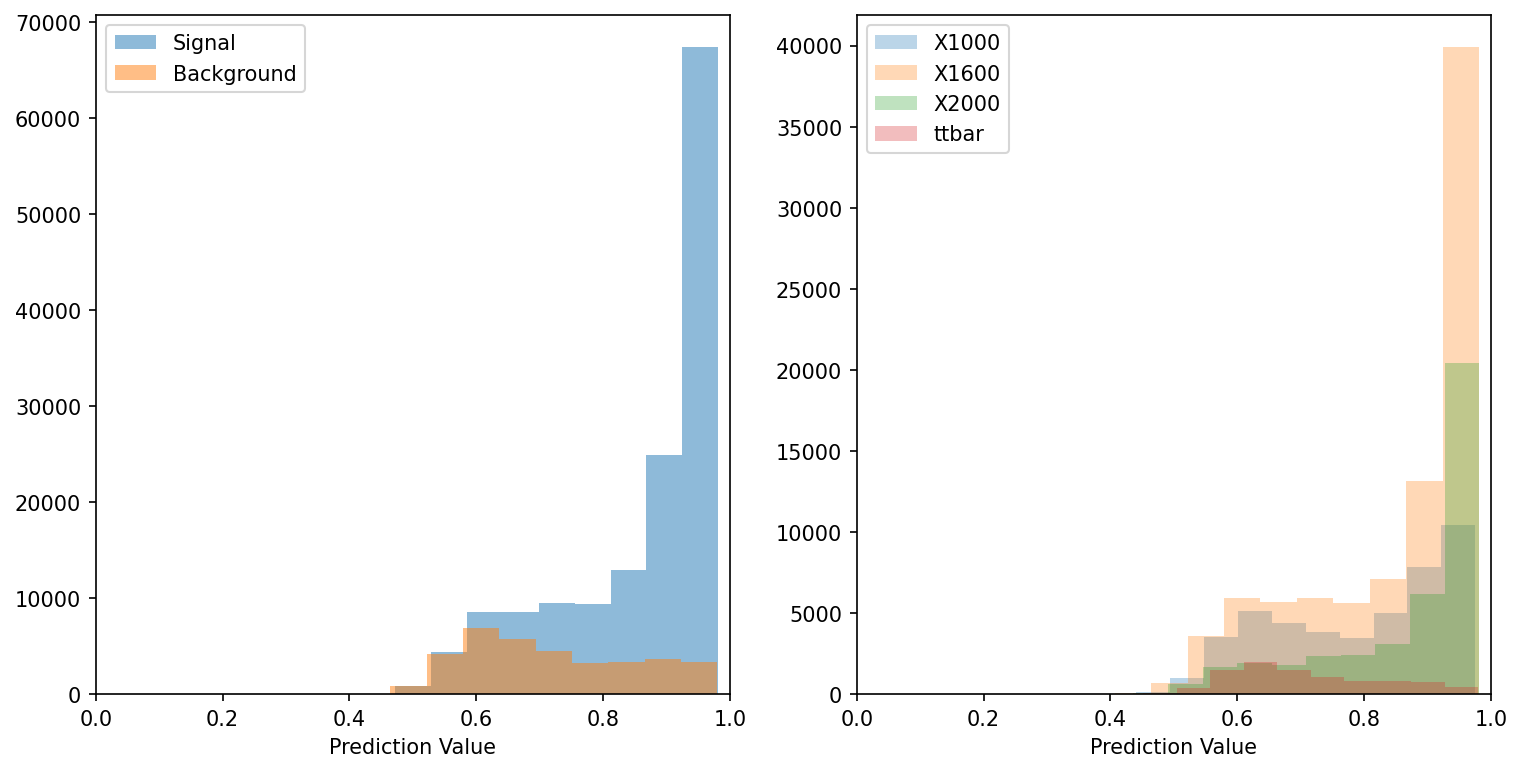

In [33]:
plot_predictions(sample_id_dict, sigbar_data.dataloader, sigbar_model, device)

### Add DiHiggs Mass

In [4]:
alt_branch_names = BranchNames()
alt_branch_names.input_branch_names += ['DiHiggsM']
print(alt_branch_names.input_branch_names)

['LeptonPt', 'LeptonEta', 'LeptonPhi', 'LeptonE', 'TauPt', 'TauEta', 'TauPhi', 'TauE', 'LepTauPt', 'LepTauEta', 'LepTauPhi', 'LepTauE', 'LepTauM', 'LargeRJetPt', 'LargeRJetEta', 'LargeRJetPhi', 'LargeRJetE', 'LargeRJetM', 'IsElectron', 'DiHiggsM']


In [5]:
alt_data = SampleData(sample_names, alt_branch_names)
alt_data.prepare_training_data()
alt_data.prepare_full_data()
alt_scaler = alt_data.scaler

### Create  model

In [7]:
alt_model = NeuralNetwork(alt_branch_names).to(device)

### Load and save model

In [10]:
torch.save(alt_model.state_dict(), '../trained_models/alltrain_altinputs_dnn_v1')

In [5]:
joblib.dump(alt_scaler, '../trained_models/alltrain_altinputs_dnn_v1_scaler.gz')

['../trained_models/alltrain_altinputs_dnn_v1_scaler.gz']

In [7]:
alt_model = NeuralNetwork(alt_branch_names)
alt_model.load_state_dict(torch.load('../trained_models/alltrain_altinputs_dnn_v1'))

<All keys matched successfully>

### Define loss and optimizer

In [8]:
learning_rate = 1e-3
loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(alt_model.parameters(), lr=learning_rate)

### Train and test

100%|██████████| 1000/1000 [3:39:58<00:00, 13.20s/it] 


Done!


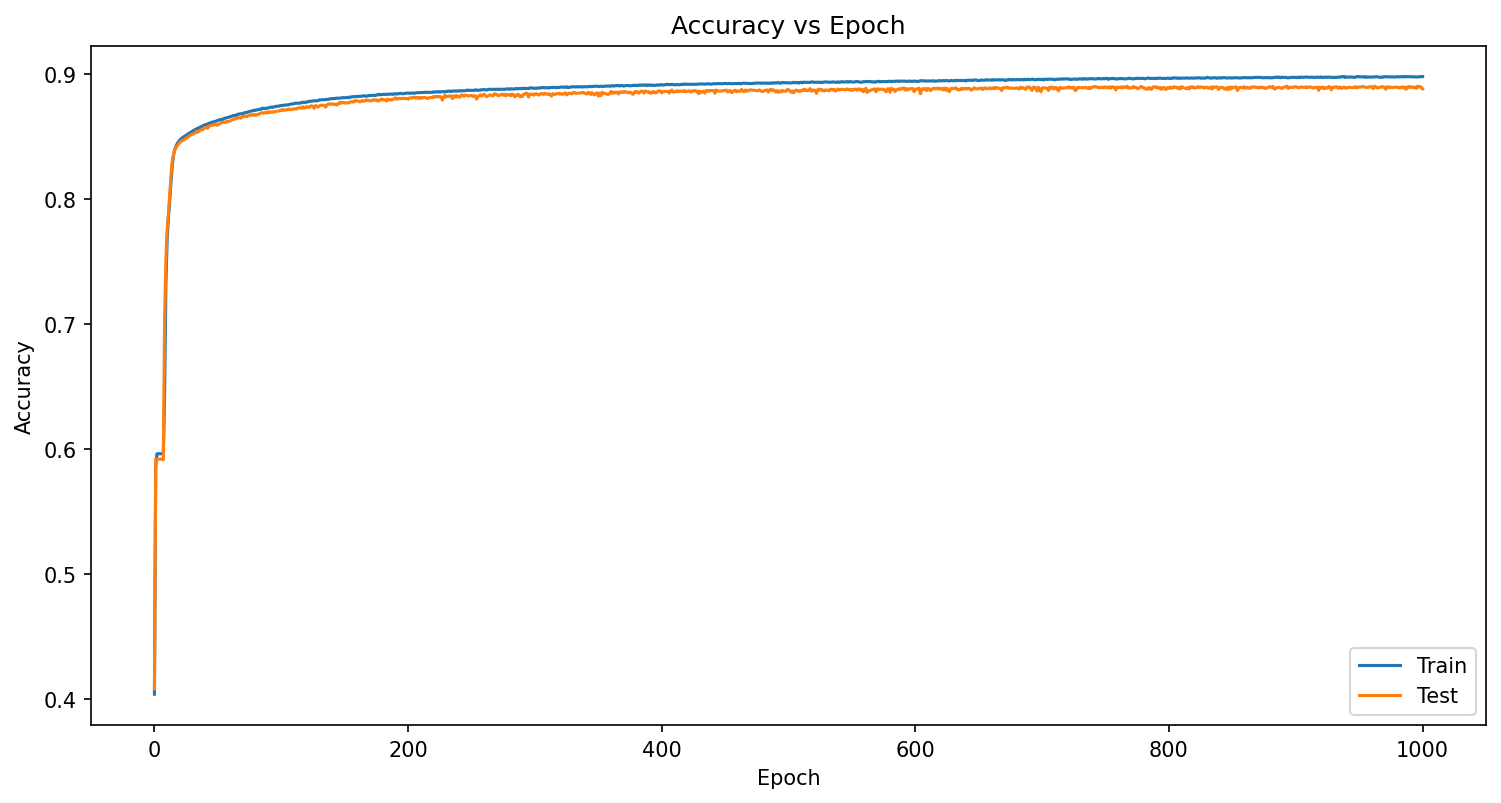

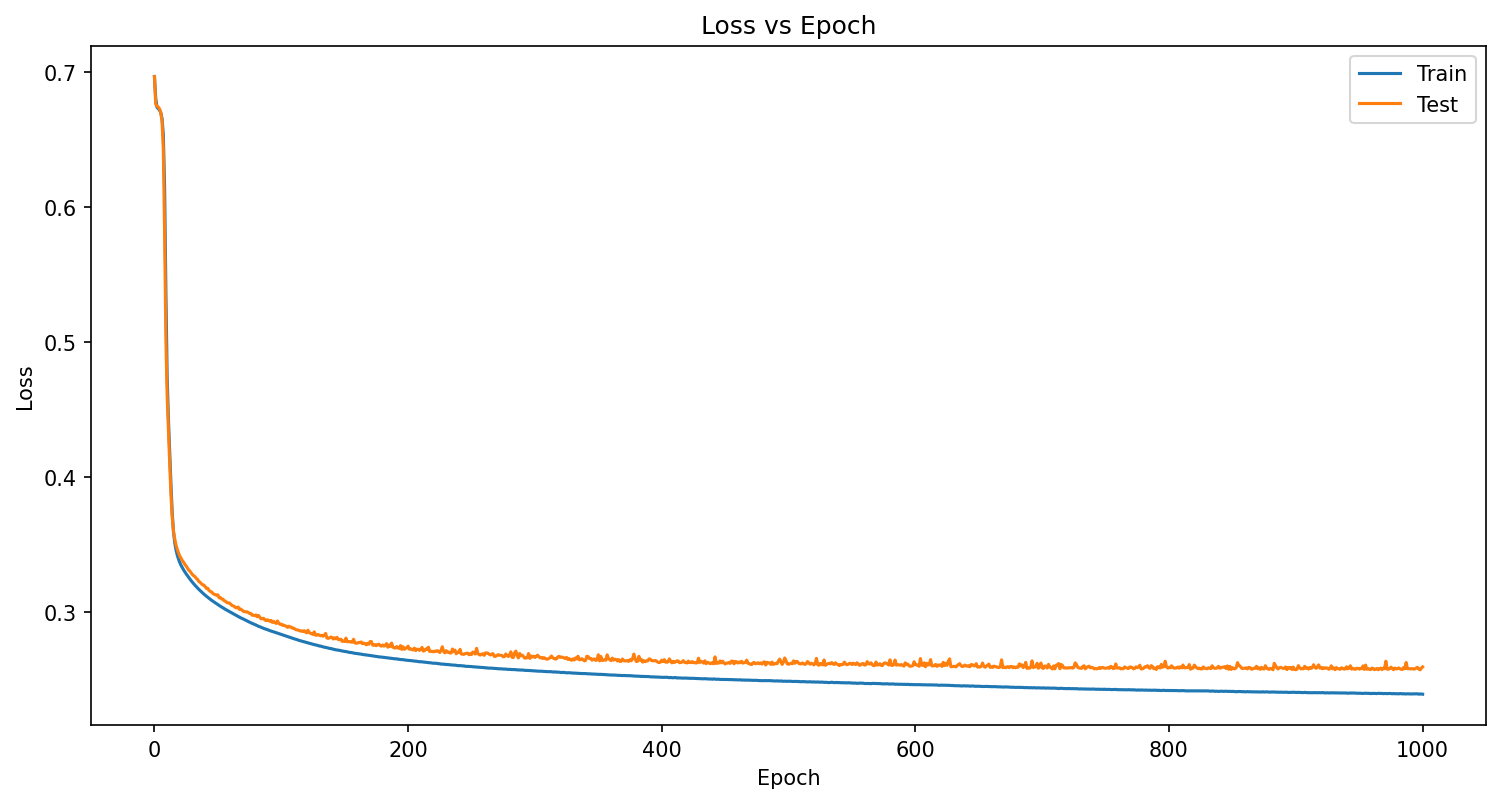

In [9]:
train_nn(alt_data, alt_model, loss, optimizer, device, 1000) 

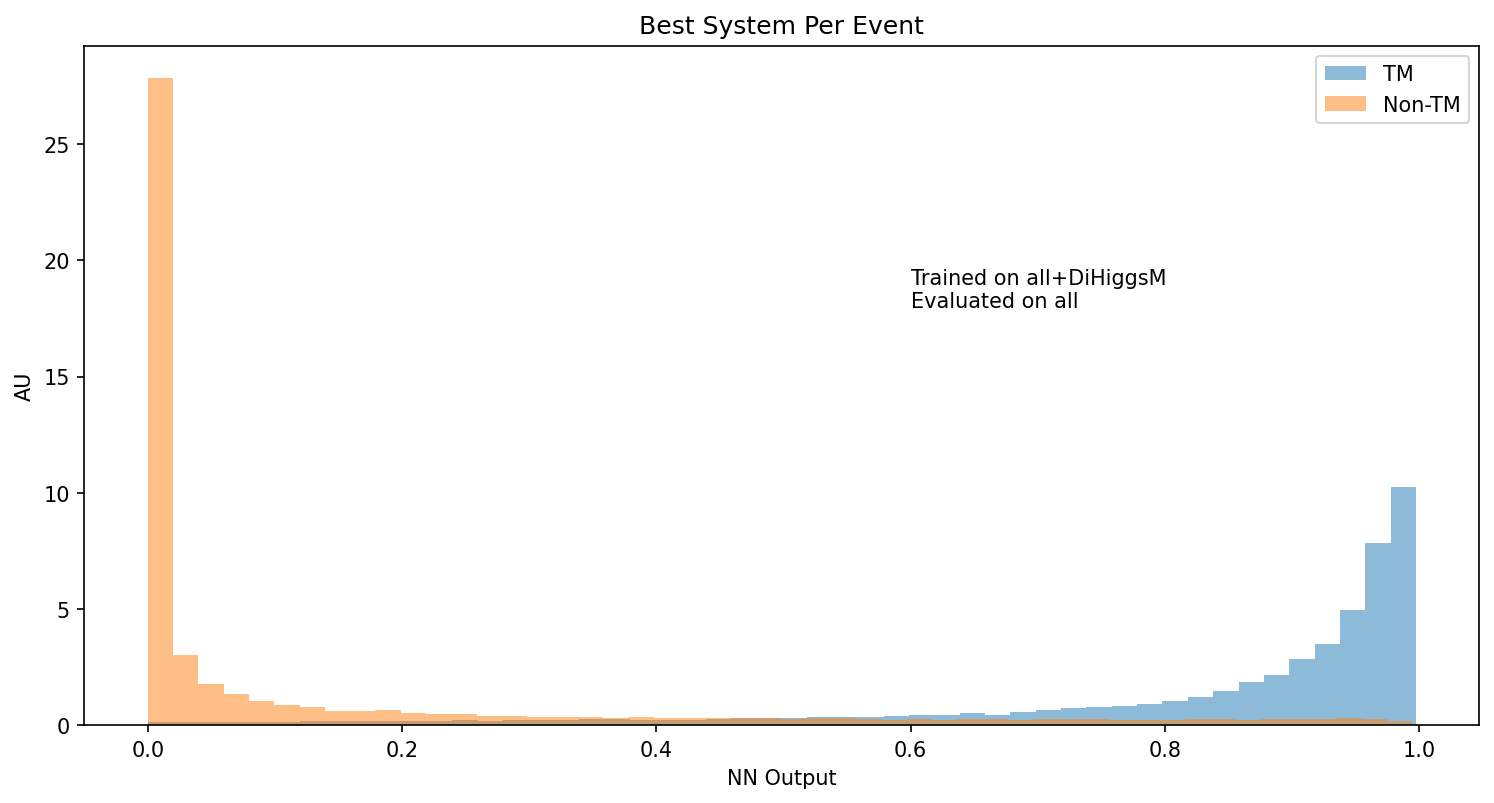

In [12]:
plot_best_system_pred(alt_data.test_df(alt_model), 'Trained on all+DiHiggsM', 'Evaluated on all')

In [13]:
final_loss, final_acc = test_loop(alt_data.test_dataloader, alt_model, loss)
print(f'Final loss: {final_loss:.3f}')
print(f'Final accuracy: {final_acc:.3f}')

Final loss: 0.259
Final accuracy: 0.888


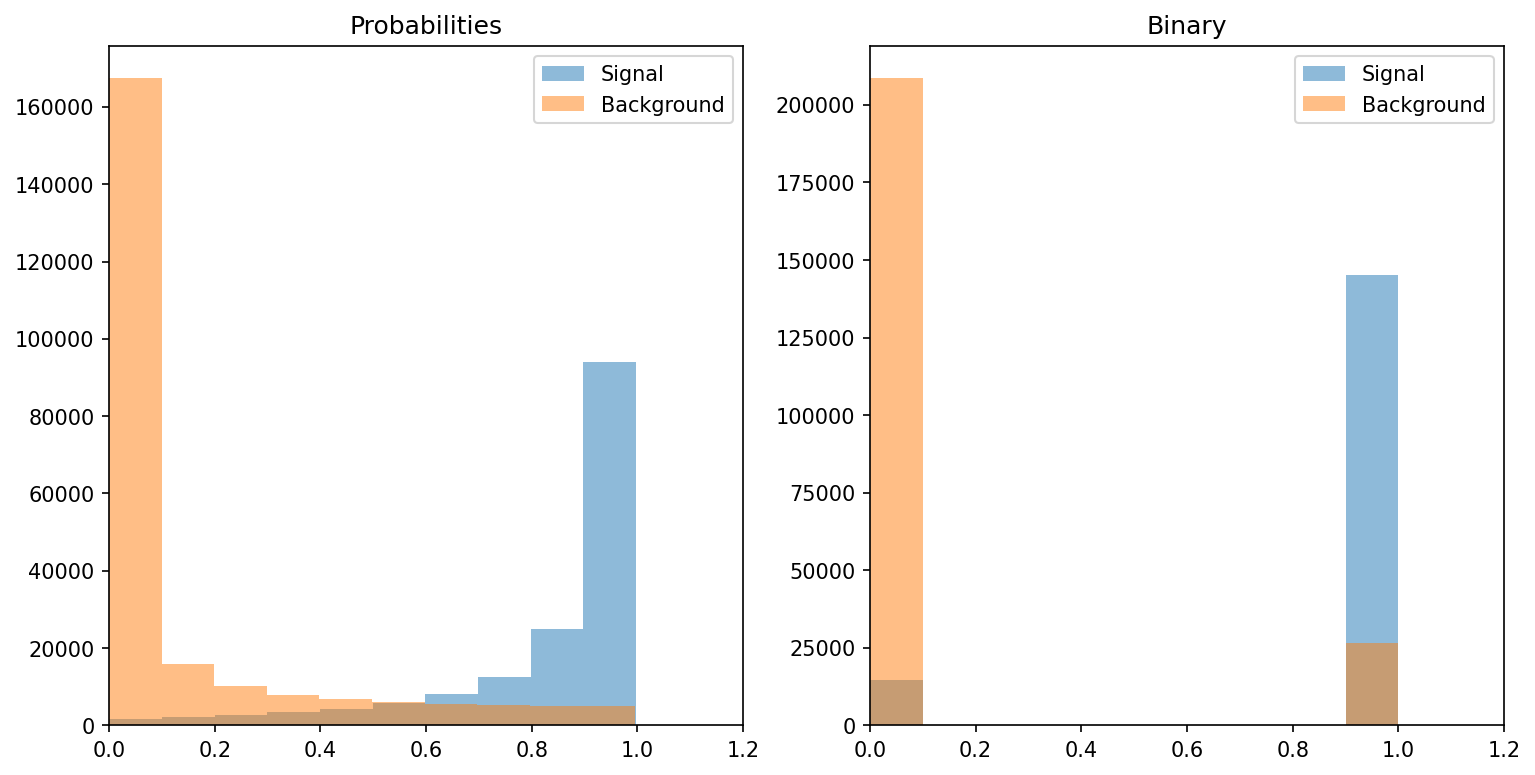

In [11]:
plot_predictions_by_truth(alt_data.dataloader, alt_model)

X1000 events: 89983
Signal: 46.6%
Background: 53.4%
X1600 events: 144842
Signal: 57.4%
Background: 42.6%
X2000 events: 68408
Signal: 57.1%
Background: 42.9%
ttbar events: 70191
Signal: 9.1%
Background: 90.9%
Z+jets events: 21528
Signal: 6.1%
Background: 93.9%


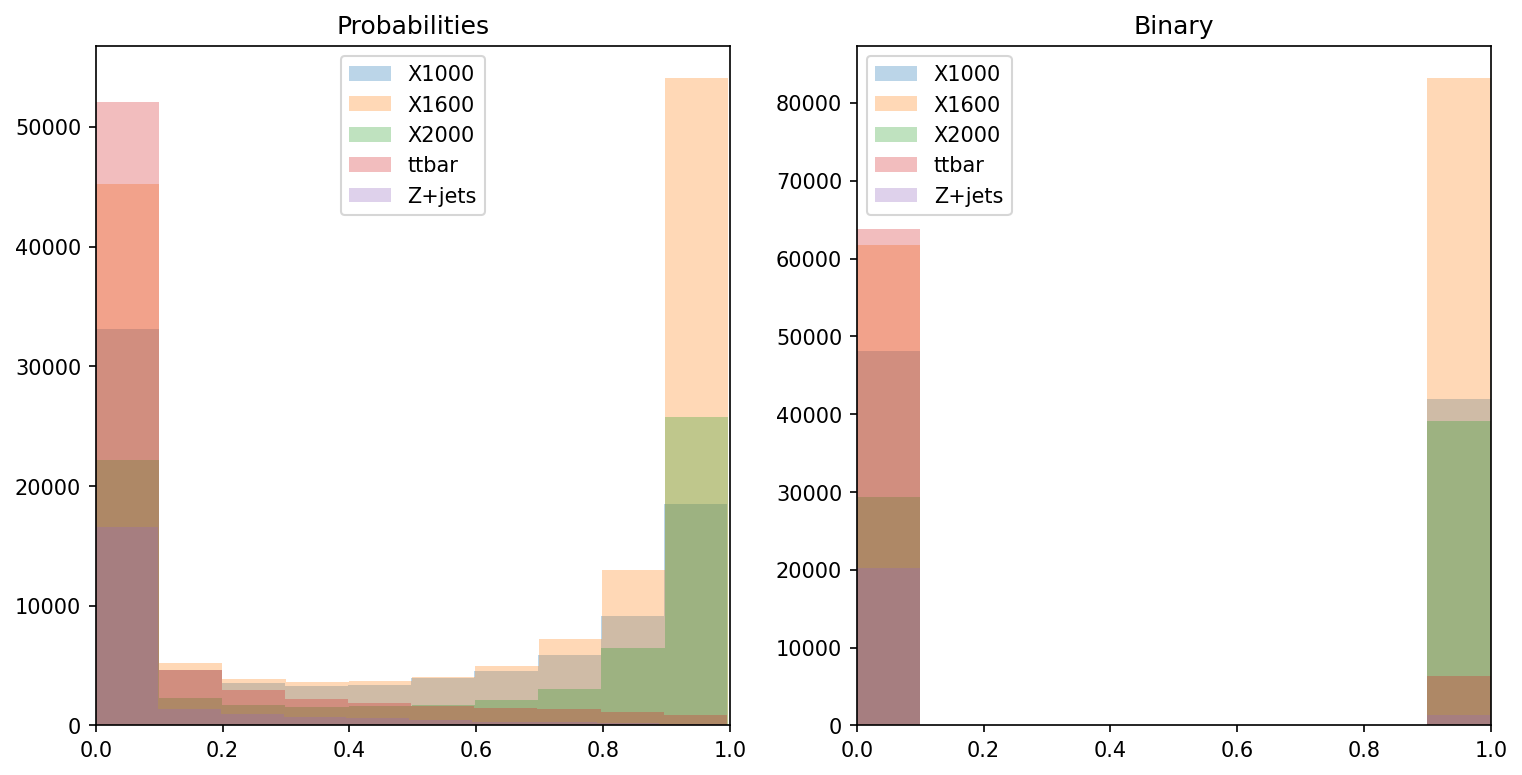

In [17]:
plot_predictions_by_sample(sample_id_dict, alt_data.dataloader, alt_model)

### Alternate TM Label

In [14]:
alt_branch_names = BranchNames()
alt_branch_names.label_branch_name = 'IsSignalCont'

In [15]:
alt_data = SampleData(sample_names, alt_branch_names)
alt_data.prepare_training_data()
alt_data.prepare_full_data()
alt_scaler = alt_data.scaler

### Create  model

In [16]:
alt_model = NeuralNetworkV1(alt_branch_names).to(device)

### Load and save model

In [10]:
torch.save(alt_model.state_dict(), '../trained_models/alltrain_contlabel_dnn_v1')

In [5]:
joblib.dump(alt_scaler, '../trained_models/alltrain_contlabel_dnn_v1_scaler.gz')

['../trained_models/alltrain_altinputs_dnn_v1_scaler.gz']

In [7]:
V1(alt_branch_names)
alt_model.load_state_dict(torch.load('../trained_models/alltrain_contlabel_dnn_v1'))

<All keys matched successfully>

### Define loss and optimizer

In [17]:
learning_rate = 1e-3
loss = nn.MSELoss()
optimizer = torch.optim.SGD(alt_model.parameters(), lr=learning_rate)

### Train and test

100%|██████████| 1000/1000 [4:01:11<00:00, 14.47s/it] 


Done!


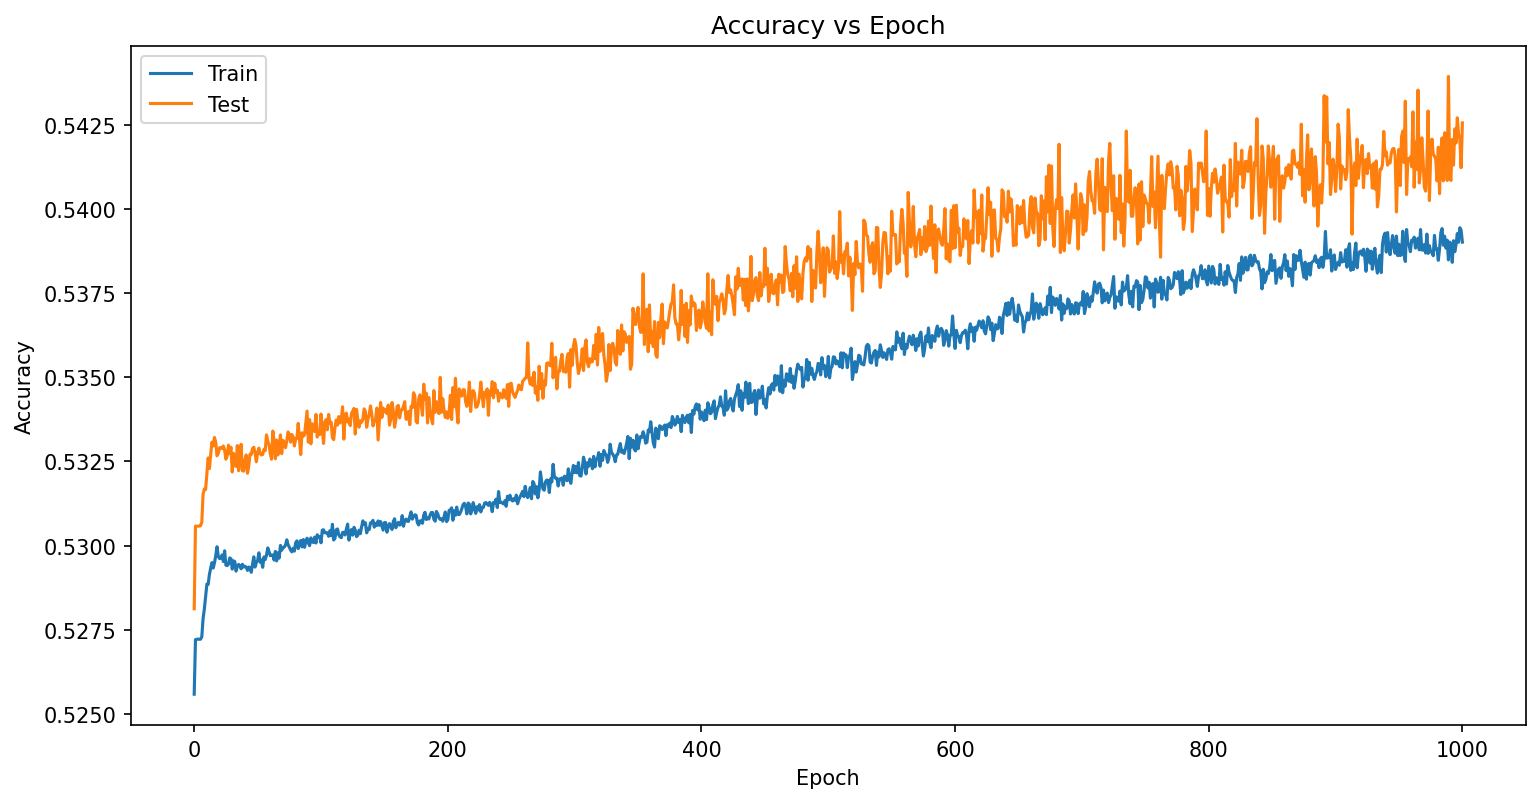

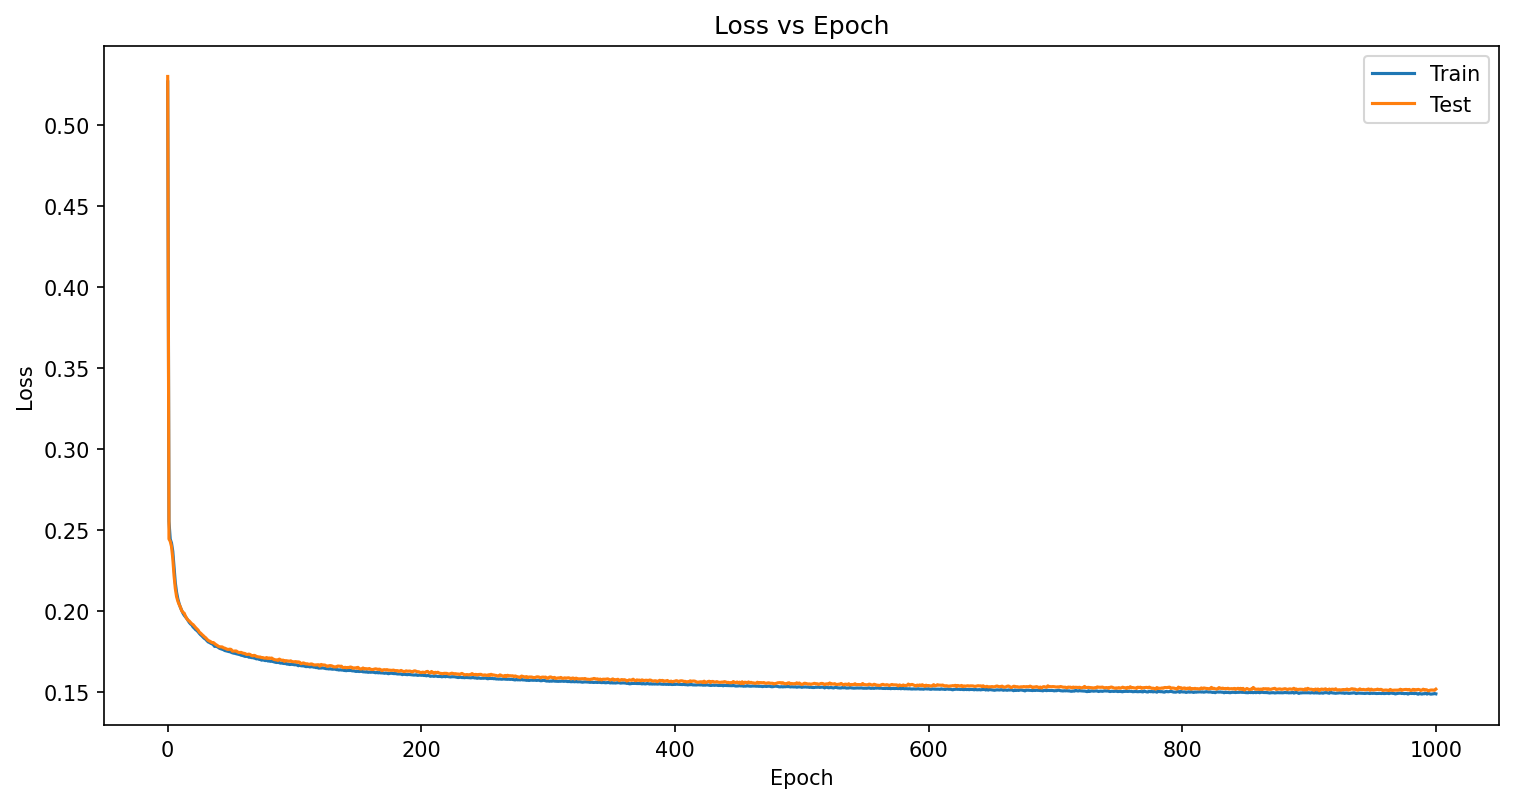

In [18]:
train_nn(alt_data, alt_model, loss, optimizer, device, 1000) 

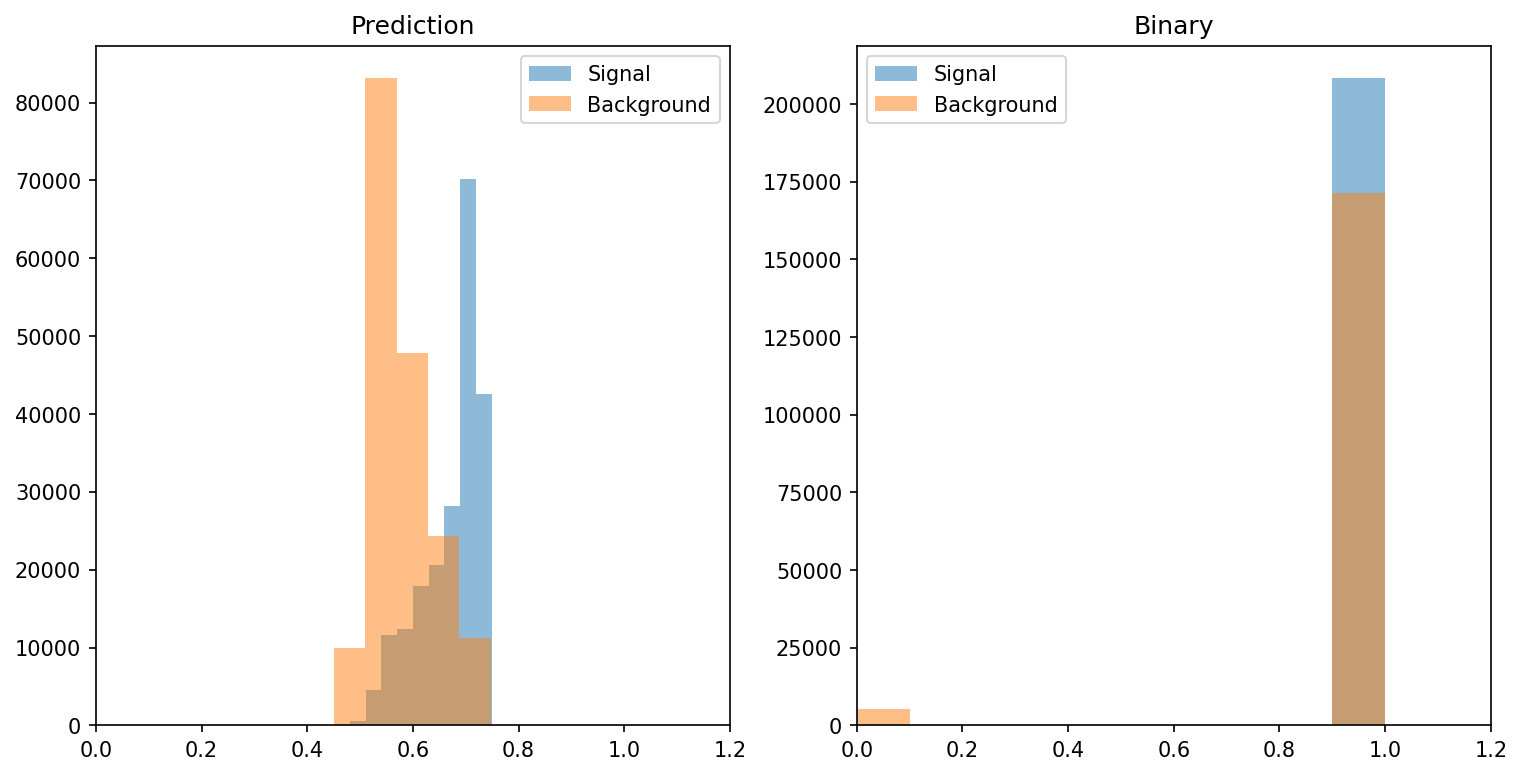

In [19]:
plot_predictions_by_truth(alt_data.dataloader, alt_model)

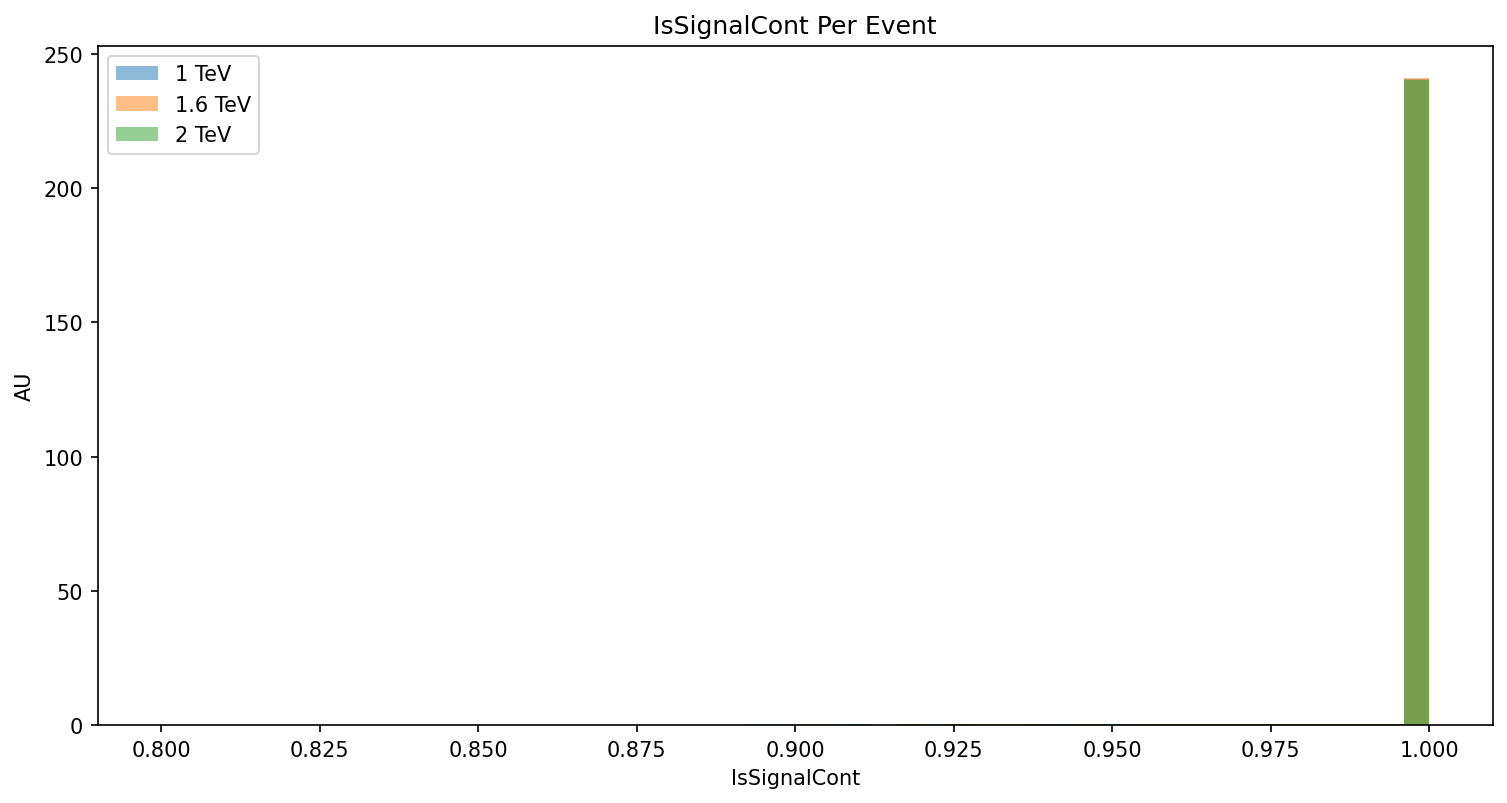

In [22]:
plt.rcParams['figure.figsize'] = [12,6] 
plt.rcParams['figure.dpi'] = 150

vals = alt_data.df(alt_model).all_vals
val_branch = 'IsSignalCont'
min_val = 0.8
max_val = 1
plt.hist(vals[val_branch][vals['SampleID'] == 0], bins=50, alpha=0.5, range=(min_val, max_val), label='1 TeV', density=True)
plt.hist(vals[val_branch][vals['SampleID'] == 1], bins=50, alpha=0.5, range=(min_val, max_val), label='1.6 TeV', density=True)
plt.hist(vals[val_branch][vals['SampleID'] == 2], bins=50, alpha=0.5, range=(min_val, max_val), label='2 TeV', density=True)
#plt.hist(vals[val_branch][vals['SampleID'] == 3], bins=50, alpha=0.5, range=(min_val, max_val), label='ttbar', density=True)
#plt.hist(vals[val_branch][vals['SampleID'] == 4], bins=50, alpha=0.5, range=(min_val, max_val), label='Z+jets', density=True)
plt.title('IsSignalCont Per Event')
#plt.text(, 0.001, 'Trained on all\nEvaluated on all')
plt.legend()
plt.xlabel('IsSignalCont')
plt.ylabel('AU')
plt.show()

In [23]:
print(len(alt_data.df(alt_model).all_vals))

394952


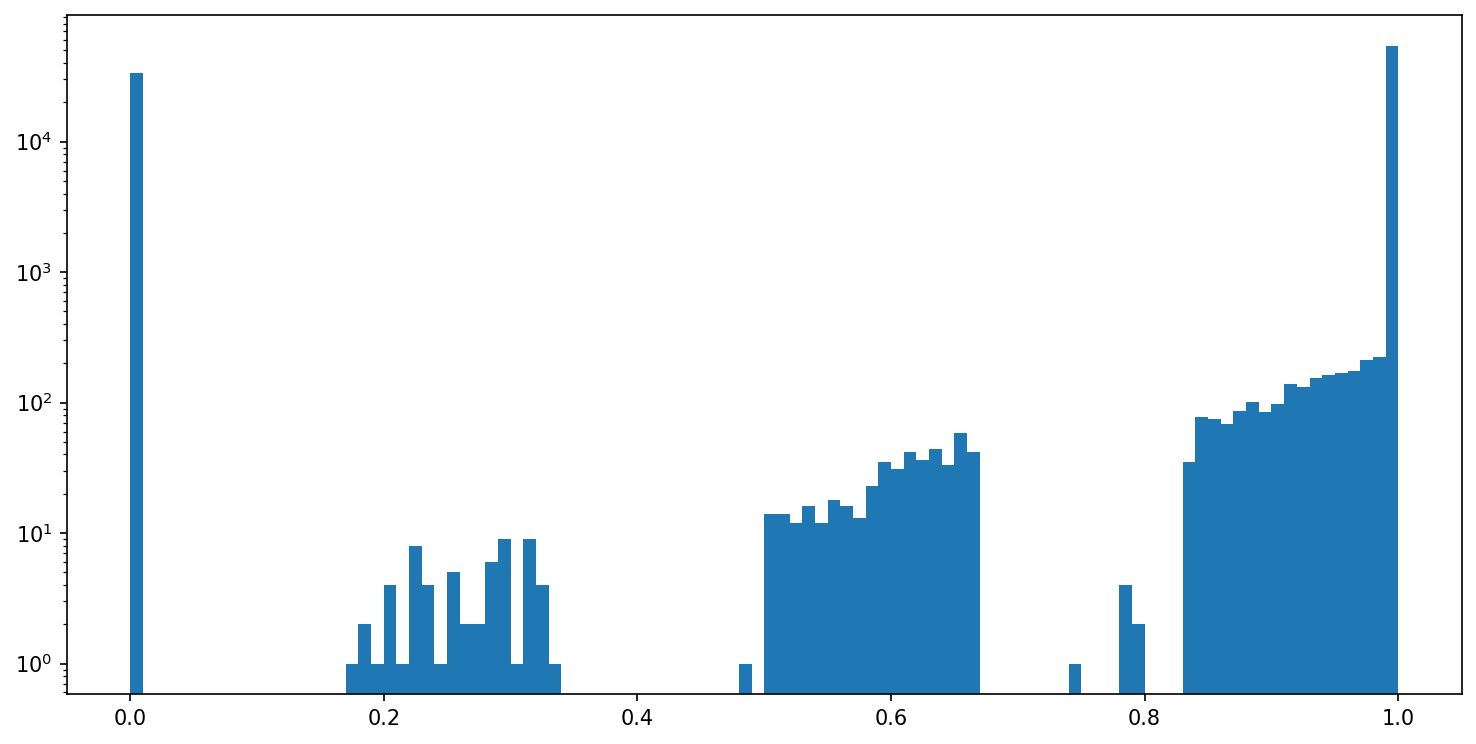

In [29]:
plt.hist(samples['X1000'].branches['IsSignalCont'], bins=100)
plt.yscale('log')
plt.show()

In [1]:
print(all_data)

NameError: name 'all_data' is not defined